# 충남대학교 컴퓨터비전
# Image Enhancement
# 목차

## 과제 Image Enhancement Network 구현


## 데이터 준비

## Custom Dataset class 작성  

In [2]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset
import natsort

class MIT_Adobe5k(Dataset):

    def __init__(self, root_path,
                 mode='train'):
        super(MIT_Adobe5k, self).__init__()

        self.dataset_dir = root_path
        self.input_folder = os.path.join(self.dataset_dir, 'input')
        self.gt_folder = os.path.join(self.dataset_dir, 'user-c')

        self.input_images_list = natsort.natsorted(os.listdir(self.input_folder))
        self.gt_images_list = natsort.natsorted(os.listdir(self.gt_folder))

        self.mode = mode

        if self.mode == 'train':
            # 5000개 중 4500를 train으로 사용
            self.input_images_list = self.input_images_list[:4500]
            self.gt_images_list = self.gt_images_list[:4500]

        else:
            # 5000개 중 500개를 test로 사용
            self.input_images_list = self.input_images_list[4500:]
            self.gt_images_list = self.gt_images_list[4500:]


        assert len(self.input_images_list) == len(self.gt_images_list)

    def __len__(self):
        return len(self.input_images_list)

    def __getitem__(self, index):

        input_path = os.path.join(self.input_folder, self.input_images_list[index])
        gt_path = os.path.join(self.gt_folder, self.gt_images_list[index])

        img_name = self.input_images_list[index]
        input_img = cv2.imread(input_path)[:, :, ::-1].astype(np.float32)
        gt_img = cv2.imread(gt_path)[:, :, ::-1].astype(np.float32)

        # [0,255] -> [0, 1]
        input_img[:, :, 0] = input_img[:, :, 0] / input_img[:, :, 0].max()
        input_img[:, :, 1] = input_img[:, :, 1] / input_img[:, :, 1].max()
        input_img[:, :, 2] = input_img[:, :, 2] / input_img[:, :, 2].max()

        gt_img[:, :, 0] = gt_img[:, :, 0] / gt_img[:, :, 0].max()
        gt_img[:, :, 1] = gt_img[:, :, 1] / gt_img[:, :, 1].max()
        gt_img[:, :, 2] = gt_img[:, :, 2] / gt_img[:, :, 2].max()

        if self.mode == 'train':
            # train의 경우 256 x 256으로 resize
            input_img = cv2.resize(input_img, dsize=(256, 256))
            gt_img = cv2.resize(gt_img, dsize=(256, 256))

        input_img = torch.from_numpy(input_img).permute(2, 0, 1)
        gt_img = torch.from_numpy(gt_img).permute(2, 0, 1)

        # [0, 1] -> [-1, 1]
        input_img = (input_img - 0.5) / 0.5
        gt_img = (gt_img - 0.5) / 0.5

        return {"input_img":input_img, "gt_img":gt_img, "img_name":img_name}

In [3]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import os
import datetime
from torch.utils.data import DataLoader

root_path = '.'

train_dataset = MIT_Adobe5k(root_path=root_path, mode='train')
test_dataset = MIT_Adobe5k(root_path=root_path, mode='test')

In [4]:
# 데이터 구성 살펴보기 1
print("train data 개수 : {}".format(len(train_dataset)))
print("test data 개수 : {}".format(len(test_dataset)))

# Train 기준
for train_data in train_dataset:
  print('입력 영상 구조: {}'.format(train_data['input_img'].shape)) # 3 x H x W RGB 영상 Input
  print('정답 영상 구조: {}'.format(train_data['gt_img'].shape)) # 3 x H X W RGB 영상 GT
  break


train data 개수 : 4500
test data 개수 : 500
입력 영상 구조: torch.Size([3, 256, 256])
정답 영상 구조: torch.Size([3, 256, 256])


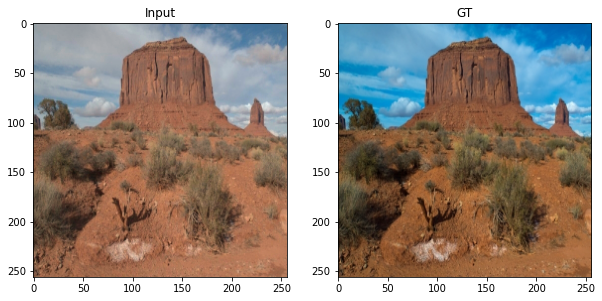

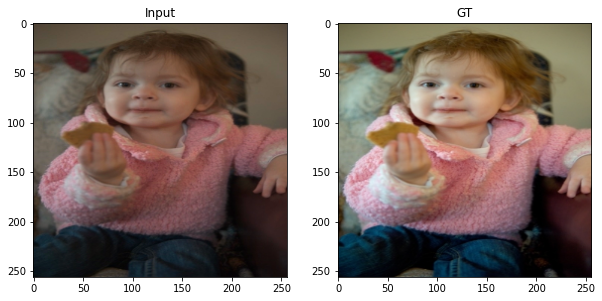

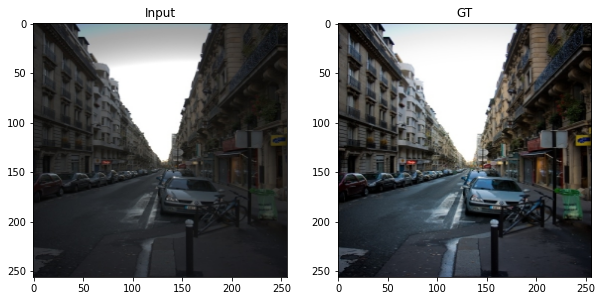

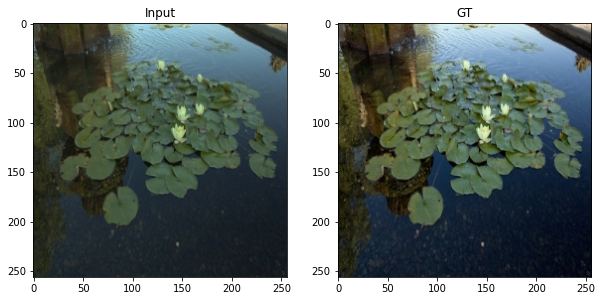

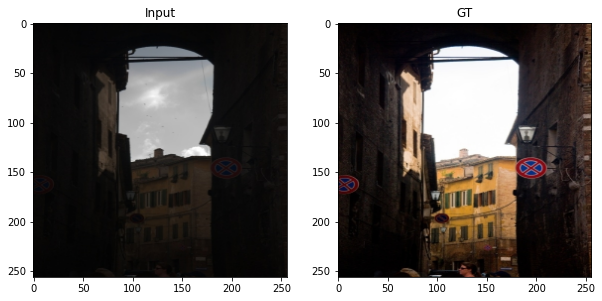

In [5]:
import matplotlib.pyplot as plt

def plot_results(output_list=[], output_name_list=[], cols=3):

  plt.rcParams['figure.figsize'] = (10, 8)
  rows = 1

  for i in range(cols):
    image_index = i + 1
    ttile = '{}'.format(output_name_list[i])
    plt.subplot(rows, cols, image_index)
    plt.title(ttile)


    if output_list[i].ndim == 3:
        plt.imshow(output_list[i])
    else:
        plt.imshow(output_list[i], cmap='gray')

  plt.show()
  return

# 데이터 구성 살펴보기 2
# Train 기준
for idx, train_data in enumerate(train_dataset):

  x = train_data['input_img']
  x = x.permute(1, 2, 0)
  x = (x * 0.5) + 0.5
  x = x.numpy()
  x = np.round(x * 255).astype(np.uint8)
  y = train_data['gt_img']
  y = y.permute(1, 2, 0)
  y = (y * 0.5) + 0.5
  y = y.numpy()
  y = np.round(y * 255).astype(np.uint8)

  plot_results(output_list=[x, y]
               , output_name_list=['Input', 'GT'], cols=2)

  # sample 5개만 출력
  if idx == 4:
    break



## Intensity Transform Module 구현
- `IntensitiyTransform` class 작성

In [70]:
DEVICE = 'cuda'
print(DEVICE)

cuda


In [71]:
import torch
import torch.nn.functional as F
from torch import nn

class Conv_block(nn.Module):

    def __init__(self, input_dim, out_dim, kernel_size, strides, dropout_rate=0.1):
        super(Conv_block, self).__init__()

        self.conv = nn.Conv2d(input_dim, out_channels=out_dim,kernel_size=kernel_size,
                               padding= kernel_size //2, stride=strides, bias=False)
        self.batch_norm = nn.BatchNorm2d(out_dim)
        self.act = nn.SiLU()

        if dropout_rate > 0:
            self.dropout = nn.Dropout(p=dropout_rate)

        self.apply(self._init_weights)

    def _init_weights(self, module):

        if isinstance(module, nn.Conv2d):
            nn.init.kaiming_uniform_(module.weight.data)
            if module.bias is not None:
                nn.init.constant_(module.bias.data, 0)

        elif isinstance(module, nn.BatchNorm2d):
            nn.init.constant_(module.weight.data, 1)
            nn.init.constant_(module.bias.data, 0)

    def forward(self, x, **kwargs):

        x = self.conv(x)
        x = self.batch_norm(x)
        x = self.act(x)
        if self.dropout is not None:
            x = self.dropout(x)

        return x


class IntensitiyTransform(nn.Module):

    def __init__(self, intensities, channels, **kwargs):
        super(IntensitiyTransform, self).__init__(**kwargs)
        self.channels = channels
        self.max_value = intensities - 1

    def forward(self, inputs):

        """
        인자 정보
        inputs: two inputs
        inputs[0]: 3 channel image normalized [-1, 1], bs x 3 x H x W
        inputs[1]: bs x 3 x 256 transform feature vectors per R, G, B  normalized [-1, 1]

        return
        outputs: bs x 3 x H x W
        """

        #######################################################
        # TODO Intensity Transform 구현
        # 참고 - 사용된 함수들 (반드시 아래 함수 안써도 됨 자유롭게 구현)
        # torch.split
        # torch.squeeze
        # F.one_hot
        # torch.bmm
        #######################################################
        images, transforms = inputs

        bs, c, h, w = images.shape

        # images [-1, 1] -> [0, 1]
        images = 0.5 * images + 0.5
        # images [0, 1] -> [0, self.scale] integer type
        denormalized_images = torch.round(self.max_value * images).type(torch.int64).to(DEVICE)
        
        
        
        transforms = transforms.unsqueeze(3).to(DEVICE)
        w_ = denormalized_images.size(3)
        i, cnt = 0, 1
        while w_ > cnt:
            cnt *= 2
            i += 1

        for _ in range(i):
            transforms = torch.cat([transforms, transforms], dim=3)

        images, transforms = torch.split(denormalized_images, 1, dim=1) , torch.split(transforms, 1, dim=1)

        c = torch.gather(input=transforms[0], dim=2, index=images[0])
        h = torch.gather(input=transforms[1], dim=2, index=images[1])
        w = torch.gather(input=transforms[2], dim=2, index=images[2])
        out = torch.cat([c, h, w], dim=1)

        return out


class Inverted_residual_block(nn.Module):

    def __init__(self ,filters_in=32, filters_out=16,
                 kernel_size=3, strides=1, expand_ratio=6,
                 se_ratio=0.25, dropout_rate=0.1):

        super(Inverted_residual_block, self).__init__()

        self.se_ratio = se_ratio
        self.dropout_rate = dropout_rate
        self.filters = filters_in * expand_ratio
        self.conv1 = nn.Conv2d(filters_in, self.filters, kernel_size=kernel_size, padding=kernel_size // 2,bias=False)

        self.batch_norm1 = nn.BatchNorm2d(self.filters)
        self.act1 = nn.SiLU()
        self.Depthwise_conv = nn.Conv2d(self.filters, self.filters, kernel_size=3,
                                         stride=strides, padding=1,bias=False, groups=self.filters)

        self.batch_norm2 = nn.BatchNorm2d(self.filters)
        self.act2 = nn.SiLU()

        if 0 < se_ratio <= 1:
            self.filters_se = max(1, int(filters_in * se_ratio))
            self.conv2 = nn.Conv2d(self.filters, self.filters_se , kernel_size=1, bias=False)
            self.act3 = nn.SiLU()
            self.conv3 = nn.Conv2d(self.filters_se, self.filters, kernel_size=1, bias=False)

            self.act4 = nn.Sigmoid()

        self.conv4 = nn.Conv2d(self.filters, filters_out, kernel_size=1, bias=False)

        self.batch_norm3 = nn.BatchNorm2d(filters_out)
        if dropout_rate > 0:
            self.dropout = nn.Dropout(p=dropout_rate)

        self.apply(self._init_weights)


    def _init_weights(self, module):

        if isinstance(module, nn.Conv2d):

            nn.init.kaiming_uniform_(module.weight.data)

            if module.bias is not None:
                nn.init.constant_(module.bias.data, 0)

        elif isinstance(module, nn.BatchNorm2d):
            nn.init.constant_(module.weight.data, 1)
            nn.init.constant_(module.bias.data, 0)

    def forward(self, x, **kwargs):

        bs = x.shape[0]
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.act1(x)
        x = self.Depthwise_conv(x)
        x = self.batch_norm2(x)
        x = self.act2(x)

        if 0 < self.se_ratio <= 1:

            # Global average pooling
            se = F.adaptive_avg_pool2d(x, (1, 1))
            se = se.reshape((bs,-1, 1, 1))
            se = self.conv2(se)
            se = self.act3(se)
            se = self.conv3(se)
            se = self.act4(se)
            x = x * se

        x = self.conv4(x)
        x = self.batch_norm3(x)

        if self.dropout_rate > 0:
            x = self.dropout(x)
        return x


class GEN(torch.nn.Module):

    def __init__(self):

        super(GEN, self).__init__()

        self.conv_block1 = Conv_block(input_dim=3, out_dim=16, kernel_size=5,
                                       strides=2, dropout_rate=0.1)

        self.conv_block2 = Inverted_residual_block(filters_in=16, filters_out=24,
                                                    kernel_size=5, strides=2,
                                                    dropout_rate=0.1)

        self.conv_block3 = Inverted_residual_block(filters_in=24, filters_out=40,
                                                    kernel_size=5, strides=2,
                                                    dropout_rate=0.1)

        self.conv_block4 = Inverted_residual_block(filters_in=40, filters_out=80,
                                                    kernel_size=5, strides=2,
                                                    dropout_rate=0.1)

        self.conv_block5 = Inverted_residual_block(filters_in=80, filters_out=112,
                                                    kernel_size=5, strides=2,
                                                    dropout_rate=0.1)

        self.conv_block6 = Conv_block(input_dim=112, out_dim=256 * 3,
                                      kernel_size=1, strides=1, dropout_rate=0.1)

        self.linear = nn.Linear(in_features= 256 * 3, out_features=256 * 3)

        self.tanh = nn.Tanh()

        self.intensity_transform = IntensitiyTransform(intensities=256, channels=3)



    def forward(self, x, is_train=True):

        """
        x : bs x 3 x H x W, normalized [-1, 1]
        """

        bs = x.shape[0]

        ##############################################################
        # Feature extraction
        # 6 Conv blocks : conv6 output : bs x 768 x H / 32 x W / 32
        features = self.conv_block1(x)
        features = self.conv_block2(features)
        features = self.conv_block3(features)
        features = self.conv_block4(features)
        features = self.conv_block5(features)
        features = self.conv_block6(features)
        ##############################################################

        ##############################################################
        # 3 channel Transformation
        # Global average pooling -> Linear -> activation(tanh)

        features = F.adaptive_avg_pool2d(features, (1, 1)).squeeze(dim=-1).squeeze(dim=-1)
        features = self.linear(features)
        features = features.reshape((bs, 3, 256))
        features = self.tanh(features)

        # out : [-1, 1] transform output
        out = self.intensity_transform(inputs=(x, features))
        ##############################################################

        if is_train:
            return out

        else:
            return out, features

## 훈련 및 평가하기

In [72]:
import torch
import torch.optim as optim
import torch.utils.data
from torch import nn

from tqdm import tqdm
import datetime
import numpy as np
import os
from math import exp
import math
import cv2

from torchvision.models import vgg16


def ssim_numpy(img1, img2, max_value):

    """
    SSIM for 2D (one-band) image
    """

    C1 = (0.01 * max_value)**2
    C2 = (0.03 * max_value)**2

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5]  # valid
    mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1**2
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(img1**2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(img2**2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                                                            (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()


def calculate_ssim(img1, img2, max_value=4095.0):

    """
    SSIM Metric
    img1: input image
    img2: gt image
    max_value: it depends on the number of bit in image
    for example, 8bit images have 255 and 12bit images have 4095
    """

    if not img1.shape == img2.shape:
        raise ValueError('Input images must have the same dimensions.')


    # gray scale image: H x W
    if img1.ndim == 2:
        return ssim_numpy(img1, img2, max_value)

    # multi-band image: H x W x C
    elif img1.ndim == 3:
        ssims = [ssim_numpy(img1[..., i], img2[..., i], max_value) for i in range(img1.shape[2])]
        return np.array(ssims).mean()
    else:
        raise ValueError('Wrong input image dimensions.')


def calculate_psnr(img1, img2, max_value=4095.0):

    """
    PSNR Metric
    img1: input image
    img2: gt image
    max_value: it depends on the number of bit in image
    for example, 8bit images have 255 and 12bit images have 4095
    """

    # convert float type
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    mse = np.mean((img1 - img2)**2)

    if mse <= 1e-10:
        print("test psnr inf")
        return np.inf

    if mse == 0:
        print("test psnr inf")
        return np.inf

    return 20 * math.log10(max_value / math.sqrt(mse))


class Vgg16(nn.Module):
    def __init__(self):
        super(Vgg16, self).__init__()
        features = vgg16(pretrained=True).features
        self.to_relu_1_2 = nn.Sequential()
        self.to_relu_2_2 = nn.Sequential()
        self.to_relu_3_3 = nn.Sequential()
        self.to_relu_4_3 = nn.Sequential()

        for x in range(4):
            self.to_relu_1_2.add_module(str(x), features[x])
        for x in range(4, 9):
            self.to_relu_2_2.add_module(str(x), features[x])
        for x in range(9, 16):
            self.to_relu_3_3.add_module(str(x), features[x])
        for x in range(16, 23):
            self.to_relu_4_3.add_module(str(x), features[x])

        for param in self.parameters():
            param.requires_grad = False

    def forward(self, x):
        h = self.to_relu_1_2(x)
        h_relu_1_2 = h
        h = self.to_relu_2_2(h)
        h_relu_2_2 = h
        h = self.to_relu_3_3(h)
        h_relu_3_3 = h
        h = self.to_relu_4_3(h)
        h_relu_4_3 = h
        out = [h_relu_1_2, h_relu_2_2, h_relu_3_3, h_relu_4_3]
        return out


class VGGLoss(nn.Module):
    def __init__(self):
        super(VGGLoss, self).__init__()
        self.vgg = Vgg16()
        self.criterion = nn.L1Loss()

    def forward(self, x, y):
        x_vgg, y_vgg = self.vgg(x), self.vgg(y)
        loss = 0
        for i in range(len(x_vgg)):
            loss += self.criterion(x_vgg[i], y_vgg[i].detach())
        return loss

def preprocess_for_metric(img):

    """
    img: [-1, 1] normalized image
    return [0, 1] normalized image
    """

    img = torch.clip(0.5 * (img + 1), min=0, max=1)

    return img


def tensor2img(tensor, out_type=np.uint8, max_value=255.0):

    """
    tensor:  normalized image
    return n-bit image
    """

    # batch removal
    tensor = tensor.squeeze(dim=0).float().cpu()  # clamp
    # [-1, 1] normalized image
    tensor = preprocess_for_metric(tensor)
    n_dim = tensor.dim()

    if n_dim == 3:

        # tensor: C x H x W
        # tensor -> numpy
        # (C x H x W) -> (H x W x C)
        img = tensor.numpy()
        img = np.transpose(img, (1, 2, 0))

    img = np.round((img * max_value))

    return img.astype(out_type)

def preprocess_for_vgg(image):

    """
    image: -1 ~ 1 normalized image
    """
    # [-1, 1] -> [0, 1]
    image = preprocess_for_metric(image)
    mean = torch.reshape(torch.tensor([0.485, 0.456, 0.406], device=image.device), (1, 3, 1, 1))
    std = torch.reshape(torch.tensor([0.229, 0.224, 0.225], device=image.device), (1, 3, 1, 1))

    # Imagenet mean-std transform
    input_tensor = (image - mean) / std
    return input_tensor

In [75]:
def train_and_eval():

    RESUME = False # Reusme 설정
    EPOCHS = 100
    BATCH_SIZE = 16
    LEARNING_RATE = 0.001
    device = 'cuda'
    SAVE_ROOT_PATH = './output'
    os.makedirs(SAVE_ROOT_PATH, exist_ok=True)

    SAVE_IMG_PATH = './output/result'
    os.makedirs(SAVE_IMG_PATH, exist_ok=True)

    SAVE_LOG_PATH = './output/log'
    os.makedirs(SAVE_LOG_PATH, exist_ok=True)

    SAVE_CHECKPOINT_PATH = './output/checkpoint'
    os.makedirs(SAVE_CHECKPOINT_PATH, exist_ok=True)

    now = datetime.datetime.now()
    now = now.strftime('%Y_%m_%d_%H_%M_%S')
    today_date = datetime.datetime.now().strftime("%m%d")

    root_path = '.'

    train_dataset = MIT_Adobe5k(root_path=root_path, mode='train')
    test_dataset = MIT_Adobe5k(root_path=root_path, mode='test')

    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               num_workers=0,
                                               batch_size=BATCH_SIZE,
                                               shuffle=True)

    test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                               num_workers=0,
                                               batch_size=1,
                                               shuffle=False)

    model = GEN()
    print("Model Architecture")
    print(model)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=50, gamma=0.5)
    model.to(device)

    l1_loss = nn.L1Loss()
    Perceptual_loss = VGGLoss()
    Perceptual_loss.to(device)

    if RESUME:
        # 다시 시작 설정
        print('------------------- Resume Settng -------------------')
        checkpoint_path = os.path.join(SAVE_CHECKPOINT_PATH, ) # checkpoint 경로
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict']) # 모델 가중치 업로드
        optimizer.load_state_dict(checkpoint['optim_state_dict']) # optimizer 파라미터 업로드
        epoch = checkpoint['epoch'] + 1 # epoch 업데이트
        best_psnr = checkpoint['best_psnr'] # 최고 psnr 업데이트

    else:
        # 첫 시작 에포크 및 psnr 초기화
        epoch = 1
        best_psnr = 0.0

    print("#####################################################################")
    print("Train information")
    print("batch size: {}".format(BATCH_SIZE))
    print("Learning rate: {}".format(LEARNING_RATE))
    print("Total Epochs: {}".format(EPOCHS))
    print("Train dataset number: {}".format(len(train_dataset)))
    print("Test dataset number: {}".format(len(test_dataset)))
    print('# Network parameters:', sum(param.numel() for param in model.parameters()))
    print("#####################################################################")

    with open(os.path.join(SAVE_LOG_PATH, 'log.txt'), 'w') as f:
        f.write('Train & Test results \n')

    # l1 loss와 perceptual loss의 balance를 조정하는 파라미터 상수
    LAMBDA_P = 0.1

    for epoch in range(epoch, EPOCHS + 1):

        train_iter = 0.0
        total_loss_total = 0.0
        l1_loss_total = 0.0
        percep_loss_total = 0.0
        model.train()

        for train_data in tqdm(train_loader):

            # input: [-1, 1] normalized image
            # gt: [-1, 1] normalized image

            input_image = train_data["input_img"]
            gt_image = train_data["gt_img"]

            train_iter += 1
            batch_size = gt_image.size(0)

            ############################
            # Update network
            ############################
            if torch.cuda.is_available():
                input_image = input_image.to(device)
                gt_image = gt_image.to(device)

            optimizer.zero_grad()

            # model output
            # [-1, 1] model logit
            # Forward - 모델 예측 수행
            prediction_tensor = model(input_image)

            # l1 loss 계산
            l1_loss_per_iter = l1_loss(prediction_tensor, gt_image)
            # Perceptual loss 계산
            percep_loss_per_iter = Perceptual_loss(preprocess_for_vgg(prediction_tensor), preprocess_for_vgg(gt_image))
            percep_loss_per_iter = LAMBDA_P * percep_loss_per_iter
            # Total loss = l1 loss + perceptual loss
            total_loss = l1_loss_per_iter + percep_loss_per_iter

            # Loss - Backpropagation
            total_loss.mean().backward()
            # Weight updates
            optimizer.step()

            print('[%s] [%d/%d], Total loss : %f, L1 loss: %f Perceptual_loss : %f'
                  % (datetime.datetime.now().strftime("%m%d_%H:%M"), train_iter, len(train_loader),
                  total_loss.mean().item(), l1_loss_per_iter.item(), percep_loss_per_iter.item()))

            l1_loss_total += l1_loss_per_iter.item()
            total_loss_total += total_loss.item()
            percep_loss_total += percep_loss_per_iter.item()

        print('[%s] epoch [%d/%d], Total loss : %f, L1 loss: %f perceptual_loss : %f'
                  % (datetime.datetime.now().strftime("%m%d_%H:%M"), epoch, EPOCHS,
                  total_loss_total / train_iter, l1_loss_total / train_iter, percep_loss_total / train_iter))

        ssim_total = 0.0
        psnr_total = 0.0
        model.eval()
        test_iter = 0.0

        for test_data in tqdm(test_loader):

            # input: [-1, 1] normalized image
            # gt: [-1, 1] normalized image

            input_image = test_data["input_img"]
            gt_image = test_data["gt_img"]
            img_name = test_data["img_name"][0]

            test_iter += 1
            batch_size = gt_image.size(0)

            ############################
            # Update network
            ############################
            if torch.cuda.is_available():
                input_image = input_image.to(device)
                gt_image = gt_image.to(device)

            # model 출력
            # [-1, 1] model logit
            with torch.no_grad():
                prediction_tensor = model(input_image)

            predicted_image = tensor2img(prediction_tensor, max_value=255.0)

            cv2.imwrite(os.path.join(SAVE_IMG_PATH, img_name), predicted_image[:, :, ::-1])

            gt_image = tensor2img(gt_image, max_value=255.0)

            # test PSNR & SSIM metric computes in 8-bit image [0, 255]
            test_psnr = calculate_psnr(predicted_image, gt_image, max_value=255.0)
            test_ssim = calculate_ssim(predicted_image, gt_image, max_value=255.0)

            psnr_total += test_psnr
            ssim_total += test_ssim

        # ----------------------------------------------------------------------------------------
        print('[%s] [%d/%d], test psnr : %f test ssim : %f'
              % (datetime.datetime.now().strftime("%m%d_%H:%M"),
                  epoch, EPOCHS, psnr_total / test_iter,
                  ssim_total / test_iter))


        previous_psnr = psnr_total / test_iter

        # 가중치 저장 - 가장 높은 수치의 psnr를 기록할 때만 checkpoint 저장
        if best_psnr < previous_psnr:
            best_psnr = previous_psnr
            # 훈련 재시작을 위해 훈련에 사용된 모든 파라미터를 저장 (checkpoint 라고 부름)
            torch.save({
            'model_state_dict': model.state_dict(), # 모델의 파라미터 정보를 저장
            'optim_state_dict': optimizer.state_dict(), # optimizer의 정보를 저장
            'epoch': epoch, # 에포크 저장
            'best_psnr': best_psnr # best psnr 저장
            }, os.path.join(SAVE_CHECKPOINT_PATH, 'epoch_{}_checkpoint.pt'.format(epoch))) # 경로 설정
            print("Model weight update!!")

        with open(os.path.join(SAVE_LOG_PATH, 'log.txt'), 'a') as f:
            f.write('[{}] epoch : {}, [Trian] - Total loss: {:.4f} L1 loss : {:.4f} Perceptual loss : {:.4f} \n [Test] - PSNR / SSIM: {:.4f} / {:.4f} \n'.format(
                    datetime.datetime.now().strftime("%m%d_%H:%M"),
                    epoch,
                    total_loss_total / train_iter,
                    l1_loss_total / train_iter,
                    percep_loss_total / train_iter,
                    psnr_total / test_iter,
                    ssim_total / test_iter,
                ))

In [76]:
# 훈련 및 평가
train_and_eval()

Model Architecture
GEN(
  (conv_block1): Conv_block(
    (conv): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (batch_norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): SiLU()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (conv_block2): Inverted_residual_block(
    (conv1): Conv2d(16, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (batch_norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): SiLU()
    (Depthwise_conv): Conv2d(96, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=96, bias=False)
    (batch_norm2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act2): SiLU()
    (conv2): Conv2d(96, 4, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (act3): SiLU()
    (conv3): Conv2d(4, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (act4): Sigmoid()
    (conv4): Conv2d(96, 

  0%|          | 1/282 [00:00<01:33,  3.00it/s]

[1129_14:02] [1/282], Total loss : 0.924542, L1 loss: 0.537159 Perceptual_loss : 0.387383


  1%|          | 2/282 [00:00<01:32,  3.02it/s]

[1129_14:02] [2/282], Total loss : 0.789623, L1 loss: 0.448027 Perceptual_loss : 0.341596


  1%|          | 3/282 [00:00<01:30,  3.10it/s]

[1129_14:02] [3/282], Total loss : 0.695840, L1 loss: 0.373156 Perceptual_loss : 0.322684


  1%|▏         | 4/282 [00:01<01:31,  3.05it/s]

[1129_14:02] [4/282], Total loss : 0.602373, L1 loss: 0.315288 Perceptual_loss : 0.287085


  2%|▏         | 5/282 [00:01<01:32,  3.00it/s]

[1129_14:02] [5/282], Total loss : 0.568686, L1 loss: 0.266523 Perceptual_loss : 0.302163


  2%|▏         | 6/282 [00:01<01:31,  3.03it/s]

[1129_14:02] [6/282], Total loss : 0.487384, L1 loss: 0.238480 Perceptual_loss : 0.248904


  2%|▏         | 7/282 [00:02<01:31,  3.00it/s]

[1129_14:02] [7/282], Total loss : 0.446981, L1 loss: 0.190649 Perceptual_loss : 0.256332


  3%|▎         | 8/282 [00:02<01:31,  3.00it/s]

[1129_14:02] [8/282], Total loss : 0.433747, L1 loss: 0.193517 Perceptual_loss : 0.240230


  3%|▎         | 9/282 [00:02<01:30,  3.03it/s]

[1129_14:02] [9/282], Total loss : 0.413114, L1 loss: 0.189638 Perceptual_loss : 0.223476


  4%|▎         | 10/282 [00:03<01:28,  3.07it/s]

[1129_14:02] [10/282], Total loss : 0.345576, L1 loss: 0.150208 Perceptual_loss : 0.195368


  4%|▍         | 11/282 [00:03<01:27,  3.08it/s]

[1129_14:02] [11/282], Total loss : 0.368555, L1 loss: 0.172928 Perceptual_loss : 0.195627


  4%|▍         | 12/282 [00:03<01:27,  3.10it/s]

[1129_14:02] [12/282], Total loss : 0.390846, L1 loss: 0.194330 Perceptual_loss : 0.196516


  5%|▍         | 13/282 [00:04<01:26,  3.10it/s]

[1129_14:02] [13/282], Total loss : 0.340114, L1 loss: 0.148845 Perceptual_loss : 0.191270


  5%|▍         | 14/282 [00:04<01:26,  3.09it/s]

[1129_14:02] [14/282], Total loss : 0.348245, L1 loss: 0.165700 Perceptual_loss : 0.182545


  5%|▌         | 15/282 [00:04<01:26,  3.09it/s]

[1129_14:02] [15/282], Total loss : 0.357578, L1 loss: 0.161717 Perceptual_loss : 0.195862


  6%|▌         | 16/282 [00:05<01:25,  3.10it/s]

[1129_14:02] [16/282], Total loss : 0.381335, L1 loss: 0.194223 Perceptual_loss : 0.187112


  6%|▌         | 17/282 [00:05<01:24,  3.13it/s]

[1129_14:02] [17/282], Total loss : 0.353875, L1 loss: 0.166629 Perceptual_loss : 0.187246


  6%|▋         | 18/282 [00:05<01:24,  3.12it/s]

[1129_14:02] [18/282], Total loss : 0.331680, L1 loss: 0.152243 Perceptual_loss : 0.179437


  7%|▋         | 19/282 [00:06<01:24,  3.11it/s]

[1129_14:02] [19/282], Total loss : 0.361146, L1 loss: 0.182656 Perceptual_loss : 0.178489


  7%|▋         | 20/282 [00:06<01:24,  3.12it/s]

[1129_14:02] [20/282], Total loss : 0.354558, L1 loss: 0.166767 Perceptual_loss : 0.187791


  7%|▋         | 21/282 [00:06<01:23,  3.13it/s]

[1129_14:02] [21/282], Total loss : 0.353640, L1 loss: 0.169557 Perceptual_loss : 0.184083


  8%|▊         | 22/282 [00:07<01:22,  3.13it/s]

[1129_14:02] [22/282], Total loss : 0.392273, L1 loss: 0.208075 Perceptual_loss : 0.184198


  8%|▊         | 23/282 [00:07<01:22,  3.15it/s]

[1129_14:02] [23/282], Total loss : 0.391914, L1 loss: 0.211528 Perceptual_loss : 0.180386


  9%|▊         | 24/282 [00:07<01:22,  3.11it/s]

[1129_14:02] [24/282], Total loss : 0.363936, L1 loss: 0.174147 Perceptual_loss : 0.189789


  9%|▉         | 25/282 [00:08<01:22,  3.11it/s]

[1129_14:02] [25/282], Total loss : 0.299832, L1 loss: 0.133582 Perceptual_loss : 0.166250


  9%|▉         | 26/282 [00:08<01:22,  3.12it/s]

[1129_14:02] [26/282], Total loss : 0.348877, L1 loss: 0.175027 Perceptual_loss : 0.173850


 10%|▉         | 27/282 [00:08<01:22,  3.11it/s]

[1129_14:02] [27/282], Total loss : 0.285230, L1 loss: 0.119486 Perceptual_loss : 0.165744


 10%|▉         | 28/282 [00:09<01:21,  3.12it/s]

[1129_14:02] [28/282], Total loss : 0.328113, L1 loss: 0.158667 Perceptual_loss : 0.169446


 10%|█         | 29/282 [00:09<01:20,  3.14it/s]

[1129_14:02] [29/282], Total loss : 0.330189, L1 loss: 0.167071 Perceptual_loss : 0.163118


 11%|█         | 30/282 [00:09<01:20,  3.13it/s]

[1129_14:02] [30/282], Total loss : 0.286535, L1 loss: 0.120412 Perceptual_loss : 0.166123


 11%|█         | 31/282 [00:10<01:21,  3.07it/s]

[1129_14:02] [31/282], Total loss : 0.340159, L1 loss: 0.163984 Perceptual_loss : 0.176175


 11%|█▏        | 32/282 [00:10<01:21,  3.08it/s]

[1129_14:02] [32/282], Total loss : 0.280661, L1 loss: 0.125103 Perceptual_loss : 0.155559


 12%|█▏        | 33/282 [00:10<01:20,  3.10it/s]

[1129_14:02] [33/282], Total loss : 0.310853, L1 loss: 0.147769 Perceptual_loss : 0.163084


 12%|█▏        | 34/282 [00:11<01:20,  3.08it/s]

[1129_14:02] [34/282], Total loss : 0.290286, L1 loss: 0.128788 Perceptual_loss : 0.161498


 12%|█▏        | 35/282 [00:11<01:19,  3.11it/s]

[1129_14:02] [35/282], Total loss : 0.320118, L1 loss: 0.155893 Perceptual_loss : 0.164224


 13%|█▎        | 36/282 [00:11<01:18,  3.12it/s]

[1129_14:02] [36/282], Total loss : 0.305141, L1 loss: 0.144298 Perceptual_loss : 0.160843


 13%|█▎        | 37/282 [00:11<01:18,  3.11it/s]

[1129_14:02] [37/282], Total loss : 0.281759, L1 loss: 0.119269 Perceptual_loss : 0.162490


 13%|█▎        | 38/282 [00:12<01:18,  3.12it/s]

[1129_14:02] [38/282], Total loss : 0.335552, L1 loss: 0.173121 Perceptual_loss : 0.162430


 14%|█▍        | 39/282 [00:12<01:18,  3.08it/s]

[1129_14:02] [39/282], Total loss : 0.294518, L1 loss: 0.144150 Perceptual_loss : 0.150368


 14%|█▍        | 40/282 [00:12<01:18,  3.09it/s]

[1129_14:02] [40/282], Total loss : 0.304989, L1 loss: 0.152609 Perceptual_loss : 0.152381


 15%|█▍        | 41/282 [00:13<01:17,  3.09it/s]

[1129_14:02] [41/282], Total loss : 0.334987, L1 loss: 0.174453 Perceptual_loss : 0.160535


 15%|█▍        | 42/282 [00:13<01:17,  3.09it/s]

[1129_14:02] [42/282], Total loss : 0.323157, L1 loss: 0.162010 Perceptual_loss : 0.161147


 15%|█▌        | 43/282 [00:13<01:16,  3.11it/s]

[1129_14:02] [43/282], Total loss : 0.302376, L1 loss: 0.144694 Perceptual_loss : 0.157682


 16%|█▌        | 44/282 [00:14<01:16,  3.09it/s]

[1129_14:02] [44/282], Total loss : 0.322033, L1 loss: 0.165611 Perceptual_loss : 0.156422


 16%|█▌        | 45/282 [00:14<01:16,  3.08it/s]

[1129_14:02] [45/282], Total loss : 0.326879, L1 loss: 0.164691 Perceptual_loss : 0.162188


 16%|█▋        | 46/282 [00:14<01:16,  3.08it/s]

[1129_14:02] [46/282], Total loss : 0.290784, L1 loss: 0.133598 Perceptual_loss : 0.157186


 17%|█▋        | 47/282 [00:15<01:16,  3.08it/s]

[1129_14:02] [47/282], Total loss : 0.296527, L1 loss: 0.140577 Perceptual_loss : 0.155950


 17%|█▋        | 48/282 [00:15<01:15,  3.08it/s]

[1129_14:02] [48/282], Total loss : 0.322785, L1 loss: 0.167021 Perceptual_loss : 0.155765


 17%|█▋        | 49/282 [00:15<01:16,  3.04it/s]

[1129_14:02] [49/282], Total loss : 0.292183, L1 loss: 0.132542 Perceptual_loss : 0.159641


 18%|█▊        | 50/282 [00:16<01:17,  3.01it/s]

[1129_14:02] [50/282], Total loss : 0.310176, L1 loss: 0.151768 Perceptual_loss : 0.158409


 18%|█▊        | 51/282 [00:16<01:17,  2.98it/s]

[1129_14:02] [51/282], Total loss : 0.303926, L1 loss: 0.151855 Perceptual_loss : 0.152071


 18%|█▊        | 52/282 [00:16<01:16,  3.01it/s]

[1129_14:02] [52/282], Total loss : 0.300370, L1 loss: 0.140710 Perceptual_loss : 0.159660


 19%|█▉        | 53/282 [00:17<01:15,  3.04it/s]

[1129_14:02] [53/282], Total loss : 0.301384, L1 loss: 0.154812 Perceptual_loss : 0.146572


 19%|█▉        | 54/282 [00:17<01:14,  3.07it/s]

[1129_14:02] [54/282], Total loss : 0.298165, L1 loss: 0.142416 Perceptual_loss : 0.155749


 20%|█▉        | 55/282 [00:17<01:13,  3.08it/s]

[1129_14:02] [55/282], Total loss : 0.326227, L1 loss: 0.173454 Perceptual_loss : 0.152773


 20%|█▉        | 56/282 [00:18<01:13,  3.08it/s]

[1129_14:02] [56/282], Total loss : 0.269351, L1 loss: 0.121176 Perceptual_loss : 0.148175


 20%|██        | 57/282 [00:18<01:12,  3.09it/s]

[1129_14:02] [57/282], Total loss : 0.259453, L1 loss: 0.112590 Perceptual_loss : 0.146863


 21%|██        | 58/282 [00:18<01:12,  3.11it/s]

[1129_14:02] [58/282], Total loss : 0.316839, L1 loss: 0.153392 Perceptual_loss : 0.163447


 21%|██        | 59/282 [00:19<01:11,  3.12it/s]

[1129_14:02] [59/282], Total loss : 0.357951, L1 loss: 0.207045 Perceptual_loss : 0.150906


 21%|██▏       | 60/282 [00:19<01:11,  3.11it/s]

[1129_14:02] [60/282], Total loss : 0.340748, L1 loss: 0.188311 Perceptual_loss : 0.152437


 22%|██▏       | 61/282 [00:19<01:12,  3.05it/s]

[1129_14:02] [61/282], Total loss : 0.262813, L1 loss: 0.113190 Perceptual_loss : 0.149623


 22%|██▏       | 62/282 [00:20<01:11,  3.07it/s]

[1129_14:02] [62/282], Total loss : 0.292324, L1 loss: 0.148250 Perceptual_loss : 0.144074


 22%|██▏       | 63/282 [00:20<01:10,  3.09it/s]

[1129_14:02] [63/282], Total loss : 0.295845, L1 loss: 0.152115 Perceptual_loss : 0.143730


 23%|██▎       | 64/282 [00:20<01:10,  3.09it/s]

[1129_14:02] [64/282], Total loss : 0.300845, L1 loss: 0.157992 Perceptual_loss : 0.142853


 23%|██▎       | 65/282 [00:21<01:10,  3.08it/s]

[1129_14:02] [65/282], Total loss : 0.249023, L1 loss: 0.105065 Perceptual_loss : 0.143958


 23%|██▎       | 66/282 [00:21<01:09,  3.10it/s]

[1129_14:02] [66/282], Total loss : 0.258591, L1 loss: 0.113555 Perceptual_loss : 0.145036


 24%|██▍       | 67/282 [00:21<01:09,  3.11it/s]

[1129_14:02] [67/282], Total loss : 0.248182, L1 loss: 0.103910 Perceptual_loss : 0.144272


 24%|██▍       | 68/282 [00:22<01:08,  3.11it/s]

[1129_14:02] [68/282], Total loss : 0.310125, L1 loss: 0.155725 Perceptual_loss : 0.154399


 24%|██▍       | 69/282 [00:22<01:08,  3.10it/s]

[1129_14:02] [69/282], Total loss : 0.307380, L1 loss: 0.155329 Perceptual_loss : 0.152051


 25%|██▍       | 70/282 [00:22<01:08,  3.09it/s]

[1129_14:02] [70/282], Total loss : 0.294245, L1 loss: 0.148585 Perceptual_loss : 0.145660


 25%|██▌       | 71/282 [00:23<01:08,  3.09it/s]

[1129_14:02] [71/282], Total loss : 0.363244, L1 loss: 0.210206 Perceptual_loss : 0.153037


 26%|██▌       | 72/282 [00:23<01:07,  3.12it/s]

[1129_14:02] [72/282], Total loss : 0.299865, L1 loss: 0.152020 Perceptual_loss : 0.147845


 26%|██▌       | 73/282 [00:23<01:08,  3.07it/s]

[1129_14:02] [73/282], Total loss : 0.307251, L1 loss: 0.157238 Perceptual_loss : 0.150013


 26%|██▌       | 74/282 [00:23<01:08,  3.05it/s]

[1129_14:02] [74/282], Total loss : 0.283630, L1 loss: 0.144781 Perceptual_loss : 0.138850


 27%|██▋       | 75/282 [00:24<01:07,  3.08it/s]

[1129_14:02] [75/282], Total loss : 0.325440, L1 loss: 0.174435 Perceptual_loss : 0.151004


 27%|██▋       | 76/282 [00:24<01:06,  3.10it/s]

[1129_14:02] [76/282], Total loss : 0.325166, L1 loss: 0.170932 Perceptual_loss : 0.154234


 27%|██▋       | 77/282 [00:24<01:06,  3.09it/s]

[1129_14:02] [77/282], Total loss : 0.337715, L1 loss: 0.177770 Perceptual_loss : 0.159944


 28%|██▊       | 78/282 [00:25<01:08,  2.99it/s]

[1129_14:02] [78/282], Total loss : 0.235067, L1 loss: 0.100547 Perceptual_loss : 0.134520


 28%|██▊       | 79/282 [00:25<01:07,  3.02it/s]

[1129_14:02] [79/282], Total loss : 0.243407, L1 loss: 0.111181 Perceptual_loss : 0.132226


 28%|██▊       | 80/282 [00:25<01:06,  3.03it/s]

[1129_14:02] [80/282], Total loss : 0.251047, L1 loss: 0.115947 Perceptual_loss : 0.135100


 29%|██▊       | 81/282 [00:26<01:06,  3.04it/s]

[1129_14:02] [81/282], Total loss : 0.278581, L1 loss: 0.139945 Perceptual_loss : 0.138636


 29%|██▉       | 82/282 [00:26<01:05,  3.06it/s]

[1129_14:02] [82/282], Total loss : 0.266599, L1 loss: 0.120513 Perceptual_loss : 0.146086


 29%|██▉       | 83/282 [00:26<01:04,  3.09it/s]

[1129_14:02] [83/282], Total loss : 0.309920, L1 loss: 0.166954 Perceptual_loss : 0.142966


 30%|██▉       | 84/282 [00:27<01:04,  3.07it/s]

[1129_14:02] [84/282], Total loss : 0.304439, L1 loss: 0.154038 Perceptual_loss : 0.150401


 30%|███       | 85/282 [00:27<01:04,  3.04it/s]

[1129_14:02] [85/282], Total loss : 0.288156, L1 loss: 0.143047 Perceptual_loss : 0.145109


 30%|███       | 86/282 [00:27<01:05,  2.97it/s]

[1129_14:02] [86/282], Total loss : 0.287829, L1 loss: 0.144877 Perceptual_loss : 0.142952


 31%|███       | 87/282 [00:28<01:05,  2.97it/s]

[1129_14:02] [87/282], Total loss : 0.289589, L1 loss: 0.141688 Perceptual_loss : 0.147902


 31%|███       | 88/282 [00:28<01:04,  3.00it/s]

[1129_14:02] [88/282], Total loss : 0.333004, L1 loss: 0.187286 Perceptual_loss : 0.145719


 32%|███▏      | 89/282 [00:28<01:04,  2.98it/s]

[1129_14:02] [89/282], Total loss : 0.266465, L1 loss: 0.125093 Perceptual_loss : 0.141372


 32%|███▏      | 90/282 [00:29<01:03,  3.00it/s]

[1129_14:02] [90/282], Total loss : 0.280020, L1 loss: 0.133498 Perceptual_loss : 0.146521


 32%|███▏      | 91/282 [00:29<01:03,  3.00it/s]

[1129_14:02] [91/282], Total loss : 0.374452, L1 loss: 0.226449 Perceptual_loss : 0.148003


 33%|███▎      | 92/282 [00:29<01:02,  3.03it/s]

[1129_14:02] [92/282], Total loss : 0.317151, L1 loss: 0.170521 Perceptual_loss : 0.146630


 33%|███▎      | 93/282 [00:30<01:01,  3.07it/s]

[1129_14:02] [93/282], Total loss : 0.278646, L1 loss: 0.141202 Perceptual_loss : 0.137444


 33%|███▎      | 94/282 [00:30<01:00,  3.10it/s]

[1129_14:02] [94/282], Total loss : 0.263671, L1 loss: 0.124423 Perceptual_loss : 0.139248


 34%|███▎      | 95/282 [00:30<01:00,  3.07it/s]

[1129_14:02] [95/282], Total loss : 0.264324, L1 loss: 0.128115 Perceptual_loss : 0.136209


 34%|███▍      | 96/282 [00:31<01:00,  3.07it/s]

[1129_14:02] [96/282], Total loss : 0.284518, L1 loss: 0.138947 Perceptual_loss : 0.145570


 34%|███▍      | 97/282 [00:31<01:00,  3.08it/s]

[1129_14:02] [97/282], Total loss : 0.267526, L1 loss: 0.132427 Perceptual_loss : 0.135099


 35%|███▍      | 98/282 [00:31<00:59,  3.08it/s]

[1129_14:02] [98/282], Total loss : 0.263729, L1 loss: 0.132150 Perceptual_loss : 0.131578


 35%|███▌      | 99/282 [00:32<00:59,  3.08it/s]

[1129_14:02] [99/282], Total loss : 0.258825, L1 loss: 0.115786 Perceptual_loss : 0.143039


 35%|███▌      | 100/282 [00:32<00:59,  3.06it/s]

[1129_14:02] [100/282], Total loss : 0.293403, L1 loss: 0.155764 Perceptual_loss : 0.137639


 36%|███▌      | 101/282 [00:32<00:59,  3.03it/s]

[1129_14:03] [101/282], Total loss : 0.281916, L1 loss: 0.145964 Perceptual_loss : 0.135953


 36%|███▌      | 102/282 [00:33<00:59,  3.02it/s]

[1129_14:03] [102/282], Total loss : 0.270604, L1 loss: 0.131188 Perceptual_loss : 0.139416


 37%|███▋      | 103/282 [00:33<00:58,  3.05it/s]

[1129_14:03] [103/282], Total loss : 0.295844, L1 loss: 0.151905 Perceptual_loss : 0.143938


 37%|███▋      | 104/282 [00:33<00:58,  3.06it/s]

[1129_14:03] [104/282], Total loss : 0.242863, L1 loss: 0.113235 Perceptual_loss : 0.129628


 37%|███▋      | 105/282 [00:34<00:57,  3.06it/s]

[1129_14:03] [105/282], Total loss : 0.295944, L1 loss: 0.151705 Perceptual_loss : 0.144239


 38%|███▊      | 106/282 [00:34<00:56,  3.09it/s]

[1129_14:03] [106/282], Total loss : 0.329975, L1 loss: 0.174682 Perceptual_loss : 0.155293


 38%|███▊      | 107/282 [00:34<00:56,  3.10it/s]

[1129_14:03] [107/282], Total loss : 0.303068, L1 loss: 0.161316 Perceptual_loss : 0.141752


 38%|███▊      | 108/282 [00:35<00:56,  3.08it/s]

[1129_14:03] [108/282], Total loss : 0.284232, L1 loss: 0.142684 Perceptual_loss : 0.141548


 39%|███▊      | 109/282 [00:35<00:56,  3.06it/s]

[1129_14:03] [109/282], Total loss : 0.255813, L1 loss: 0.117584 Perceptual_loss : 0.138228


 39%|███▉      | 110/282 [00:35<00:55,  3.10it/s]

[1129_14:03] [110/282], Total loss : 0.334330, L1 loss: 0.188793 Perceptual_loss : 0.145537


 39%|███▉      | 111/282 [00:36<00:55,  3.11it/s]

[1129_14:03] [111/282], Total loss : 0.279592, L1 loss: 0.143216 Perceptual_loss : 0.136375


 40%|███▉      | 112/282 [00:36<00:54,  3.10it/s]

[1129_14:03] [112/282], Total loss : 0.271600, L1 loss: 0.127106 Perceptual_loss : 0.144494


 40%|████      | 113/282 [00:36<00:54,  3.11it/s]

[1129_14:03] [113/282], Total loss : 0.273047, L1 loss: 0.124603 Perceptual_loss : 0.148444


 40%|████      | 114/282 [00:37<00:54,  3.07it/s]

[1129_14:03] [114/282], Total loss : 0.279066, L1 loss: 0.135824 Perceptual_loss : 0.143241


 41%|████      | 115/282 [00:37<00:55,  3.02it/s]

[1129_14:03] [115/282], Total loss : 0.252437, L1 loss: 0.117078 Perceptual_loss : 0.135359


 41%|████      | 116/282 [00:37<00:54,  3.05it/s]

[1129_14:03] [116/282], Total loss : 0.256300, L1 loss: 0.122560 Perceptual_loss : 0.133740


 41%|████▏     | 117/282 [00:38<00:53,  3.07it/s]

[1129_14:03] [117/282], Total loss : 0.263172, L1 loss: 0.126025 Perceptual_loss : 0.137147


 42%|████▏     | 118/282 [00:38<00:53,  3.08it/s]

[1129_14:03] [118/282], Total loss : 0.286601, L1 loss: 0.144132 Perceptual_loss : 0.142468


 42%|████▏     | 119/282 [00:38<00:53,  3.03it/s]

[1129_14:03] [119/282], Total loss : 0.278384, L1 loss: 0.137185 Perceptual_loss : 0.141199


 43%|████▎     | 120/282 [00:39<00:52,  3.06it/s]

[1129_14:03] [120/282], Total loss : 0.258136, L1 loss: 0.116684 Perceptual_loss : 0.141452


 43%|████▎     | 121/282 [00:39<00:52,  3.07it/s]

[1129_14:03] [121/282], Total loss : 0.281008, L1 loss: 0.134777 Perceptual_loss : 0.146230


 43%|████▎     | 122/282 [00:39<00:51,  3.08it/s]

[1129_14:03] [122/282], Total loss : 0.256916, L1 loss: 0.110875 Perceptual_loss : 0.146041


 44%|████▎     | 123/282 [00:40<00:51,  3.10it/s]

[1129_14:03] [123/282], Total loss : 0.294317, L1 loss: 0.149427 Perceptual_loss : 0.144889


 44%|████▍     | 124/282 [00:40<00:51,  3.07it/s]

[1129_14:03] [124/282], Total loss : 0.242094, L1 loss: 0.110475 Perceptual_loss : 0.131620


 44%|████▍     | 125/282 [00:40<00:51,  3.07it/s]

[1129_14:03] [125/282], Total loss : 0.235468, L1 loss: 0.104608 Perceptual_loss : 0.130860


 45%|████▍     | 126/282 [00:40<00:50,  3.08it/s]

[1129_14:03] [126/282], Total loss : 0.259027, L1 loss: 0.121138 Perceptual_loss : 0.137889


 45%|████▌     | 127/282 [00:41<00:50,  3.08it/s]

[1129_14:03] [127/282], Total loss : 0.242037, L1 loss: 0.112246 Perceptual_loss : 0.129791


 45%|████▌     | 128/282 [00:41<00:49,  3.09it/s]

[1129_14:03] [128/282], Total loss : 0.277867, L1 loss: 0.142728 Perceptual_loss : 0.135140


 46%|████▌     | 129/282 [00:41<00:48,  3.13it/s]

[1129_14:03] [129/282], Total loss : 0.319651, L1 loss: 0.173997 Perceptual_loss : 0.145654


 46%|████▌     | 130/282 [00:42<00:49,  3.10it/s]

[1129_14:03] [130/282], Total loss : 0.240516, L1 loss: 0.108632 Perceptual_loss : 0.131884


 46%|████▋     | 131/282 [00:42<00:48,  3.12it/s]

[1129_14:03] [131/282], Total loss : 0.269183, L1 loss: 0.129862 Perceptual_loss : 0.139321


 47%|████▋     | 132/282 [00:42<00:48,  3.12it/s]

[1129_14:03] [132/282], Total loss : 0.287495, L1 loss: 0.159811 Perceptual_loss : 0.127684


 47%|████▋     | 133/282 [00:43<00:47,  3.12it/s]

[1129_14:03] [133/282], Total loss : 0.266016, L1 loss: 0.127387 Perceptual_loss : 0.138629


 48%|████▊     | 134/282 [00:43<00:47,  3.11it/s]

[1129_14:03] [134/282], Total loss : 0.326680, L1 loss: 0.160722 Perceptual_loss : 0.165958


 48%|████▊     | 135/282 [00:43<00:47,  3.10it/s]

[1129_14:03] [135/282], Total loss : 0.255750, L1 loss: 0.126048 Perceptual_loss : 0.129701


 48%|████▊     | 136/282 [00:44<00:47,  3.09it/s]

[1129_14:03] [136/282], Total loss : 0.309984, L1 loss: 0.162523 Perceptual_loss : 0.147461


 49%|████▊     | 137/282 [00:44<00:48,  2.98it/s]

[1129_14:03] [137/282], Total loss : 0.257002, L1 loss: 0.113187 Perceptual_loss : 0.143815


 49%|████▉     | 138/282 [00:44<00:48,  3.00it/s]

[1129_14:03] [138/282], Total loss : 0.215075, L1 loss: 0.089041 Perceptual_loss : 0.126034


 49%|████▉     | 139/282 [00:45<00:47,  3.02it/s]

[1129_14:03] [139/282], Total loss : 0.324419, L1 loss: 0.171852 Perceptual_loss : 0.152567


 50%|████▉     | 140/282 [00:45<00:46,  3.03it/s]

[1129_14:03] [140/282], Total loss : 0.297938, L1 loss: 0.161180 Perceptual_loss : 0.136757


 50%|█████     | 141/282 [00:45<00:46,  3.03it/s]

[1129_14:03] [141/282], Total loss : 0.284674, L1 loss: 0.151251 Perceptual_loss : 0.133423


 50%|█████     | 142/282 [00:46<00:45,  3.07it/s]

[1129_14:03] [142/282], Total loss : 0.242813, L1 loss: 0.114697 Perceptual_loss : 0.128116


 51%|█████     | 143/282 [00:46<00:45,  3.08it/s]

[1129_14:03] [143/282], Total loss : 0.298022, L1 loss: 0.178734 Perceptual_loss : 0.119288


 51%|█████     | 144/282 [00:46<00:45,  3.06it/s]

[1129_14:03] [144/282], Total loss : 0.293611, L1 loss: 0.158350 Perceptual_loss : 0.135261


 51%|█████▏    | 145/282 [00:47<00:44,  3.08it/s]

[1129_14:03] [145/282], Total loss : 0.240552, L1 loss: 0.111452 Perceptual_loss : 0.129100


 52%|█████▏    | 146/282 [00:47<00:43,  3.10it/s]

[1129_14:03] [146/282], Total loss : 0.246038, L1 loss: 0.107335 Perceptual_loss : 0.138702


 52%|█████▏    | 147/282 [00:47<00:43,  3.11it/s]

[1129_14:03] [147/282], Total loss : 0.305683, L1 loss: 0.163631 Perceptual_loss : 0.142053


 52%|█████▏    | 148/282 [00:48<00:43,  3.11it/s]

[1129_14:03] [148/282], Total loss : 0.291265, L1 loss: 0.158634 Perceptual_loss : 0.132631


 53%|█████▎    | 149/282 [00:48<00:43,  3.08it/s]

[1129_14:03] [149/282], Total loss : 0.269470, L1 loss: 0.139918 Perceptual_loss : 0.129552


 53%|█████▎    | 150/282 [00:48<00:42,  3.09it/s]

[1129_14:03] [150/282], Total loss : 0.281271, L1 loss: 0.143357 Perceptual_loss : 0.137915


 54%|█████▎    | 151/282 [00:49<00:42,  3.09it/s]

[1129_14:03] [151/282], Total loss : 0.267081, L1 loss: 0.129427 Perceptual_loss : 0.137654


 54%|█████▍    | 152/282 [00:49<00:41,  3.11it/s]

[1129_14:03] [152/282], Total loss : 0.281457, L1 loss: 0.134690 Perceptual_loss : 0.146768


 54%|█████▍    | 153/282 [00:49<00:41,  3.10it/s]

[1129_14:03] [153/282], Total loss : 0.246513, L1 loss: 0.115772 Perceptual_loss : 0.130741


 55%|█████▍    | 154/282 [00:50<00:41,  3.11it/s]

[1129_14:03] [154/282], Total loss : 0.237210, L1 loss: 0.105352 Perceptual_loss : 0.131858


 55%|█████▍    | 155/282 [00:50<00:41,  3.07it/s]

[1129_14:03] [155/282], Total loss : 0.266371, L1 loss: 0.136649 Perceptual_loss : 0.129722


 55%|█████▌    | 156/282 [00:50<00:41,  3.03it/s]

[1129_14:03] [156/282], Total loss : 0.287131, L1 loss: 0.148483 Perceptual_loss : 0.138649


 56%|█████▌    | 157/282 [00:51<00:41,  3.03it/s]

[1129_14:03] [157/282], Total loss : 0.285775, L1 loss: 0.145065 Perceptual_loss : 0.140710


 56%|█████▌    | 158/282 [00:51<00:40,  3.04it/s]

[1129_14:03] [158/282], Total loss : 0.260046, L1 loss: 0.119571 Perceptual_loss : 0.140475


 56%|█████▋    | 159/282 [00:51<00:40,  3.03it/s]

[1129_14:03] [159/282], Total loss : 0.226112, L1 loss: 0.095609 Perceptual_loss : 0.130502


 57%|█████▋    | 160/282 [00:52<00:40,  3.01it/s]

[1129_14:03] [160/282], Total loss : 0.264208, L1 loss: 0.141336 Perceptual_loss : 0.122871


 57%|█████▋    | 161/282 [00:52<00:40,  3.01it/s]

[1129_14:03] [161/282], Total loss : 0.282016, L1 loss: 0.152185 Perceptual_loss : 0.129831


 57%|█████▋    | 162/282 [00:52<00:39,  3.04it/s]

[1129_14:03] [162/282], Total loss : 0.344007, L1 loss: 0.202030 Perceptual_loss : 0.141977


 58%|█████▊    | 163/282 [00:53<00:38,  3.05it/s]

[1129_14:03] [163/282], Total loss : 0.309348, L1 loss: 0.174081 Perceptual_loss : 0.135267


 58%|█████▊    | 164/282 [00:53<00:38,  3.05it/s]

[1129_14:03] [164/282], Total loss : 0.309489, L1 loss: 0.183111 Perceptual_loss : 0.126379


 59%|█████▊    | 165/282 [00:53<00:38,  3.07it/s]

[1129_14:03] [165/282], Total loss : 0.233274, L1 loss: 0.106872 Perceptual_loss : 0.126403


 59%|█████▉    | 166/282 [00:54<00:37,  3.11it/s]

[1129_14:03] [166/282], Total loss : 0.263410, L1 loss: 0.133683 Perceptual_loss : 0.129727


 59%|█████▉    | 167/282 [00:54<00:36,  3.12it/s]

[1129_14:03] [167/282], Total loss : 0.294797, L1 loss: 0.157553 Perceptual_loss : 0.137245


 60%|█████▉    | 168/282 [00:54<00:36,  3.12it/s]

[1129_14:03] [168/282], Total loss : 0.251009, L1 loss: 0.120663 Perceptual_loss : 0.130346


 60%|█████▉    | 169/282 [00:54<00:36,  3.11it/s]

[1129_14:03] [169/282], Total loss : 0.288369, L1 loss: 0.150986 Perceptual_loss : 0.137383


 60%|██████    | 170/282 [00:55<00:36,  3.07it/s]

[1129_14:03] [170/282], Total loss : 0.243549, L1 loss: 0.117292 Perceptual_loss : 0.126257


 61%|██████    | 171/282 [00:55<00:36,  3.07it/s]

[1129_14:03] [171/282], Total loss : 0.310454, L1 loss: 0.162531 Perceptual_loss : 0.147923


 61%|██████    | 172/282 [00:55<00:35,  3.07it/s]

[1129_14:03] [172/282], Total loss : 0.282113, L1 loss: 0.147844 Perceptual_loss : 0.134269


 61%|██████▏   | 173/282 [00:56<00:36,  3.03it/s]

[1129_14:03] [173/282], Total loss : 0.288776, L1 loss: 0.143276 Perceptual_loss : 0.145499


 62%|██████▏   | 174/282 [00:56<00:35,  3.07it/s]

[1129_14:03] [174/282], Total loss : 0.309624, L1 loss: 0.178928 Perceptual_loss : 0.130695


 62%|██████▏   | 175/282 [00:56<00:34,  3.08it/s]

[1129_14:03] [175/282], Total loss : 0.296811, L1 loss: 0.152084 Perceptual_loss : 0.144726


 62%|██████▏   | 176/282 [00:57<00:34,  3.06it/s]

[1129_14:03] [176/282], Total loss : 0.385568, L1 loss: 0.231645 Perceptual_loss : 0.153923


 63%|██████▎   | 177/282 [00:57<00:35,  3.00it/s]

[1129_14:03] [177/282], Total loss : 0.312161, L1 loss: 0.176077 Perceptual_loss : 0.136085


 63%|██████▎   | 178/282 [00:57<00:34,  3.04it/s]

[1129_14:03] [178/282], Total loss : 0.249536, L1 loss: 0.123534 Perceptual_loss : 0.126002


 63%|██████▎   | 179/282 [00:58<00:33,  3.06it/s]

[1129_14:03] [179/282], Total loss : 0.279925, L1 loss: 0.139245 Perceptual_loss : 0.140680


 64%|██████▍   | 180/282 [00:58<00:33,  3.06it/s]

[1129_14:03] [180/282], Total loss : 0.266457, L1 loss: 0.138657 Perceptual_loss : 0.127801


 64%|██████▍   | 181/282 [00:58<00:32,  3.08it/s]

[1129_14:03] [181/282], Total loss : 0.281657, L1 loss: 0.147333 Perceptual_loss : 0.134323


 65%|██████▍   | 182/282 [00:59<00:32,  3.09it/s]

[1129_14:03] [182/282], Total loss : 0.242086, L1 loss: 0.113552 Perceptual_loss : 0.128534


 65%|██████▍   | 183/282 [00:59<00:32,  3.09it/s]

[1129_14:03] [183/282], Total loss : 0.367643, L1 loss: 0.237248 Perceptual_loss : 0.130395


 65%|██████▌   | 184/282 [00:59<00:31,  3.11it/s]

[1129_14:03] [184/282], Total loss : 0.275649, L1 loss: 0.138333 Perceptual_loss : 0.137316


 66%|██████▌   | 185/282 [01:00<00:31,  3.08it/s]

[1129_14:03] [185/282], Total loss : 0.336660, L1 loss: 0.194431 Perceptual_loss : 0.142229


 66%|██████▌   | 186/282 [01:00<00:31,  3.09it/s]

[1129_14:03] [186/282], Total loss : 0.291605, L1 loss: 0.154247 Perceptual_loss : 0.137357


 66%|██████▋   | 187/282 [01:00<00:31,  3.02it/s]

[1129_14:03] [187/282], Total loss : 0.290023, L1 loss: 0.142715 Perceptual_loss : 0.147307


 67%|██████▋   | 188/282 [01:01<00:31,  3.01it/s]

[1129_14:03] [188/282], Total loss : 0.249325, L1 loss: 0.116074 Perceptual_loss : 0.133251


 67%|██████▋   | 189/282 [01:01<00:30,  3.04it/s]

[1129_14:03] [189/282], Total loss : 0.308381, L1 loss: 0.174203 Perceptual_loss : 0.134178


 67%|██████▋   | 190/282 [01:01<00:29,  3.08it/s]

[1129_14:03] [190/282], Total loss : 0.279762, L1 loss: 0.142297 Perceptual_loss : 0.137465


 68%|██████▊   | 191/282 [01:02<00:29,  3.06it/s]

[1129_14:03] [191/282], Total loss : 0.250062, L1 loss: 0.123379 Perceptual_loss : 0.126683


 68%|██████▊   | 192/282 [01:02<00:29,  3.06it/s]

[1129_14:03] [192/282], Total loss : 0.319040, L1 loss: 0.179483 Perceptual_loss : 0.139557


 68%|██████▊   | 193/282 [01:02<00:29,  3.06it/s]

[1129_14:03] [193/282], Total loss : 0.271983, L1 loss: 0.130981 Perceptual_loss : 0.141003


 69%|██████▉   | 194/282 [01:03<00:28,  3.03it/s]

[1129_14:03] [194/282], Total loss : 0.253408, L1 loss: 0.130551 Perceptual_loss : 0.122857


 69%|██████▉   | 195/282 [01:03<00:28,  3.06it/s]

[1129_14:03] [195/282], Total loss : 0.291251, L1 loss: 0.154131 Perceptual_loss : 0.137121


 70%|██████▉   | 196/282 [01:03<00:28,  3.05it/s]

[1129_14:03] [196/282], Total loss : 0.299263, L1 loss: 0.169187 Perceptual_loss : 0.130076


 70%|██████▉   | 197/282 [01:04<00:28,  3.03it/s]

[1129_14:03] [197/282], Total loss : 0.345505, L1 loss: 0.206320 Perceptual_loss : 0.139185


 70%|███████   | 198/282 [01:04<00:28,  2.98it/s]

[1129_14:03] [198/282], Total loss : 0.237092, L1 loss: 0.117308 Perceptual_loss : 0.119784


 71%|███████   | 199/282 [01:04<00:27,  3.02it/s]

[1129_14:03] [199/282], Total loss : 0.340595, L1 loss: 0.198130 Perceptual_loss : 0.142465


 71%|███████   | 200/282 [01:05<00:26,  3.06it/s]

[1129_14:03] [200/282], Total loss : 0.233747, L1 loss: 0.101152 Perceptual_loss : 0.132595


 71%|███████▏  | 201/282 [01:05<00:26,  3.06it/s]

[1129_14:03] [201/282], Total loss : 0.268101, L1 loss: 0.135283 Perceptual_loss : 0.132819


 72%|███████▏  | 202/282 [01:05<00:26,  3.06it/s]

[1129_14:03] [202/282], Total loss : 0.248401, L1 loss: 0.124133 Perceptual_loss : 0.124269


 72%|███████▏  | 203/282 [01:06<00:25,  3.07it/s]

[1129_14:03] [203/282], Total loss : 0.262519, L1 loss: 0.126749 Perceptual_loss : 0.135770


 72%|███████▏  | 204/282 [01:06<00:25,  3.07it/s]

[1129_14:03] [204/282], Total loss : 0.254763, L1 loss: 0.126624 Perceptual_loss : 0.128139


 73%|███████▎  | 205/282 [01:06<00:25,  3.06it/s]

[1129_14:03] [205/282], Total loss : 0.282197, L1 loss: 0.147014 Perceptual_loss : 0.135183


 73%|███████▎  | 206/282 [01:07<00:24,  3.07it/s]

[1129_14:03] [206/282], Total loss : 0.235161, L1 loss: 0.111564 Perceptual_loss : 0.123598


 73%|███████▎  | 207/282 [01:07<00:24,  3.08it/s]

[1129_14:03] [207/282], Total loss : 0.263852, L1 loss: 0.136934 Perceptual_loss : 0.126918


 74%|███████▍  | 208/282 [01:07<00:24,  3.04it/s]

[1129_14:03] [208/282], Total loss : 0.243742, L1 loss: 0.113556 Perceptual_loss : 0.130186


 74%|███████▍  | 209/282 [01:08<00:23,  3.05it/s]

[1129_14:03] [209/282], Total loss : 0.284292, L1 loss: 0.147359 Perceptual_loss : 0.136933


 74%|███████▍  | 210/282 [01:08<00:23,  3.00it/s]

[1129_14:03] [210/282], Total loss : 0.284417, L1 loss: 0.151348 Perceptual_loss : 0.133069


 75%|███████▍  | 211/282 [01:08<00:23,  3.03it/s]

[1129_14:03] [211/282], Total loss : 0.238910, L1 loss: 0.113790 Perceptual_loss : 0.125120


 75%|███████▌  | 212/282 [01:09<00:22,  3.05it/s]

[1129_14:03] [212/282], Total loss : 0.275130, L1 loss: 0.148731 Perceptual_loss : 0.126399


 76%|███████▌  | 213/282 [01:09<00:22,  3.07it/s]

[1129_14:03] [213/282], Total loss : 0.214262, L1 loss: 0.092893 Perceptual_loss : 0.121370


 76%|███████▌  | 214/282 [01:09<00:22,  3.08it/s]

[1129_14:03] [214/282], Total loss : 0.254371, L1 loss: 0.124457 Perceptual_loss : 0.129914


 76%|███████▌  | 215/282 [01:10<00:22,  3.03it/s]

[1129_14:03] [215/282], Total loss : 0.263309, L1 loss: 0.138324 Perceptual_loss : 0.124986


 77%|███████▋  | 216/282 [01:10<00:21,  3.04it/s]

[1129_14:03] [216/282], Total loss : 0.247722, L1 loss: 0.127618 Perceptual_loss : 0.120104


 77%|███████▋  | 217/282 [01:10<00:21,  3.06it/s]

[1129_14:03] [217/282], Total loss : 0.244031, L1 loss: 0.122183 Perceptual_loss : 0.121848


 77%|███████▋  | 218/282 [01:11<00:20,  3.06it/s]

[1129_14:03] [218/282], Total loss : 0.244872, L1 loss: 0.120550 Perceptual_loss : 0.124322


 78%|███████▊  | 219/282 [01:11<00:20,  3.07it/s]

[1129_14:03] [219/282], Total loss : 0.269937, L1 loss: 0.136387 Perceptual_loss : 0.133550


 78%|███████▊  | 220/282 [01:11<00:20,  3.07it/s]

[1129_14:03] [220/282], Total loss : 0.254042, L1 loss: 0.140608 Perceptual_loss : 0.113434


 78%|███████▊  | 221/282 [01:11<00:19,  3.09it/s]

[1129_14:03] [221/282], Total loss : 0.243499, L1 loss: 0.122234 Perceptual_loss : 0.121265


 79%|███████▊  | 222/282 [01:12<00:19,  3.11it/s]

[1129_14:03] [222/282], Total loss : 0.301775, L1 loss: 0.174765 Perceptual_loss : 0.127010


 79%|███████▉  | 223/282 [01:12<00:18,  3.11it/s]

[1129_14:03] [223/282], Total loss : 0.281590, L1 loss: 0.151295 Perceptual_loss : 0.130295


 79%|███████▉  | 224/282 [01:12<00:18,  3.11it/s]

[1129_14:03] [224/282], Total loss : 0.264891, L1 loss: 0.129703 Perceptual_loss : 0.135188


 80%|███████▉  | 225/282 [01:13<00:18,  3.10it/s]

[1129_14:03] [225/282], Total loss : 0.240787, L1 loss: 0.106878 Perceptual_loss : 0.133910


 80%|████████  | 226/282 [01:13<00:17,  3.13it/s]

[1129_14:03] [226/282], Total loss : 0.250501, L1 loss: 0.125511 Perceptual_loss : 0.124990


 80%|████████  | 227/282 [01:13<00:17,  3.14it/s]

[1129_14:03] [227/282], Total loss : 0.241425, L1 loss: 0.117451 Perceptual_loss : 0.123973


 81%|████████  | 228/282 [01:14<00:17,  3.06it/s]

[1129_14:03] [228/282], Total loss : 0.313768, L1 loss: 0.192109 Perceptual_loss : 0.121658


 81%|████████  | 229/282 [01:14<00:17,  3.09it/s]

[1129_14:03] [229/282], Total loss : 0.271311, L1 loss: 0.150535 Perceptual_loss : 0.120776


 82%|████████▏ | 230/282 [01:14<00:16,  3.09it/s]

[1129_14:03] [230/282], Total loss : 0.228006, L1 loss: 0.103506 Perceptual_loss : 0.124501


 82%|████████▏ | 231/282 [01:15<00:16,  3.11it/s]

[1129_14:03] [231/282], Total loss : 0.293294, L1 loss: 0.160524 Perceptual_loss : 0.132769


 82%|████████▏ | 232/282 [01:15<00:16,  3.06it/s]

[1129_14:03] [232/282], Total loss : 0.288292, L1 loss: 0.155338 Perceptual_loss : 0.132954


 83%|████████▎ | 233/282 [01:15<00:15,  3.07it/s]

[1129_14:03] [233/282], Total loss : 0.342560, L1 loss: 0.191533 Perceptual_loss : 0.151027


 83%|████████▎ | 234/282 [01:16<00:15,  3.08it/s]

[1129_14:03] [234/282], Total loss : 0.292247, L1 loss: 0.161107 Perceptual_loss : 0.131140


 83%|████████▎ | 235/282 [01:16<00:15,  3.10it/s]

[1129_14:03] [235/282], Total loss : 0.246489, L1 loss: 0.115233 Perceptual_loss : 0.131256


 84%|████████▎ | 236/282 [01:16<00:15,  3.07it/s]

[1129_14:03] [236/282], Total loss : 0.238534, L1 loss: 0.118303 Perceptual_loss : 0.120231


 84%|████████▍ | 237/282 [01:17<00:14,  3.05it/s]

[1129_14:03] [237/282], Total loss : 0.248695, L1 loss: 0.121197 Perceptual_loss : 0.127498


 84%|████████▍ | 238/282 [01:17<00:14,  3.05it/s]

[1129_14:03] [238/282], Total loss : 0.279912, L1 loss: 0.157714 Perceptual_loss : 0.122198


 85%|████████▍ | 239/282 [01:17<00:13,  3.09it/s]

[1129_14:03] [239/282], Total loss : 0.266517, L1 loss: 0.141314 Perceptual_loss : 0.125202


 85%|████████▌ | 240/282 [01:18<00:13,  3.09it/s]

[1129_14:03] [240/282], Total loss : 0.281733, L1 loss: 0.149999 Perceptual_loss : 0.131734


 85%|████████▌ | 241/282 [01:18<00:13,  3.12it/s]

[1129_14:03] [241/282], Total loss : 0.277017, L1 loss: 0.153965 Perceptual_loss : 0.123052


 86%|████████▌ | 242/282 [01:18<00:12,  3.10it/s]

[1129_14:03] [242/282], Total loss : 0.238369, L1 loss: 0.113208 Perceptual_loss : 0.125161


 86%|████████▌ | 243/282 [01:19<00:12,  3.11it/s]

[1129_14:03] [243/282], Total loss : 0.296222, L1 loss: 0.157636 Perceptual_loss : 0.138587


 87%|████████▋ | 244/282 [01:19<00:12,  3.12it/s]

[1129_14:03] [244/282], Total loss : 0.234235, L1 loss: 0.104884 Perceptual_loss : 0.129351


 87%|████████▋ | 245/282 [01:19<00:11,  3.12it/s]

[1129_14:03] [245/282], Total loss : 0.293830, L1 loss: 0.162442 Perceptual_loss : 0.131388


 87%|████████▋ | 246/282 [01:20<00:11,  3.11it/s]

[1129_14:03] [246/282], Total loss : 0.301572, L1 loss: 0.159957 Perceptual_loss : 0.141615


 88%|████████▊ | 247/282 [01:20<00:11,  3.11it/s]

[1129_14:03] [247/282], Total loss : 0.247694, L1 loss: 0.119889 Perceptual_loss : 0.127805


 88%|████████▊ | 248/282 [01:20<00:11,  3.07it/s]

[1129_14:03] [248/282], Total loss : 0.255606, L1 loss: 0.130875 Perceptual_loss : 0.124731


 88%|████████▊ | 249/282 [01:21<00:10,  3.09it/s]

[1129_14:03] [249/282], Total loss : 0.266482, L1 loss: 0.144986 Perceptual_loss : 0.121496


 89%|████████▊ | 250/282 [01:21<00:10,  3.08it/s]

[1129_14:03] [250/282], Total loss : 0.240440, L1 loss: 0.119208 Perceptual_loss : 0.121232


 89%|████████▉ | 251/282 [01:21<00:10,  3.08it/s]

[1129_14:03] [251/282], Total loss : 0.237891, L1 loss: 0.115727 Perceptual_loss : 0.122164


 89%|████████▉ | 252/282 [01:22<00:09,  3.09it/s]

[1129_14:03] [252/282], Total loss : 0.253474, L1 loss: 0.127939 Perceptual_loss : 0.125535


 90%|████████▉ | 253/282 [01:22<00:09,  3.11it/s]

[1129_14:03] [253/282], Total loss : 0.274706, L1 loss: 0.159711 Perceptual_loss : 0.114995


 90%|█████████ | 254/282 [01:22<00:09,  3.10it/s]

[1129_14:03] [254/282], Total loss : 0.245291, L1 loss: 0.116310 Perceptual_loss : 0.128981


 90%|█████████ | 255/282 [01:22<00:08,  3.08it/s]

[1129_14:03] [255/282], Total loss : 0.273129, L1 loss: 0.148574 Perceptual_loss : 0.124555


 91%|█████████ | 256/282 [01:23<00:08,  3.05it/s]

[1129_14:03] [256/282], Total loss : 0.308928, L1 loss: 0.171002 Perceptual_loss : 0.137926


 91%|█████████ | 257/282 [01:23<00:08,  3.08it/s]

[1129_14:03] [257/282], Total loss : 0.258633, L1 loss: 0.132178 Perceptual_loss : 0.126455


 91%|█████████▏| 258/282 [01:23<00:07,  3.08it/s]

[1129_14:03] [258/282], Total loss : 0.235547, L1 loss: 0.119716 Perceptual_loss : 0.115831


 92%|█████████▏| 259/282 [01:24<00:07,  3.05it/s]

[1129_14:03] [259/282], Total loss : 0.251277, L1 loss: 0.122843 Perceptual_loss : 0.128434


 92%|█████████▏| 260/282 [01:24<00:07,  3.08it/s]

[1129_14:03] [260/282], Total loss : 0.286929, L1 loss: 0.160131 Perceptual_loss : 0.126798


 93%|█████████▎| 261/282 [01:24<00:06,  3.06it/s]

[1129_14:03] [261/282], Total loss : 0.271364, L1 loss: 0.141610 Perceptual_loss : 0.129754


 93%|█████████▎| 262/282 [01:25<00:06,  3.06it/s]

[1129_14:03] [262/282], Total loss : 0.261290, L1 loss: 0.137143 Perceptual_loss : 0.124147


 93%|█████████▎| 263/282 [01:25<00:06,  3.01it/s]

[1129_14:03] [263/282], Total loss : 0.251297, L1 loss: 0.131553 Perceptual_loss : 0.119744


 94%|█████████▎| 264/282 [01:25<00:05,  3.04it/s]

[1129_14:03] [264/282], Total loss : 0.267679, L1 loss: 0.137598 Perceptual_loss : 0.130081


 94%|█████████▍| 265/282 [01:26<00:05,  3.04it/s]

[1129_14:03] [265/282], Total loss : 0.281457, L1 loss: 0.141932 Perceptual_loss : 0.139526


 94%|█████████▍| 266/282 [01:26<00:05,  3.05it/s]

[1129_14:03] [266/282], Total loss : 0.243357, L1 loss: 0.125256 Perceptual_loss : 0.118101


 95%|█████████▍| 267/282 [01:26<00:04,  3.06it/s]

[1129_14:03] [267/282], Total loss : 0.262446, L1 loss: 0.138676 Perceptual_loss : 0.123770


 95%|█████████▌| 268/282 [01:27<00:04,  3.09it/s]

[1129_14:03] [268/282], Total loss : 0.256669, L1 loss: 0.134935 Perceptual_loss : 0.121734


 95%|█████████▌| 269/282 [01:27<00:04,  3.10it/s]

[1129_14:03] [269/282], Total loss : 0.346944, L1 loss: 0.216987 Perceptual_loss : 0.129957


 96%|█████████▌| 270/282 [01:27<00:03,  3.07it/s]

[1129_14:03] [270/282], Total loss : 0.230320, L1 loss: 0.108861 Perceptual_loss : 0.121459


 96%|█████████▌| 271/282 [01:28<00:03,  3.08it/s]

[1129_14:03] [271/282], Total loss : 0.244032, L1 loss: 0.117631 Perceptual_loss : 0.126400


 96%|█████████▋| 272/282 [01:28<00:03,  3.07it/s]

[1129_14:03] [272/282], Total loss : 0.231320, L1 loss: 0.107160 Perceptual_loss : 0.124160


 97%|█████████▋| 273/282 [01:28<00:02,  3.04it/s]

[1129_14:03] [273/282], Total loss : 0.264172, L1 loss: 0.135943 Perceptual_loss : 0.128230


 97%|█████████▋| 274/282 [01:29<00:02,  3.08it/s]

[1129_14:03] [274/282], Total loss : 0.287474, L1 loss: 0.157922 Perceptual_loss : 0.129553


 98%|█████████▊| 275/282 [01:29<00:02,  3.08it/s]

[1129_14:03] [275/282], Total loss : 0.250234, L1 loss: 0.129194 Perceptual_loss : 0.121040


 98%|█████████▊| 276/282 [01:29<00:01,  3.08it/s]

[1129_14:03] [276/282], Total loss : 0.307276, L1 loss: 0.178673 Perceptual_loss : 0.128603


 98%|█████████▊| 277/282 [01:30<00:01,  3.10it/s]

[1129_14:03] [277/282], Total loss : 0.294731, L1 loss: 0.166217 Perceptual_loss : 0.128514


 99%|█████████▊| 278/282 [01:30<00:01,  3.05it/s]

[1129_14:03] [278/282], Total loss : 0.290520, L1 loss: 0.157553 Perceptual_loss : 0.132967


 99%|█████████▉| 279/282 [01:30<00:00,  3.08it/s]

[1129_14:03] [279/282], Total loss : 0.281935, L1 loss: 0.154976 Perceptual_loss : 0.126959


 99%|█████████▉| 280/282 [01:31<00:00,  3.10it/s]

[1129_14:03] [280/282], Total loss : 0.227869, L1 loss: 0.116373 Perceptual_loss : 0.111496


100%|██████████| 282/282 [01:31<00:00,  3.08it/s]


[1129_14:03] [281/282], Total loss : 0.300937, L1 loss: 0.167022 Perceptual_loss : 0.133915
[1129_14:03] [282/282], Total loss : 0.306843, L1 loss: 0.177820 Perceptual_loss : 0.129023
[1129_14:03] epoch [1/100], Total loss : 0.295312, L1 loss: 0.149775 perceptual_loss : 0.145537


100%|██████████| 500/500 [01:01<00:00,  8.14it/s]


[1129_14:05] [1/100], test psnr : 23.319131 test ssim : 0.862027
Model weight update!!


  0%|          | 1/282 [00:00<01:35,  2.95it/s]

[1129_14:05] [1/282], Total loss : 0.271917, L1 loss: 0.137084 Perceptual_loss : 0.134834


  1%|          | 2/282 [00:00<01:33,  2.99it/s]

[1129_14:05] [2/282], Total loss : 0.232842, L1 loss: 0.109042 Perceptual_loss : 0.123800


  1%|          | 3/282 [00:00<01:31,  3.05it/s]

[1129_14:05] [3/282], Total loss : 0.245172, L1 loss: 0.114170 Perceptual_loss : 0.131002


  1%|▏         | 4/282 [00:01<01:30,  3.06it/s]

[1129_14:05] [4/282], Total loss : 0.206644, L1 loss: 0.084849 Perceptual_loss : 0.121795


  2%|▏         | 5/282 [00:01<01:32,  3.01it/s]

[1129_14:05] [5/282], Total loss : 0.290073, L1 loss: 0.154061 Perceptual_loss : 0.136013


  2%|▏         | 6/282 [00:01<01:30,  3.04it/s]

[1129_14:05] [6/282], Total loss : 0.249852, L1 loss: 0.129677 Perceptual_loss : 0.120175


  2%|▏         | 7/282 [00:02<01:29,  3.06it/s]

[1129_14:05] [7/282], Total loss : 0.302553, L1 loss: 0.165020 Perceptual_loss : 0.137534


  3%|▎         | 8/282 [00:02<01:31,  2.99it/s]

[1129_14:05] [8/282], Total loss : 0.219773, L1 loss: 0.098889 Perceptual_loss : 0.120883


  3%|▎         | 9/282 [00:02<01:30,  3.01it/s]

[1129_14:05] [9/282], Total loss : 0.256018, L1 loss: 0.133276 Perceptual_loss : 0.122742


  4%|▎         | 10/282 [00:03<01:30,  3.02it/s]

[1129_14:05] [10/282], Total loss : 0.243094, L1 loss: 0.123578 Perceptual_loss : 0.119517


  4%|▍         | 11/282 [00:03<01:29,  3.04it/s]

[1129_14:05] [11/282], Total loss : 0.248169, L1 loss: 0.125568 Perceptual_loss : 0.122601


  4%|▍         | 12/282 [00:03<01:28,  3.05it/s]

[1129_14:05] [12/282], Total loss : 0.277539, L1 loss: 0.152451 Perceptual_loss : 0.125088


  5%|▍         | 13/282 [00:04<01:29,  3.02it/s]

[1129_14:05] [13/282], Total loss : 0.248121, L1 loss: 0.130674 Perceptual_loss : 0.117448


  5%|▍         | 14/282 [00:04<01:28,  3.02it/s]

[1129_14:05] [14/282], Total loss : 0.257850, L1 loss: 0.139163 Perceptual_loss : 0.118687


  5%|▌         | 15/282 [00:04<01:27,  3.04it/s]

[1129_14:05] [15/282], Total loss : 0.260945, L1 loss: 0.135859 Perceptual_loss : 0.125086


  6%|▌         | 16/282 [00:05<01:26,  3.08it/s]

[1129_14:05] [16/282], Total loss : 0.283687, L1 loss: 0.154974 Perceptual_loss : 0.128713


  6%|▌         | 17/282 [00:05<01:26,  3.08it/s]

[1129_14:05] [17/282], Total loss : 0.265044, L1 loss: 0.131785 Perceptual_loss : 0.133259


  6%|▋         | 18/282 [00:05<01:25,  3.10it/s]

[1129_14:05] [18/282], Total loss : 0.251526, L1 loss: 0.121928 Perceptual_loss : 0.129598


  7%|▋         | 19/282 [00:06<01:25,  3.09it/s]

[1129_14:05] [19/282], Total loss : 0.265446, L1 loss: 0.142923 Perceptual_loss : 0.122524


  7%|▋         | 20/282 [00:06<01:24,  3.09it/s]

[1129_14:05] [20/282], Total loss : 0.251084, L1 loss: 0.130528 Perceptual_loss : 0.120556


  7%|▋         | 21/282 [00:06<01:24,  3.10it/s]

[1129_14:05] [21/282], Total loss : 0.240544, L1 loss: 0.121581 Perceptual_loss : 0.118963


  8%|▊         | 22/282 [00:07<01:24,  3.07it/s]

[1129_14:05] [22/282], Total loss : 0.263677, L1 loss: 0.140281 Perceptual_loss : 0.123396


  8%|▊         | 23/282 [00:07<01:25,  3.04it/s]

[1129_14:05] [23/282], Total loss : 0.256578, L1 loss: 0.138312 Perceptual_loss : 0.118266


  9%|▊         | 24/282 [00:07<01:23,  3.08it/s]

[1129_14:05] [24/282], Total loss : 0.281515, L1 loss: 0.155328 Perceptual_loss : 0.126187


  9%|▉         | 25/282 [00:08<01:22,  3.10it/s]

[1129_14:05] [25/282], Total loss : 0.229999, L1 loss: 0.108618 Perceptual_loss : 0.121381


  9%|▉         | 26/282 [00:08<01:22,  3.09it/s]

[1129_14:05] [26/282], Total loss : 0.275970, L1 loss: 0.158337 Perceptual_loss : 0.117633


 10%|▉         | 27/282 [00:08<01:23,  3.05it/s]

[1129_14:05] [27/282], Total loss : 0.319402, L1 loss: 0.185449 Perceptual_loss : 0.133953


 10%|▉         | 28/282 [00:09<01:24,  3.00it/s]

[1129_14:05] [28/282], Total loss : 0.257134, L1 loss: 0.131767 Perceptual_loss : 0.125367


 10%|█         | 29/282 [00:09<01:23,  3.03it/s]

[1129_14:05] [29/282], Total loss : 0.263754, L1 loss: 0.142981 Perceptual_loss : 0.120772


 11%|█         | 30/282 [00:09<01:22,  3.07it/s]

[1129_14:05] [30/282], Total loss : 0.290343, L1 loss: 0.167749 Perceptual_loss : 0.122594


 11%|█         | 31/282 [00:10<01:21,  3.08it/s]

[1129_14:05] [31/282], Total loss : 0.253685, L1 loss: 0.138082 Perceptual_loss : 0.115603


 11%|█▏        | 32/282 [00:10<01:21,  3.06it/s]

[1129_14:05] [32/282], Total loss : 0.241738, L1 loss: 0.129500 Perceptual_loss : 0.112238


 12%|█▏        | 33/282 [00:10<01:21,  3.05it/s]

[1129_14:05] [33/282], Total loss : 0.283782, L1 loss: 0.152832 Perceptual_loss : 0.130950


 12%|█▏        | 34/282 [00:11<01:21,  3.05it/s]

[1129_14:05] [34/282], Total loss : 0.243547, L1 loss: 0.126037 Perceptual_loss : 0.117510


 12%|█▏        | 35/282 [00:11<01:20,  3.05it/s]

[1129_14:05] [35/282], Total loss : 0.238722, L1 loss: 0.121874 Perceptual_loss : 0.116848


 13%|█▎        | 36/282 [00:11<01:20,  3.06it/s]

[1129_14:05] [36/282], Total loss : 0.243669, L1 loss: 0.118856 Perceptual_loss : 0.124813


 13%|█▎        | 37/282 [00:12<01:19,  3.08it/s]

[1129_14:05] [37/282], Total loss : 0.222914, L1 loss: 0.104865 Perceptual_loss : 0.118050


 13%|█▎        | 38/282 [00:12<01:19,  3.07it/s]

[1129_14:05] [38/282], Total loss : 0.234631, L1 loss: 0.111846 Perceptual_loss : 0.122785


 14%|█▍        | 39/282 [00:12<01:18,  3.09it/s]

[1129_14:05] [39/282], Total loss : 0.292913, L1 loss: 0.160823 Perceptual_loss : 0.132090


 14%|█▍        | 40/282 [00:13<01:18,  3.09it/s]

[1129_14:05] [40/282], Total loss : 0.238102, L1 loss: 0.123700 Perceptual_loss : 0.114402


 15%|█▍        | 41/282 [00:13<01:17,  3.11it/s]

[1129_14:05] [41/282], Total loss : 0.333670, L1 loss: 0.184352 Perceptual_loss : 0.149318


 15%|█▍        | 42/282 [00:13<01:18,  3.07it/s]

[1129_14:05] [42/282], Total loss : 0.239035, L1 loss: 0.121676 Perceptual_loss : 0.117360


 15%|█▌        | 43/282 [00:14<01:17,  3.09it/s]

[1129_14:05] [43/282], Total loss : 0.264143, L1 loss: 0.145586 Perceptual_loss : 0.118557


 16%|█▌        | 44/282 [00:14<01:17,  3.07it/s]

[1129_14:05] [44/282], Total loss : 0.305426, L1 loss: 0.177855 Perceptual_loss : 0.127570


 16%|█▌        | 45/282 [00:14<01:16,  3.09it/s]

[1129_14:05] [45/282], Total loss : 0.203124, L1 loss: 0.089794 Perceptual_loss : 0.113330


 16%|█▋        | 46/282 [00:15<01:16,  3.10it/s]

[1129_14:05] [46/282], Total loss : 0.264450, L1 loss: 0.142677 Perceptual_loss : 0.121773


 17%|█▋        | 47/282 [00:15<01:14,  3.15it/s]

[1129_14:05] [47/282], Total loss : 0.265937, L1 loss: 0.146255 Perceptual_loss : 0.119682


 17%|█▋        | 48/282 [00:15<01:14,  3.16it/s]

[1129_14:05] [48/282], Total loss : 0.245574, L1 loss: 0.120092 Perceptual_loss : 0.125482


 17%|█▋        | 49/282 [00:15<01:14,  3.12it/s]

[1129_14:05] [49/282], Total loss : 0.235101, L1 loss: 0.109193 Perceptual_loss : 0.125908


 18%|█▊        | 50/282 [00:16<01:14,  3.10it/s]

[1129_14:05] [50/282], Total loss : 0.231222, L1 loss: 0.107035 Perceptual_loss : 0.124187


 18%|█▊        | 51/282 [00:16<01:14,  3.10it/s]

[1129_14:05] [51/282], Total loss : 0.301234, L1 loss: 0.178981 Perceptual_loss : 0.122253


 18%|█▊        | 52/282 [00:16<01:13,  3.12it/s]

[1129_14:05] [52/282], Total loss : 0.238161, L1 loss: 0.122979 Perceptual_loss : 0.115183


 19%|█▉        | 53/282 [00:17<01:13,  3.12it/s]

[1129_14:05] [53/282], Total loss : 0.313707, L1 loss: 0.185065 Perceptual_loss : 0.128642


 19%|█▉        | 54/282 [00:17<01:13,  3.11it/s]

[1129_14:05] [54/282], Total loss : 0.276856, L1 loss: 0.152413 Perceptual_loss : 0.124443


 20%|█▉        | 55/282 [00:17<01:12,  3.13it/s]

[1129_14:05] [55/282], Total loss : 0.266087, L1 loss: 0.138297 Perceptual_loss : 0.127790


 20%|█▉        | 56/282 [00:18<01:12,  3.13it/s]

[1129_14:05] [56/282], Total loss : 0.299053, L1 loss: 0.170534 Perceptual_loss : 0.128519


 20%|██        | 57/282 [00:18<01:12,  3.11it/s]

[1129_14:05] [57/282], Total loss : 0.249010, L1 loss: 0.130596 Perceptual_loss : 0.118414


 21%|██        | 58/282 [00:18<01:12,  3.10it/s]

[1129_14:05] [58/282], Total loss : 0.248615, L1 loss: 0.128424 Perceptual_loss : 0.120191


 21%|██        | 59/282 [00:19<01:13,  3.05it/s]

[1129_14:05] [59/282], Total loss : 0.249843, L1 loss: 0.123693 Perceptual_loss : 0.126150


 21%|██▏       | 60/282 [00:19<01:12,  3.05it/s]

[1129_14:05] [60/282], Total loss : 0.259946, L1 loss: 0.126571 Perceptual_loss : 0.133375


 22%|██▏       | 61/282 [00:19<01:12,  3.05it/s]

[1129_14:05] [61/282], Total loss : 0.238170, L1 loss: 0.118500 Perceptual_loss : 0.119670


 22%|██▏       | 62/282 [00:20<01:12,  3.05it/s]

[1129_14:05] [62/282], Total loss : 0.271417, L1 loss: 0.131022 Perceptual_loss : 0.140394


 22%|██▏       | 63/282 [00:20<01:11,  3.06it/s]

[1129_14:05] [63/282], Total loss : 0.329737, L1 loss: 0.197409 Perceptual_loss : 0.132328


 23%|██▎       | 64/282 [00:20<01:11,  3.06it/s]

[1129_14:05] [64/282], Total loss : 0.280974, L1 loss: 0.160268 Perceptual_loss : 0.120707


 23%|██▎       | 65/282 [00:21<01:11,  3.02it/s]

[1129_14:05] [65/282], Total loss : 0.322621, L1 loss: 0.185884 Perceptual_loss : 0.136738


 23%|██▎       | 66/282 [00:21<01:11,  3.01it/s]

[1129_14:05] [66/282], Total loss : 0.260007, L1 loss: 0.140646 Perceptual_loss : 0.119361


 24%|██▍       | 67/282 [00:21<01:10,  3.03it/s]

[1129_14:05] [67/282], Total loss : 0.247572, L1 loss: 0.128999 Perceptual_loss : 0.118573


 24%|██▍       | 68/282 [00:22<01:10,  3.03it/s]

[1129_14:05] [68/282], Total loss : 0.302821, L1 loss: 0.168389 Perceptual_loss : 0.134431


 24%|██▍       | 69/282 [00:22<01:10,  3.03it/s]

[1129_14:05] [69/282], Total loss : 0.232852, L1 loss: 0.110694 Perceptual_loss : 0.122158


 25%|██▍       | 70/282 [00:22<01:09,  3.05it/s]

[1129_14:05] [70/282], Total loss : 0.286322, L1 loss: 0.165008 Perceptual_loss : 0.121314


 25%|██▌       | 71/282 [00:23<01:08,  3.06it/s]

[1129_14:05] [71/282], Total loss : 0.304257, L1 loss: 0.179633 Perceptual_loss : 0.124624


 26%|██▌       | 72/282 [00:23<01:08,  3.06it/s]

[1129_14:05] [72/282], Total loss : 0.250559, L1 loss: 0.140786 Perceptual_loss : 0.109773


 26%|██▌       | 73/282 [00:23<01:09,  3.02it/s]

[1129_14:05] [73/282], Total loss : 0.273169, L1 loss: 0.155726 Perceptual_loss : 0.117443


 26%|██▌       | 74/282 [00:24<01:08,  3.05it/s]

[1129_14:05] [74/282], Total loss : 0.249593, L1 loss: 0.138357 Perceptual_loss : 0.111235


 27%|██▋       | 75/282 [00:24<01:08,  3.02it/s]

[1129_14:05] [75/282], Total loss : 0.271554, L1 loss: 0.152561 Perceptual_loss : 0.118993


 27%|██▋       | 76/282 [00:24<01:07,  3.04it/s]

[1129_14:05] [76/282], Total loss : 0.230608, L1 loss: 0.116930 Perceptual_loss : 0.113678


 27%|██▋       | 77/282 [00:25<01:08,  3.00it/s]

[1129_14:05] [77/282], Total loss : 0.235473, L1 loss: 0.114607 Perceptual_loss : 0.120866


 28%|██▊       | 78/282 [00:25<01:06,  3.05it/s]

[1129_14:05] [78/282], Total loss : 0.261352, L1 loss: 0.143106 Perceptual_loss : 0.118246


 28%|██▊       | 79/282 [00:25<01:06,  3.07it/s]

[1129_14:05] [79/282], Total loss : 0.237845, L1 loss: 0.123011 Perceptual_loss : 0.114834


 28%|██▊       | 80/282 [00:26<01:06,  3.05it/s]

[1129_14:05] [80/282], Total loss : 0.231385, L1 loss: 0.119979 Perceptual_loss : 0.111406


 29%|██▊       | 81/282 [00:26<01:05,  3.06it/s]

[1129_14:05] [81/282], Total loss : 0.251995, L1 loss: 0.129696 Perceptual_loss : 0.122300


 29%|██▉       | 82/282 [00:26<01:04,  3.08it/s]

[1129_14:05] [82/282], Total loss : 0.254249, L1 loss: 0.122389 Perceptual_loss : 0.131860


 29%|██▉       | 83/282 [00:27<01:04,  3.07it/s]

[1129_14:05] [83/282], Total loss : 0.270989, L1 loss: 0.156754 Perceptual_loss : 0.114235


 30%|██▉       | 84/282 [00:27<01:03,  3.10it/s]

[1129_14:05] [84/282], Total loss : 0.269537, L1 loss: 0.147920 Perceptual_loss : 0.121617


 30%|███       | 85/282 [00:27<01:04,  3.08it/s]

[1129_14:05] [85/282], Total loss : 0.249434, L1 loss: 0.118917 Perceptual_loss : 0.130517


 30%|███       | 86/282 [00:28<01:04,  3.06it/s]

[1129_14:05] [86/282], Total loss : 0.254454, L1 loss: 0.139693 Perceptual_loss : 0.114761


 31%|███       | 87/282 [00:28<01:04,  3.02it/s]

[1129_14:05] [87/282], Total loss : 0.282875, L1 loss: 0.161412 Perceptual_loss : 0.121463


 31%|███       | 88/282 [00:28<01:04,  3.03it/s]

[1129_14:05] [88/282], Total loss : 0.291982, L1 loss: 0.168008 Perceptual_loss : 0.123974


 32%|███▏      | 89/282 [00:29<01:03,  3.03it/s]

[1129_14:05] [89/282], Total loss : 0.236096, L1 loss: 0.121949 Perceptual_loss : 0.114147


 32%|███▏      | 90/282 [00:29<01:02,  3.06it/s]

[1129_14:05] [90/282], Total loss : 0.224671, L1 loss: 0.112306 Perceptual_loss : 0.112365


 32%|███▏      | 91/282 [00:29<01:01,  3.08it/s]

[1129_14:05] [91/282], Total loss : 0.290446, L1 loss: 0.154683 Perceptual_loss : 0.135763


 33%|███▎      | 92/282 [00:30<01:01,  3.08it/s]

[1129_14:05] [92/282], Total loss : 0.275578, L1 loss: 0.148763 Perceptual_loss : 0.126815


 33%|███▎      | 93/282 [00:30<01:02,  3.04it/s]

[1129_14:05] [93/282], Total loss : 0.264542, L1 loss: 0.138024 Perceptual_loss : 0.126518


 33%|███▎      | 94/282 [00:30<01:01,  3.05it/s]

[1129_14:05] [94/282], Total loss : 0.245637, L1 loss: 0.128565 Perceptual_loss : 0.117072


 34%|███▎      | 95/282 [00:31<01:02,  2.98it/s]

[1129_14:05] [95/282], Total loss : 0.280090, L1 loss: 0.150302 Perceptual_loss : 0.129788


 34%|███▍      | 96/282 [00:31<01:02,  2.96it/s]

[1129_14:05] [96/282], Total loss : 0.218295, L1 loss: 0.106092 Perceptual_loss : 0.112203


 34%|███▍      | 97/282 [00:31<01:02,  2.98it/s]

[1129_14:05] [97/282], Total loss : 0.241644, L1 loss: 0.127008 Perceptual_loss : 0.114636


 35%|███▍      | 98/282 [00:32<01:03,  2.91it/s]

[1129_14:05] [98/282], Total loss : 0.259589, L1 loss: 0.137971 Perceptual_loss : 0.121618


 35%|███▌      | 99/282 [00:32<01:01,  2.96it/s]

[1129_14:05] [99/282], Total loss : 0.248502, L1 loss: 0.133475 Perceptual_loss : 0.115027


 35%|███▌      | 100/282 [00:32<01:00,  3.01it/s]

[1129_14:05] [100/282], Total loss : 0.255967, L1 loss: 0.122388 Perceptual_loss : 0.133579


 36%|███▌      | 101/282 [00:33<00:59,  3.03it/s]

[1129_14:05] [101/282], Total loss : 0.244871, L1 loss: 0.124506 Perceptual_loss : 0.120365


 36%|███▌      | 102/282 [00:33<00:59,  3.04it/s]

[1129_14:05] [102/282], Total loss : 0.253025, L1 loss: 0.136970 Perceptual_loss : 0.116054


 37%|███▋      | 103/282 [00:33<00:59,  3.01it/s]

[1129_14:05] [103/282], Total loss : 0.248133, L1 loss: 0.126105 Perceptual_loss : 0.122027


 37%|███▋      | 104/282 [00:34<00:59,  3.00it/s]

[1129_14:05] [104/282], Total loss : 0.286559, L1 loss: 0.168124 Perceptual_loss : 0.118435


 37%|███▋      | 105/282 [00:34<00:58,  3.02it/s]

[1129_14:05] [105/282], Total loss : 0.248597, L1 loss: 0.124885 Perceptual_loss : 0.123711


 38%|███▊      | 106/282 [00:34<00:58,  3.03it/s]

[1129_14:05] [106/282], Total loss : 0.340446, L1 loss: 0.199056 Perceptual_loss : 0.141390


 38%|███▊      | 107/282 [00:35<00:57,  3.06it/s]

[1129_14:05] [107/282], Total loss : 0.249109, L1 loss: 0.131540 Perceptual_loss : 0.117569


 38%|███▊      | 108/282 [00:35<00:57,  3.04it/s]

[1129_14:05] [108/282], Total loss : 0.256787, L1 loss: 0.132733 Perceptual_loss : 0.124054


 39%|███▊      | 109/282 [00:35<00:56,  3.06it/s]

[1129_14:05] [109/282], Total loss : 0.242485, L1 loss: 0.114062 Perceptual_loss : 0.128423


 39%|███▉      | 110/282 [00:35<00:55,  3.07it/s]

[1129_14:05] [110/282], Total loss : 0.237262, L1 loss: 0.107687 Perceptual_loss : 0.129574


 39%|███▉      | 111/282 [00:36<00:55,  3.08it/s]

[1129_14:05] [111/282], Total loss : 0.245902, L1 loss: 0.133218 Perceptual_loss : 0.112684


 40%|███▉      | 112/282 [00:36<00:55,  3.09it/s]

[1129_14:05] [112/282], Total loss : 0.270094, L1 loss: 0.139177 Perceptual_loss : 0.130917


 40%|████      | 113/282 [00:36<00:54,  3.09it/s]

[1129_14:05] [113/282], Total loss : 0.195801, L1 loss: 0.089779 Perceptual_loss : 0.106022


 40%|████      | 114/282 [00:37<00:55,  3.05it/s]

[1129_14:05] [114/282], Total loss : 0.226198, L1 loss: 0.112465 Perceptual_loss : 0.113732


 41%|████      | 115/282 [00:37<00:54,  3.07it/s]

[1129_14:05] [115/282], Total loss : 0.261436, L1 loss: 0.139507 Perceptual_loss : 0.121929


 41%|████      | 116/282 [00:37<00:54,  3.02it/s]

[1129_14:05] [116/282], Total loss : 0.208352, L1 loss: 0.096782 Perceptual_loss : 0.111570


 41%|████▏     | 117/282 [00:38<00:54,  3.05it/s]

[1129_14:05] [117/282], Total loss : 0.226177, L1 loss: 0.116889 Perceptual_loss : 0.109288


 42%|████▏     | 118/282 [00:38<00:53,  3.04it/s]

[1129_14:05] [118/282], Total loss : 0.246079, L1 loss: 0.122141 Perceptual_loss : 0.123938


 42%|████▏     | 119/282 [00:38<00:53,  3.06it/s]

[1129_14:05] [119/282], Total loss : 0.246709, L1 loss: 0.129000 Perceptual_loss : 0.117709


 43%|████▎     | 120/282 [00:39<00:52,  3.08it/s]

[1129_14:05] [120/282], Total loss : 0.219133, L1 loss: 0.103158 Perceptual_loss : 0.115974


 43%|████▎     | 121/282 [00:39<00:52,  3.08it/s]

[1129_14:05] [121/282], Total loss : 0.242583, L1 loss: 0.139615 Perceptual_loss : 0.102969


 43%|████▎     | 122/282 [00:39<00:52,  3.07it/s]

[1129_14:05] [122/282], Total loss : 0.296832, L1 loss: 0.176982 Perceptual_loss : 0.119850


 44%|████▎     | 123/282 [00:40<00:51,  3.07it/s]

[1129_14:05] [123/282], Total loss : 0.255813, L1 loss: 0.132890 Perceptual_loss : 0.122922


 44%|████▍     | 124/282 [00:40<00:51,  3.08it/s]

[1129_14:05] [124/282], Total loss : 0.216372, L1 loss: 0.103024 Perceptual_loss : 0.113348


 44%|████▍     | 125/282 [00:40<00:50,  3.08it/s]

[1129_14:05] [125/282], Total loss : 0.260711, L1 loss: 0.141047 Perceptual_loss : 0.119664


 45%|████▍     | 126/282 [00:41<00:50,  3.08it/s]

[1129_14:05] [126/282], Total loss : 0.289403, L1 loss: 0.176771 Perceptual_loss : 0.112632


 45%|████▌     | 127/282 [00:41<00:50,  3.06it/s]

[1129_14:05] [127/282], Total loss : 0.248227, L1 loss: 0.124517 Perceptual_loss : 0.123710


 45%|████▌     | 128/282 [00:41<00:50,  3.04it/s]

[1129_14:05] [128/282], Total loss : 0.213495, L1 loss: 0.102501 Perceptual_loss : 0.110994


 46%|████▌     | 129/282 [00:42<00:50,  3.04it/s]

[1129_14:05] [129/282], Total loss : 0.228306, L1 loss: 0.116573 Perceptual_loss : 0.111732


 46%|████▌     | 130/282 [00:42<00:49,  3.05it/s]

[1129_14:05] [130/282], Total loss : 0.240207, L1 loss: 0.130588 Perceptual_loss : 0.109619


 46%|████▋     | 131/282 [00:42<00:49,  3.06it/s]

[1129_14:05] [131/282], Total loss : 0.235689, L1 loss: 0.124825 Perceptual_loss : 0.110864


 47%|████▋     | 132/282 [00:43<00:49,  3.00it/s]

[1129_14:05] [132/282], Total loss : 0.263770, L1 loss: 0.140869 Perceptual_loss : 0.122902


 47%|████▋     | 133/282 [00:43<00:49,  2.99it/s]

[1129_14:05] [133/282], Total loss : 0.259883, L1 loss: 0.145350 Perceptual_loss : 0.114533


 48%|████▊     | 134/282 [00:43<00:50,  2.96it/s]

[1129_14:05] [134/282], Total loss : 0.235105, L1 loss: 0.117297 Perceptual_loss : 0.117808


 48%|████▊     | 135/282 [00:44<00:49,  2.97it/s]

[1129_14:05] [135/282], Total loss : 0.341130, L1 loss: 0.217627 Perceptual_loss : 0.123503


 48%|████▊     | 136/282 [00:44<00:48,  3.00it/s]

[1129_14:05] [136/282], Total loss : 0.211245, L1 loss: 0.099521 Perceptual_loss : 0.111724


 49%|████▊     | 137/282 [00:44<00:47,  3.03it/s]

[1129_14:05] [137/282], Total loss : 0.257488, L1 loss: 0.142105 Perceptual_loss : 0.115383


 49%|████▉     | 138/282 [00:45<00:47,  3.05it/s]

[1129_14:05] [138/282], Total loss : 0.241335, L1 loss: 0.128238 Perceptual_loss : 0.113097


 49%|████▉     | 139/282 [00:45<00:46,  3.05it/s]

[1129_14:05] [139/282], Total loss : 0.321586, L1 loss: 0.202306 Perceptual_loss : 0.119280


 50%|████▉     | 140/282 [00:45<00:46,  3.06it/s]

[1129_14:05] [140/282], Total loss : 0.223294, L1 loss: 0.104407 Perceptual_loss : 0.118887


 50%|█████     | 141/282 [00:46<00:45,  3.08it/s]

[1129_14:05] [141/282], Total loss : 0.230405, L1 loss: 0.109292 Perceptual_loss : 0.121113


 50%|█████     | 142/282 [00:46<00:46,  3.01it/s]

[1129_14:05] [142/282], Total loss : 0.218500, L1 loss: 0.112543 Perceptual_loss : 0.105957


 51%|█████     | 143/282 [00:46<00:45,  3.04it/s]

[1129_14:05] [143/282], Total loss : 0.239905, L1 loss: 0.116991 Perceptual_loss : 0.122914


 51%|█████     | 144/282 [00:47<00:45,  3.06it/s]

[1129_14:05] [144/282], Total loss : 0.259261, L1 loss: 0.138553 Perceptual_loss : 0.120708


 51%|█████▏    | 145/282 [00:47<00:44,  3.07it/s]

[1129_14:05] [145/282], Total loss : 0.218574, L1 loss: 0.109369 Perceptual_loss : 0.109205


 52%|█████▏    | 146/282 [00:47<00:44,  3.03it/s]

[1129_14:05] [146/282], Total loss : 0.232513, L1 loss: 0.125525 Perceptual_loss : 0.106988


 52%|█████▏    | 147/282 [00:48<00:44,  3.04it/s]

[1129_14:05] [147/282], Total loss : 0.249811, L1 loss: 0.130468 Perceptual_loss : 0.119343


 52%|█████▏    | 148/282 [00:48<00:43,  3.07it/s]

[1129_14:05] [148/282], Total loss : 0.318564, L1 loss: 0.198970 Perceptual_loss : 0.119594


 53%|█████▎    | 149/282 [00:48<00:43,  3.07it/s]

[1129_14:05] [149/282], Total loss : 0.251687, L1 loss: 0.141224 Perceptual_loss : 0.110463


 53%|█████▎    | 150/282 [00:49<00:43,  3.07it/s]

[1129_14:05] [150/282], Total loss : 0.232236, L1 loss: 0.117592 Perceptual_loss : 0.114644


 54%|█████▎    | 151/282 [00:49<00:42,  3.05it/s]

[1129_14:05] [151/282], Total loss : 0.247033, L1 loss: 0.131997 Perceptual_loss : 0.115036


 54%|█████▍    | 152/282 [00:49<00:42,  3.05it/s]

[1129_14:05] [152/282], Total loss : 0.274783, L1 loss: 0.152506 Perceptual_loss : 0.122277


 54%|█████▍    | 153/282 [00:50<00:42,  3.07it/s]

[1129_14:05] [153/282], Total loss : 0.248380, L1 loss: 0.136469 Perceptual_loss : 0.111911


 55%|█████▍    | 154/282 [00:50<00:41,  3.09it/s]

[1129_14:05] [154/282], Total loss : 0.282603, L1 loss: 0.158670 Perceptual_loss : 0.123933


 55%|█████▍    | 155/282 [00:50<00:40,  3.11it/s]

[1129_14:05] [155/282], Total loss : 0.273477, L1 loss: 0.147587 Perceptual_loss : 0.125889


 55%|█████▌    | 156/282 [00:51<00:40,  3.08it/s]

[1129_14:05] [156/282], Total loss : 0.256375, L1 loss: 0.140525 Perceptual_loss : 0.115850


 56%|█████▌    | 157/282 [00:51<00:40,  3.08it/s]

[1129_14:05] [157/282], Total loss : 0.220819, L1 loss: 0.117207 Perceptual_loss : 0.103612


 56%|█████▌    | 158/282 [00:51<00:41,  3.01it/s]

[1129_14:05] [158/282], Total loss : 0.256623, L1 loss: 0.141622 Perceptual_loss : 0.115001


 56%|█████▋    | 159/282 [00:52<00:40,  3.03it/s]

[1129_14:05] [159/282], Total loss : 0.240905, L1 loss: 0.129093 Perceptual_loss : 0.111812


 57%|█████▋    | 160/282 [00:52<00:39,  3.05it/s]

[1129_14:05] [160/282], Total loss : 0.256457, L1 loss: 0.137530 Perceptual_loss : 0.118927


 57%|█████▋    | 161/282 [00:52<00:40,  3.00it/s]

[1129_14:05] [161/282], Total loss : 0.243930, L1 loss: 0.127524 Perceptual_loss : 0.116406


 57%|█████▋    | 162/282 [00:53<00:39,  3.04it/s]

[1129_14:05] [162/282], Total loss : 0.268636, L1 loss: 0.143869 Perceptual_loss : 0.124767


 58%|█████▊    | 163/282 [00:53<00:39,  3.05it/s]

[1129_14:05] [163/282], Total loss : 0.222176, L1 loss: 0.111000 Perceptual_loss : 0.111176


 58%|█████▊    | 164/282 [00:53<00:38,  3.04it/s]

[1129_14:05] [164/282], Total loss : 0.249008, L1 loss: 0.137091 Perceptual_loss : 0.111918


 59%|█████▊    | 165/282 [00:54<00:38,  3.08it/s]

[1129_14:05] [165/282], Total loss : 0.210620, L1 loss: 0.097948 Perceptual_loss : 0.112673


 59%|█████▉    | 166/282 [00:54<00:37,  3.06it/s]

[1129_14:05] [166/282], Total loss : 0.227619, L1 loss: 0.111220 Perceptual_loss : 0.116399


 59%|█████▉    | 167/282 [00:54<00:37,  3.08it/s]

[1129_14:05] [167/282], Total loss : 0.275324, L1 loss: 0.158351 Perceptual_loss : 0.116973


 60%|█████▉    | 168/282 [00:54<00:36,  3.10it/s]

[1129_14:05] [168/282], Total loss : 0.303440, L1 loss: 0.183566 Perceptual_loss : 0.119875


 60%|█████▉    | 169/282 [00:55<00:36,  3.10it/s]

[1129_14:05] [169/282], Total loss : 0.271515, L1 loss: 0.146556 Perceptual_loss : 0.124959


 60%|██████    | 170/282 [00:55<00:36,  3.09it/s]

[1129_14:05] [170/282], Total loss : 0.270653, L1 loss: 0.149712 Perceptual_loss : 0.120941


 61%|██████    | 171/282 [00:55<00:35,  3.10it/s]

[1129_14:05] [171/282], Total loss : 0.233884, L1 loss: 0.119923 Perceptual_loss : 0.113962


 61%|██████    | 172/282 [00:56<00:35,  3.10it/s]

[1129_14:05] [172/282], Total loss : 0.253454, L1 loss: 0.149633 Perceptual_loss : 0.103822


 61%|██████▏   | 173/282 [00:56<00:35,  3.09it/s]

[1129_14:05] [173/282], Total loss : 0.217938, L1 loss: 0.109907 Perceptual_loss : 0.108031


 62%|██████▏   | 174/282 [00:56<00:35,  3.03it/s]

[1129_14:05] [174/282], Total loss : 0.188863, L1 loss: 0.087145 Perceptual_loss : 0.101718


 62%|██████▏   | 175/282 [00:57<00:35,  3.05it/s]

[1129_14:05] [175/282], Total loss : 0.254620, L1 loss: 0.135727 Perceptual_loss : 0.118894


 62%|██████▏   | 176/282 [00:57<00:34,  3.08it/s]

[1129_14:05] [176/282], Total loss : 0.208145, L1 loss: 0.101442 Perceptual_loss : 0.106704


 63%|██████▎   | 177/282 [00:57<00:34,  3.08it/s]

[1129_14:05] [177/282], Total loss : 0.257473, L1 loss: 0.143066 Perceptual_loss : 0.114407


 63%|██████▎   | 178/282 [00:58<00:33,  3.09it/s]

[1129_14:05] [178/282], Total loss : 0.245681, L1 loss: 0.127645 Perceptual_loss : 0.118036


 63%|██████▎   | 179/282 [00:58<00:33,  3.09it/s]

[1129_14:05] [179/282], Total loss : 0.212629, L1 loss: 0.109097 Perceptual_loss : 0.103533


 64%|██████▍   | 180/282 [00:58<00:32,  3.13it/s]

[1129_14:05] [180/282], Total loss : 0.294421, L1 loss: 0.160821 Perceptual_loss : 0.133600


 64%|██████▍   | 181/282 [00:59<00:32,  3.14it/s]

[1129_14:05] [181/282], Total loss : 0.228882, L1 loss: 0.117963 Perceptual_loss : 0.110919


 65%|██████▍   | 182/282 [00:59<00:31,  3.13it/s]

[1129_14:05] [182/282], Total loss : 0.246527, L1 loss: 0.135500 Perceptual_loss : 0.111028


 65%|██████▍   | 183/282 [00:59<00:31,  3.10it/s]

[1129_14:06] [183/282], Total loss : 0.238038, L1 loss: 0.125733 Perceptual_loss : 0.112305


 65%|██████▌   | 184/282 [01:00<00:31,  3.09it/s]

[1129_14:06] [184/282], Total loss : 0.287985, L1 loss: 0.174831 Perceptual_loss : 0.113154


 66%|██████▌   | 185/282 [01:00<00:31,  3.10it/s]

[1129_14:06] [185/282], Total loss : 0.225735, L1 loss: 0.110588 Perceptual_loss : 0.115148


 66%|██████▌   | 186/282 [01:00<00:31,  3.09it/s]

[1129_14:06] [186/282], Total loss : 0.218425, L1 loss: 0.106035 Perceptual_loss : 0.112390


 66%|██████▋   | 187/282 [01:01<00:30,  3.10it/s]

[1129_14:06] [187/282], Total loss : 0.244962, L1 loss: 0.126784 Perceptual_loss : 0.118178


 67%|██████▋   | 188/282 [01:01<00:30,  3.13it/s]

[1129_14:06] [188/282], Total loss : 0.240318, L1 loss: 0.127357 Perceptual_loss : 0.112960


 67%|██████▋   | 189/282 [01:01<00:29,  3.13it/s]

[1129_14:06] [189/282], Total loss : 0.291998, L1 loss: 0.162073 Perceptual_loss : 0.129925


 67%|██████▋   | 190/282 [01:02<00:29,  3.12it/s]

[1129_14:06] [190/282], Total loss : 0.262595, L1 loss: 0.144129 Perceptual_loss : 0.118466


 68%|██████▊   | 191/282 [01:02<00:29,  3.11it/s]

[1129_14:06] [191/282], Total loss : 0.263550, L1 loss: 0.141763 Perceptual_loss : 0.121787


 68%|██████▊   | 192/282 [01:02<00:28,  3.12it/s]

[1129_14:06] [192/282], Total loss : 0.239869, L1 loss: 0.128058 Perceptual_loss : 0.111811


 68%|██████▊   | 193/282 [01:03<00:28,  3.11it/s]

[1129_14:06] [193/282], Total loss : 0.229114, L1 loss: 0.111722 Perceptual_loss : 0.117392


 69%|██████▉   | 194/282 [01:03<00:28,  3.10it/s]

[1129_14:06] [194/282], Total loss : 0.238278, L1 loss: 0.121556 Perceptual_loss : 0.116722


 69%|██████▉   | 195/282 [01:03<00:28,  3.09it/s]

[1129_14:06] [195/282], Total loss : 0.277791, L1 loss: 0.143224 Perceptual_loss : 0.134568


 70%|██████▉   | 196/282 [01:04<00:27,  3.08it/s]

[1129_14:06] [196/282], Total loss : 0.236508, L1 loss: 0.121413 Perceptual_loss : 0.115095


 70%|██████▉   | 197/282 [01:04<00:28,  3.03it/s]

[1129_14:06] [197/282], Total loss : 0.253112, L1 loss: 0.137440 Perceptual_loss : 0.115672


 70%|███████   | 198/282 [01:04<00:27,  3.03it/s]

[1129_14:06] [198/282], Total loss : 0.278230, L1 loss: 0.156871 Perceptual_loss : 0.121360


 71%|███████   | 199/282 [01:05<00:27,  3.05it/s]

[1129_14:06] [199/282], Total loss : 0.294517, L1 loss: 0.183702 Perceptual_loss : 0.110815


 71%|███████   | 200/282 [01:05<00:26,  3.08it/s]

[1129_14:06] [200/282], Total loss : 0.290382, L1 loss: 0.168442 Perceptual_loss : 0.121940


 71%|███████▏  | 201/282 [01:05<00:26,  3.10it/s]

[1129_14:06] [201/282], Total loss : 0.223135, L1 loss: 0.113915 Perceptual_loss : 0.109219


 72%|███████▏  | 202/282 [01:05<00:25,  3.12it/s]

[1129_14:06] [202/282], Total loss : 0.239815, L1 loss: 0.131296 Perceptual_loss : 0.108519


 72%|███████▏  | 203/282 [01:06<00:25,  3.11it/s]

[1129_14:06] [203/282], Total loss : 0.241154, L1 loss: 0.119085 Perceptual_loss : 0.122069


 72%|███████▏  | 204/282 [01:06<00:25,  3.09it/s]

[1129_14:06] [204/282], Total loss : 0.235345, L1 loss: 0.115274 Perceptual_loss : 0.120070


 73%|███████▎  | 205/282 [01:06<00:25,  3.04it/s]

[1129_14:06] [205/282], Total loss : 0.250293, L1 loss: 0.132165 Perceptual_loss : 0.118128


 73%|███████▎  | 206/282 [01:07<00:24,  3.05it/s]

[1129_14:06] [206/282], Total loss : 0.275953, L1 loss: 0.155253 Perceptual_loss : 0.120700


 73%|███████▎  | 207/282 [01:07<00:24,  3.08it/s]

[1129_14:06] [207/282], Total loss : 0.251277, L1 loss: 0.125931 Perceptual_loss : 0.125346


 74%|███████▍  | 208/282 [01:07<00:23,  3.09it/s]

[1129_14:06] [208/282], Total loss : 0.287826, L1 loss: 0.171132 Perceptual_loss : 0.116694


 74%|███████▍  | 209/282 [01:08<00:23,  3.05it/s]

[1129_14:06] [209/282], Total loss : 0.216163, L1 loss: 0.109534 Perceptual_loss : 0.106629


 74%|███████▍  | 210/282 [01:08<00:23,  3.07it/s]

[1129_14:06] [210/282], Total loss : 0.289855, L1 loss: 0.155203 Perceptual_loss : 0.134651


 75%|███████▍  | 211/282 [01:08<00:23,  3.07it/s]

[1129_14:06] [211/282], Total loss : 0.230497, L1 loss: 0.119334 Perceptual_loss : 0.111163


 75%|███████▌  | 212/282 [01:09<00:22,  3.08it/s]

[1129_14:06] [212/282], Total loss : 0.282639, L1 loss: 0.164139 Perceptual_loss : 0.118500


 76%|███████▌  | 213/282 [01:09<00:22,  3.08it/s]

[1129_14:06] [213/282], Total loss : 0.276372, L1 loss: 0.154206 Perceptual_loss : 0.122166


 76%|███████▌  | 214/282 [01:09<00:22,  3.08it/s]

[1129_14:06] [214/282], Total loss : 0.238240, L1 loss: 0.122986 Perceptual_loss : 0.115253


 76%|███████▌  | 215/282 [01:10<00:21,  3.10it/s]

[1129_14:06] [215/282], Total loss : 0.220190, L1 loss: 0.112818 Perceptual_loss : 0.107372


 77%|███████▋  | 216/282 [01:10<00:21,  3.09it/s]

[1129_14:06] [216/282], Total loss : 0.264783, L1 loss: 0.146664 Perceptual_loss : 0.118119


 77%|███████▋  | 217/282 [01:10<00:20,  3.10it/s]

[1129_14:06] [217/282], Total loss : 0.296390, L1 loss: 0.183524 Perceptual_loss : 0.112866


 77%|███████▋  | 218/282 [01:11<00:20,  3.12it/s]

[1129_14:06] [218/282], Total loss : 0.281555, L1 loss: 0.156593 Perceptual_loss : 0.124962


 78%|███████▊  | 219/282 [01:11<00:20,  3.08it/s]

[1129_14:06] [219/282], Total loss : 0.263169, L1 loss: 0.135032 Perceptual_loss : 0.128137


 78%|███████▊  | 220/282 [01:11<00:20,  3.09it/s]

[1129_14:06] [220/282], Total loss : 0.279442, L1 loss: 0.158823 Perceptual_loss : 0.120619


 78%|███████▊  | 221/282 [01:12<00:19,  3.06it/s]

[1129_14:06] [221/282], Total loss : 0.275631, L1 loss: 0.153755 Perceptual_loss : 0.121876


 79%|███████▊  | 222/282 [01:12<00:19,  3.06it/s]

[1129_14:06] [222/282], Total loss : 0.232791, L1 loss: 0.123797 Perceptual_loss : 0.108994


 79%|███████▉  | 223/282 [01:12<00:19,  3.02it/s]

[1129_14:06] [223/282], Total loss : 0.207761, L1 loss: 0.101388 Perceptual_loss : 0.106372


 79%|███████▉  | 224/282 [01:13<00:19,  3.00it/s]

[1129_14:06] [224/282], Total loss : 0.241474, L1 loss: 0.127675 Perceptual_loss : 0.113800


 80%|███████▉  | 225/282 [01:13<00:19,  3.00it/s]

[1129_14:06] [225/282], Total loss : 0.226329, L1 loss: 0.109819 Perceptual_loss : 0.116511


 80%|████████  | 226/282 [01:13<00:18,  2.98it/s]

[1129_14:06] [226/282], Total loss : 0.232294, L1 loss: 0.118746 Perceptual_loss : 0.113548


 80%|████████  | 227/282 [01:14<00:18,  3.00it/s]

[1129_14:06] [227/282], Total loss : 0.283713, L1 loss: 0.160283 Perceptual_loss : 0.123430


 81%|████████  | 228/282 [01:14<00:17,  3.04it/s]

[1129_14:06] [228/282], Total loss : 0.241570, L1 loss: 0.125996 Perceptual_loss : 0.115574


 81%|████████  | 229/282 [01:14<00:17,  3.05it/s]

[1129_14:06] [229/282], Total loss : 0.262076, L1 loss: 0.133249 Perceptual_loss : 0.128827


 82%|████████▏ | 230/282 [01:15<00:17,  3.06it/s]

[1129_14:06] [230/282], Total loss : 0.231019, L1 loss: 0.116234 Perceptual_loss : 0.114784


 82%|████████▏ | 231/282 [01:15<00:16,  3.10it/s]

[1129_14:06] [231/282], Total loss : 0.334231, L1 loss: 0.200897 Perceptual_loss : 0.133333


 82%|████████▏ | 232/282 [01:15<00:16,  3.12it/s]

[1129_14:06] [232/282], Total loss : 0.261214, L1 loss: 0.149484 Perceptual_loss : 0.111730


 83%|████████▎ | 233/282 [01:16<00:16,  3.05it/s]

[1129_14:06] [233/282], Total loss : 0.276091, L1 loss: 0.159289 Perceptual_loss : 0.116801


 83%|████████▎ | 234/282 [01:16<00:15,  3.11it/s]

[1129_14:06] [234/282], Total loss : 0.258449, L1 loss: 0.135425 Perceptual_loss : 0.123025


 83%|████████▎ | 235/282 [01:16<00:15,  3.12it/s]

[1129_14:06] [235/282], Total loss : 0.261861, L1 loss: 0.134526 Perceptual_loss : 0.127335


 84%|████████▎ | 236/282 [01:17<00:14,  3.12it/s]

[1129_14:06] [236/282], Total loss : 0.251514, L1 loss: 0.135960 Perceptual_loss : 0.115554


 84%|████████▍ | 237/282 [01:17<00:14,  3.09it/s]

[1129_14:06] [237/282], Total loss : 0.260755, L1 loss: 0.140150 Perceptual_loss : 0.120605


 84%|████████▍ | 238/282 [01:17<00:14,  3.07it/s]

[1129_14:06] [238/282], Total loss : 0.229726, L1 loss: 0.114662 Perceptual_loss : 0.115065


 85%|████████▍ | 239/282 [01:18<00:14,  3.07it/s]

[1129_14:06] [239/282], Total loss : 0.241271, L1 loss: 0.125138 Perceptual_loss : 0.116133


 85%|████████▌ | 240/282 [01:18<00:13,  3.08it/s]

[1129_14:06] [240/282], Total loss : 0.255502, L1 loss: 0.138507 Perceptual_loss : 0.116995


 85%|████████▌ | 241/282 [01:18<00:13,  3.12it/s]

[1129_14:06] [241/282], Total loss : 0.255107, L1 loss: 0.135958 Perceptual_loss : 0.119149


 86%|████████▌ | 242/282 [01:19<00:12,  3.09it/s]

[1129_14:06] [242/282], Total loss : 0.267175, L1 loss: 0.151026 Perceptual_loss : 0.116149


 86%|████████▌ | 243/282 [01:19<00:12,  3.06it/s]

[1129_14:06] [243/282], Total loss : 0.239366, L1 loss: 0.122518 Perceptual_loss : 0.116848


 87%|████████▋ | 244/282 [01:19<00:12,  3.07it/s]

[1129_14:06] [244/282], Total loss : 0.267065, L1 loss: 0.142973 Perceptual_loss : 0.124092


 87%|████████▋ | 245/282 [01:19<00:12,  3.08it/s]

[1129_14:06] [245/282], Total loss : 0.314940, L1 loss: 0.193413 Perceptual_loss : 0.121527


 87%|████████▋ | 246/282 [01:20<00:11,  3.07it/s]

[1129_14:06] [246/282], Total loss : 0.262714, L1 loss: 0.145569 Perceptual_loss : 0.117145


 88%|████████▊ | 247/282 [01:20<00:11,  3.09it/s]

[1129_14:06] [247/282], Total loss : 0.269908, L1 loss: 0.150981 Perceptual_loss : 0.118927


 88%|████████▊ | 248/282 [01:20<00:11,  3.05it/s]

[1129_14:06] [248/282], Total loss : 0.238189, L1 loss: 0.123955 Perceptual_loss : 0.114234


 88%|████████▊ | 249/282 [01:21<00:10,  3.04it/s]

[1129_14:06] [249/282], Total loss : 0.239675, L1 loss: 0.124175 Perceptual_loss : 0.115500


 89%|████████▊ | 250/282 [01:21<00:10,  3.07it/s]

[1129_14:06] [250/282], Total loss : 0.250286, L1 loss: 0.131536 Perceptual_loss : 0.118750


 89%|████████▉ | 251/282 [01:21<00:10,  3.08it/s]

[1129_14:06] [251/282], Total loss : 0.248232, L1 loss: 0.125991 Perceptual_loss : 0.122241


 89%|████████▉ | 252/282 [01:22<00:09,  3.09it/s]

[1129_14:06] [252/282], Total loss : 0.232369, L1 loss: 0.129466 Perceptual_loss : 0.102903


 90%|████████▉ | 253/282 [01:22<00:09,  3.09it/s]

[1129_14:06] [253/282], Total loss : 0.211892, L1 loss: 0.107800 Perceptual_loss : 0.104092


 90%|█████████ | 254/282 [01:22<00:09,  3.07it/s]

[1129_14:06] [254/282], Total loss : 0.241017, L1 loss: 0.118145 Perceptual_loss : 0.122872


 90%|█████████ | 255/282 [01:23<00:08,  3.09it/s]

[1129_14:06] [255/282], Total loss : 0.271420, L1 loss: 0.149049 Perceptual_loss : 0.122371


 91%|█████████ | 256/282 [01:23<00:08,  3.09it/s]

[1129_14:06] [256/282], Total loss : 0.257451, L1 loss: 0.142984 Perceptual_loss : 0.114468


 91%|█████████ | 257/282 [01:23<00:08,  3.09it/s]

[1129_14:06] [257/282], Total loss : 0.261429, L1 loss: 0.142970 Perceptual_loss : 0.118459


 91%|█████████▏| 258/282 [01:24<00:07,  3.09it/s]

[1129_14:06] [258/282], Total loss : 0.235180, L1 loss: 0.127672 Perceptual_loss : 0.107508


 92%|█████████▏| 259/282 [01:24<00:07,  3.00it/s]

[1129_14:06] [259/282], Total loss : 0.191689, L1 loss: 0.095399 Perceptual_loss : 0.096291


 92%|█████████▏| 260/282 [01:24<00:07,  2.95it/s]

[1129_14:06] [260/282], Total loss : 0.277606, L1 loss: 0.168679 Perceptual_loss : 0.108927


 93%|█████████▎| 261/282 [01:25<00:07,  2.98it/s]

[1129_14:06] [261/282], Total loss : 0.245573, L1 loss: 0.133274 Perceptual_loss : 0.112299


 93%|█████████▎| 262/282 [01:25<00:06,  3.01it/s]

[1129_14:06] [262/282], Total loss : 0.275223, L1 loss: 0.162093 Perceptual_loss : 0.113129


 93%|█████████▎| 263/282 [01:25<00:06,  3.02it/s]

[1129_14:06] [263/282], Total loss : 0.203976, L1 loss: 0.097408 Perceptual_loss : 0.106568


 94%|█████████▎| 264/282 [01:26<00:05,  3.05it/s]

[1129_14:06] [264/282], Total loss : 0.224238, L1 loss: 0.112761 Perceptual_loss : 0.111477


 94%|█████████▍| 265/282 [01:26<00:05,  3.05it/s]

[1129_14:06] [265/282], Total loss : 0.331418, L1 loss: 0.202894 Perceptual_loss : 0.128524


 94%|█████████▍| 266/282 [01:26<00:05,  3.07it/s]

[1129_14:06] [266/282], Total loss : 0.265231, L1 loss: 0.147771 Perceptual_loss : 0.117461


 95%|█████████▍| 267/282 [01:27<00:04,  3.09it/s]

[1129_14:06] [267/282], Total loss : 0.228342, L1 loss: 0.120729 Perceptual_loss : 0.107612


 95%|█████████▌| 268/282 [01:27<00:04,  3.10it/s]

[1129_14:06] [268/282], Total loss : 0.301094, L1 loss: 0.172076 Perceptual_loss : 0.129018


 95%|█████████▌| 269/282 [01:27<00:04,  3.10it/s]

[1129_14:06] [269/282], Total loss : 0.259849, L1 loss: 0.147863 Perceptual_loss : 0.111986


 96%|█████████▌| 270/282 [01:28<00:03,  3.09it/s]

[1129_14:06] [270/282], Total loss : 0.264106, L1 loss: 0.145369 Perceptual_loss : 0.118737


 96%|█████████▌| 271/282 [01:28<00:03,  3.01it/s]

[1129_14:06] [271/282], Total loss : 0.223988, L1 loss: 0.109417 Perceptual_loss : 0.114571


 96%|█████████▋| 272/282 [01:28<00:03,  3.02it/s]

[1129_14:06] [272/282], Total loss : 0.237378, L1 loss: 0.122007 Perceptual_loss : 0.115371


 97%|█████████▋| 273/282 [01:29<00:02,  3.03it/s]

[1129_14:06] [273/282], Total loss : 0.226070, L1 loss: 0.115067 Perceptual_loss : 0.111004


 97%|█████████▋| 274/282 [01:29<00:02,  3.03it/s]

[1129_14:06] [274/282], Total loss : 0.226482, L1 loss: 0.113255 Perceptual_loss : 0.113226


 98%|█████████▊| 275/282 [01:29<00:02,  2.99it/s]

[1129_14:06] [275/282], Total loss : 0.258768, L1 loss: 0.143397 Perceptual_loss : 0.115371


 98%|█████████▊| 276/282 [01:30<00:02,  3.00it/s]

[1129_14:06] [276/282], Total loss : 0.283067, L1 loss: 0.166284 Perceptual_loss : 0.116784


 98%|█████████▊| 277/282 [01:30<00:01,  3.03it/s]

[1129_14:06] [277/282], Total loss : 0.251831, L1 loss: 0.143238 Perceptual_loss : 0.108593


 99%|█████████▊| 278/282 [01:30<00:01,  3.01it/s]

[1129_14:06] [278/282], Total loss : 0.266976, L1 loss: 0.149354 Perceptual_loss : 0.117623


 99%|█████████▉| 279/282 [01:31<00:00,  3.02it/s]

[1129_14:06] [279/282], Total loss : 0.232122, L1 loss: 0.117375 Perceptual_loss : 0.114748


 99%|█████████▉| 280/282 [01:31<00:00,  3.01it/s]

[1129_14:06] [280/282], Total loss : 0.312899, L1 loss: 0.194943 Perceptual_loss : 0.117956


100%|██████████| 282/282 [01:31<00:00,  3.07it/s]


[1129_14:06] [281/282], Total loss : 0.267265, L1 loss: 0.146936 Perceptual_loss : 0.120329
[1129_14:06] [282/282], Total loss : 0.220137, L1 loss: 0.103691 Perceptual_loss : 0.116446
[1129_14:06] epoch [2/100], Total loss : 0.255193, L1 loss: 0.136257 perceptual_loss : 0.118936


100%|██████████| 500/500 [01:00<00:00,  8.20it/s]


[1129_14:07] [2/100], test psnr : 23.459683 test ssim : 0.875052
Model weight update!!


  0%|          | 1/282 [00:00<01:34,  2.96it/s]

[1129_14:07] [1/282], Total loss : 0.290860, L1 loss: 0.162460 Perceptual_loss : 0.128399


  1%|          | 2/282 [00:00<01:37,  2.87it/s]

[1129_14:07] [2/282], Total loss : 0.273780, L1 loss: 0.158714 Perceptual_loss : 0.115066


  1%|          | 3/282 [00:01<01:35,  2.93it/s]

[1129_14:07] [3/282], Total loss : 0.302507, L1 loss: 0.183231 Perceptual_loss : 0.119276


  1%|▏         | 4/282 [00:01<01:33,  2.98it/s]

[1129_14:07] [4/282], Total loss : 0.232343, L1 loss: 0.116880 Perceptual_loss : 0.115464


  2%|▏         | 5/282 [00:01<01:32,  2.99it/s]

[1129_14:07] [5/282], Total loss : 0.237487, L1 loss: 0.133860 Perceptual_loss : 0.103627


  2%|▏         | 6/282 [00:02<01:31,  3.01it/s]

[1129_14:07] [6/282], Total loss : 0.290383, L1 loss: 0.165393 Perceptual_loss : 0.124990


  2%|▏         | 7/282 [00:02<01:32,  2.97it/s]

[1129_14:07] [7/282], Total loss : 0.293727, L1 loss: 0.170673 Perceptual_loss : 0.123054


  3%|▎         | 8/282 [00:02<01:31,  3.01it/s]

[1129_14:07] [8/282], Total loss : 0.259211, L1 loss: 0.143204 Perceptual_loss : 0.116007


  3%|▎         | 9/282 [00:03<01:29,  3.05it/s]

[1129_14:07] [9/282], Total loss : 0.221427, L1 loss: 0.105884 Perceptual_loss : 0.115543


  4%|▎         | 10/282 [00:03<01:28,  3.07it/s]

[1129_14:07] [10/282], Total loss : 0.261679, L1 loss: 0.150504 Perceptual_loss : 0.111175


  4%|▍         | 11/282 [00:03<01:27,  3.11it/s]

[1129_14:07] [11/282], Total loss : 0.198431, L1 loss: 0.094784 Perceptual_loss : 0.103647


  4%|▍         | 12/282 [00:03<01:28,  3.05it/s]

[1129_14:07] [12/282], Total loss : 0.228069, L1 loss: 0.114731 Perceptual_loss : 0.113338


  5%|▍         | 13/282 [00:04<01:28,  3.05it/s]

[1129_14:07] [13/282], Total loss : 0.261109, L1 loss: 0.145392 Perceptual_loss : 0.115718


  5%|▍         | 14/282 [00:04<01:27,  3.05it/s]

[1129_14:07] [14/282], Total loss : 0.232766, L1 loss: 0.120970 Perceptual_loss : 0.111795


  5%|▌         | 15/282 [00:04<01:27,  3.06it/s]

[1129_14:07] [15/282], Total loss : 0.231262, L1 loss: 0.127743 Perceptual_loss : 0.103520


  6%|▌         | 16/282 [00:05<01:26,  3.07it/s]

[1129_14:07] [16/282], Total loss : 0.284899, L1 loss: 0.168129 Perceptual_loss : 0.116770


  6%|▌         | 17/282 [00:05<01:25,  3.10it/s]

[1129_14:07] [17/282], Total loss : 0.247676, L1 loss: 0.136327 Perceptual_loss : 0.111349


  6%|▋         | 18/282 [00:05<01:26,  3.07it/s]

[1129_14:07] [18/282], Total loss : 0.263511, L1 loss: 0.145069 Perceptual_loss : 0.118442


  7%|▋         | 19/282 [00:06<01:25,  3.08it/s]

[1129_14:07] [19/282], Total loss : 0.233093, L1 loss: 0.115468 Perceptual_loss : 0.117625


  7%|▋         | 20/282 [00:06<01:26,  3.04it/s]

[1129_14:07] [20/282], Total loss : 0.241179, L1 loss: 0.116824 Perceptual_loss : 0.124355


  7%|▋         | 21/282 [00:06<01:24,  3.09it/s]

[1129_14:07] [21/282], Total loss : 0.247276, L1 loss: 0.138568 Perceptual_loss : 0.108707


  8%|▊         | 22/282 [00:07<01:24,  3.08it/s]

[1129_14:07] [22/282], Total loss : 0.217581, L1 loss: 0.106973 Perceptual_loss : 0.110608


  8%|▊         | 23/282 [00:07<01:24,  3.07it/s]

[1129_14:07] [23/282], Total loss : 0.215446, L1 loss: 0.107434 Perceptual_loss : 0.108012


  9%|▊         | 24/282 [00:07<01:23,  3.10it/s]

[1129_14:07] [24/282], Total loss : 0.250898, L1 loss: 0.128739 Perceptual_loss : 0.122159


  9%|▉         | 25/282 [00:08<01:22,  3.11it/s]

[1129_14:07] [25/282], Total loss : 0.230068, L1 loss: 0.120000 Perceptual_loss : 0.110068


  9%|▉         | 26/282 [00:08<01:21,  3.13it/s]

[1129_14:07] [26/282], Total loss : 0.204755, L1 loss: 0.100168 Perceptual_loss : 0.104587


 10%|▉         | 27/282 [00:08<01:22,  3.09it/s]

[1129_14:07] [27/282], Total loss : 0.201024, L1 loss: 0.097295 Perceptual_loss : 0.103729


 10%|▉         | 28/282 [00:09<01:22,  3.09it/s]

[1129_14:07] [28/282], Total loss : 0.287875, L1 loss: 0.164209 Perceptual_loss : 0.123666


 10%|█         | 29/282 [00:09<01:21,  3.09it/s]

[1129_14:07] [29/282], Total loss : 0.295353, L1 loss: 0.165716 Perceptual_loss : 0.129637


 11%|█         | 30/282 [00:09<01:21,  3.08it/s]

[1129_14:07] [30/282], Total loss : 0.272528, L1 loss: 0.146887 Perceptual_loss : 0.125642


 11%|█         | 31/282 [00:10<01:21,  3.08it/s]

[1129_14:07] [31/282], Total loss : 0.230403, L1 loss: 0.122470 Perceptual_loss : 0.107933


 11%|█▏        | 32/282 [00:10<01:22,  3.04it/s]

[1129_14:07] [32/282], Total loss : 0.231177, L1 loss: 0.114687 Perceptual_loss : 0.116489


 12%|█▏        | 33/282 [00:10<01:21,  3.06it/s]

[1129_14:07] [33/282], Total loss : 0.276245, L1 loss: 0.166828 Perceptual_loss : 0.109417


 12%|█▏        | 34/282 [00:11<01:21,  3.05it/s]

[1129_14:07] [34/282], Total loss : 0.275378, L1 loss: 0.158456 Perceptual_loss : 0.116923


 12%|█▏        | 35/282 [00:11<01:21,  3.05it/s]

[1129_14:07] [35/282], Total loss : 0.272916, L1 loss: 0.150398 Perceptual_loss : 0.122519


 13%|█▎        | 36/282 [00:11<01:20,  3.04it/s]

[1129_14:07] [36/282], Total loss : 0.247058, L1 loss: 0.123364 Perceptual_loss : 0.123694


 13%|█▎        | 37/282 [00:12<01:20,  3.03it/s]

[1129_14:07] [37/282], Total loss : 0.296830, L1 loss: 0.183143 Perceptual_loss : 0.113686


 13%|█▎        | 38/282 [00:12<01:20,  3.04it/s]

[1129_14:07] [38/282], Total loss : 0.210085, L1 loss: 0.105343 Perceptual_loss : 0.104742


 14%|█▍        | 39/282 [00:12<01:19,  3.05it/s]

[1129_14:07] [39/282], Total loss : 0.223077, L1 loss: 0.117247 Perceptual_loss : 0.105830


 14%|█▍        | 40/282 [00:13<01:19,  3.03it/s]

[1129_14:07] [40/282], Total loss : 0.281966, L1 loss: 0.169472 Perceptual_loss : 0.112495


 15%|█▍        | 41/282 [00:13<01:19,  3.03it/s]

[1129_14:07] [41/282], Total loss : 0.257040, L1 loss: 0.138379 Perceptual_loss : 0.118661


 15%|█▍        | 42/282 [00:13<01:18,  3.06it/s]

[1129_14:07] [42/282], Total loss : 0.272988, L1 loss: 0.143861 Perceptual_loss : 0.129127


 15%|█▌        | 43/282 [00:14<01:17,  3.07it/s]

[1129_14:07] [43/282], Total loss : 0.224746, L1 loss: 0.111674 Perceptual_loss : 0.113072


 16%|█▌        | 44/282 [00:14<01:18,  3.03it/s]

[1129_14:07] [44/282], Total loss : 0.266556, L1 loss: 0.133082 Perceptual_loss : 0.133475


 16%|█▌        | 45/282 [00:14<01:19,  2.99it/s]

[1129_14:07] [45/282], Total loss : 0.226431, L1 loss: 0.107381 Perceptual_loss : 0.119050


 16%|█▋        | 46/282 [00:15<01:17,  3.03it/s]

[1129_14:07] [46/282], Total loss : 0.248166, L1 loss: 0.133222 Perceptual_loss : 0.114944


 17%|█▋        | 47/282 [00:15<01:17,  3.04it/s]

[1129_14:07] [47/282], Total loss : 0.257132, L1 loss: 0.137300 Perceptual_loss : 0.119832


 17%|█▋        | 48/282 [00:15<01:16,  3.06it/s]

[1129_14:07] [48/282], Total loss : 0.260849, L1 loss: 0.155347 Perceptual_loss : 0.105502


 17%|█▋        | 49/282 [00:16<01:15,  3.07it/s]

[1129_14:07] [49/282], Total loss : 0.209019, L1 loss: 0.104177 Perceptual_loss : 0.104841


 18%|█▊        | 50/282 [00:16<01:16,  3.02it/s]

[1129_14:07] [50/282], Total loss : 0.262142, L1 loss: 0.141986 Perceptual_loss : 0.120156


 18%|█▊        | 51/282 [00:16<01:16,  3.01it/s]

[1129_14:07] [51/282], Total loss : 0.246311, L1 loss: 0.134004 Perceptual_loss : 0.112307


 18%|█▊        | 52/282 [00:17<01:17,  2.96it/s]

[1129_14:07] [52/282], Total loss : 0.225337, L1 loss: 0.109590 Perceptual_loss : 0.115747


 19%|█▉        | 53/282 [00:17<01:16,  3.00it/s]

[1129_14:07] [53/282], Total loss : 0.231637, L1 loss: 0.119571 Perceptual_loss : 0.112066


 19%|█▉        | 54/282 [00:17<01:14,  3.05it/s]

[1129_14:07] [54/282], Total loss : 0.222460, L1 loss: 0.113786 Perceptual_loss : 0.108673


 20%|█▉        | 55/282 [00:18<01:14,  3.06it/s]

[1129_14:07] [55/282], Total loss : 0.274099, L1 loss: 0.149772 Perceptual_loss : 0.124327


 20%|█▉        | 56/282 [00:18<01:14,  3.05it/s]

[1129_14:07] [56/282], Total loss : 0.252928, L1 loss: 0.137740 Perceptual_loss : 0.115189


 20%|██        | 57/282 [00:18<01:14,  3.04it/s]

[1129_14:07] [57/282], Total loss : 0.236957, L1 loss: 0.128495 Perceptual_loss : 0.108461


 21%|██        | 58/282 [00:19<01:13,  3.05it/s]

[1129_14:07] [58/282], Total loss : 0.192308, L1 loss: 0.088059 Perceptual_loss : 0.104249


 21%|██        | 59/282 [00:19<01:13,  3.04it/s]

[1129_14:07] [59/282], Total loss : 0.229905, L1 loss: 0.117754 Perceptual_loss : 0.112151


 21%|██▏       | 60/282 [00:19<01:13,  3.04it/s]

[1129_14:07] [60/282], Total loss : 0.272466, L1 loss: 0.154166 Perceptual_loss : 0.118300


 22%|██▏       | 61/282 [00:20<01:12,  3.06it/s]

[1129_14:07] [61/282], Total loss : 0.227643, L1 loss: 0.127501 Perceptual_loss : 0.100142


 22%|██▏       | 62/282 [00:20<01:11,  3.07it/s]

[1129_14:07] [62/282], Total loss : 0.199786, L1 loss: 0.091880 Perceptual_loss : 0.107905


 22%|██▏       | 63/282 [00:20<01:11,  3.07it/s]

[1129_14:07] [63/282], Total loss : 0.275504, L1 loss: 0.150545 Perceptual_loss : 0.124959


 23%|██▎       | 64/282 [00:20<01:10,  3.08it/s]

[1129_14:07] [64/282], Total loss : 0.221971, L1 loss: 0.113403 Perceptual_loss : 0.108568


 23%|██▎       | 65/282 [00:21<01:10,  3.06it/s]

[1129_14:07] [65/282], Total loss : 0.232539, L1 loss: 0.119492 Perceptual_loss : 0.113047


 23%|██▎       | 66/282 [00:21<01:10,  3.06it/s]

[1129_14:07] [66/282], Total loss : 0.225813, L1 loss: 0.104962 Perceptual_loss : 0.120851


 24%|██▍       | 67/282 [00:21<01:10,  3.04it/s]

[1129_14:07] [67/282], Total loss : 0.221136, L1 loss: 0.107771 Perceptual_loss : 0.113365


 24%|██▍       | 68/282 [00:22<01:09,  3.06it/s]

[1129_14:07] [68/282], Total loss : 0.228573, L1 loss: 0.119095 Perceptual_loss : 0.109478


 24%|██▍       | 69/282 [00:22<01:09,  3.06it/s]

[1129_14:07] [69/282], Total loss : 0.200805, L1 loss: 0.092147 Perceptual_loss : 0.108658


 25%|██▍       | 70/282 [00:22<01:09,  3.03it/s]

[1129_14:07] [70/282], Total loss : 0.234310, L1 loss: 0.115196 Perceptual_loss : 0.119114


 25%|██▌       | 71/282 [00:23<01:09,  3.05it/s]

[1129_14:07] [71/282], Total loss : 0.238492, L1 loss: 0.127752 Perceptual_loss : 0.110741


 26%|██▌       | 72/282 [00:23<01:08,  3.07it/s]

[1129_14:07] [72/282], Total loss : 0.238833, L1 loss: 0.128961 Perceptual_loss : 0.109872


 26%|██▌       | 73/282 [00:23<01:07,  3.07it/s]

[1129_14:07] [73/282], Total loss : 0.223081, L1 loss: 0.117719 Perceptual_loss : 0.105361


 26%|██▌       | 74/282 [00:24<01:07,  3.08it/s]

[1129_14:07] [74/282], Total loss : 0.217035, L1 loss: 0.111886 Perceptual_loss : 0.105149


 27%|██▋       | 75/282 [00:24<01:07,  3.07it/s]

[1129_14:07] [75/282], Total loss : 0.274471, L1 loss: 0.161057 Perceptual_loss : 0.113413


 27%|██▋       | 76/282 [00:24<01:07,  3.07it/s]

[1129_14:07] [76/282], Total loss : 0.246741, L1 loss: 0.139600 Perceptual_loss : 0.107141


 27%|██▋       | 77/282 [00:25<01:06,  3.07it/s]

[1129_14:07] [77/282], Total loss : 0.240222, L1 loss: 0.121693 Perceptual_loss : 0.118528


 28%|██▊       | 78/282 [00:25<01:07,  3.03it/s]

[1129_14:07] [78/282], Total loss : 0.207746, L1 loss: 0.096237 Perceptual_loss : 0.111509


 28%|██▊       | 79/282 [00:25<01:06,  3.07it/s]

[1129_14:07] [79/282], Total loss : 0.214908, L1 loss: 0.099989 Perceptual_loss : 0.114919


 28%|██▊       | 80/282 [00:26<01:05,  3.07it/s]

[1129_14:07] [80/282], Total loss : 0.221769, L1 loss: 0.108574 Perceptual_loss : 0.113195


 29%|██▊       | 81/282 [00:26<01:05,  3.08it/s]

[1129_14:07] [81/282], Total loss : 0.255466, L1 loss: 0.136695 Perceptual_loss : 0.118771


 29%|██▉       | 82/282 [00:26<01:05,  3.06it/s]

[1129_14:08] [82/282], Total loss : 0.286629, L1 loss: 0.167747 Perceptual_loss : 0.118882


 29%|██▉       | 83/282 [00:27<01:05,  3.04it/s]

[1129_14:08] [83/282], Total loss : 0.309129, L1 loss: 0.189385 Perceptual_loss : 0.119744


 30%|██▉       | 84/282 [00:27<01:04,  3.07it/s]

[1129_14:08] [84/282], Total loss : 0.248288, L1 loss: 0.134483 Perceptual_loss : 0.113805


 30%|███       | 85/282 [00:27<01:03,  3.09it/s]

[1129_14:08] [85/282], Total loss : 0.232342, L1 loss: 0.125040 Perceptual_loss : 0.107302


 30%|███       | 86/282 [00:28<01:03,  3.07it/s]

[1129_14:08] [86/282], Total loss : 0.291380, L1 loss: 0.179436 Perceptual_loss : 0.111944


 31%|███       | 87/282 [00:28<01:03,  3.06it/s]

[1129_14:08] [87/282], Total loss : 0.217353, L1 loss: 0.107925 Perceptual_loss : 0.109428


 31%|███       | 88/282 [00:28<01:03,  3.07it/s]

[1129_14:08] [88/282], Total loss : 0.206894, L1 loss: 0.098496 Perceptual_loss : 0.108398


 32%|███▏      | 89/282 [00:29<01:02,  3.07it/s]

[1129_14:08] [89/282], Total loss : 0.265168, L1 loss: 0.144883 Perceptual_loss : 0.120285


 32%|███▏      | 90/282 [00:29<01:02,  3.06it/s]

[1129_14:08] [90/282], Total loss : 0.255500, L1 loss: 0.134135 Perceptual_loss : 0.121364


 32%|███▏      | 91/282 [00:29<01:02,  3.06it/s]

[1129_14:08] [91/282], Total loss : 0.221269, L1 loss: 0.107938 Perceptual_loss : 0.113331


 33%|███▎      | 92/282 [00:30<01:01,  3.07it/s]

[1129_14:08] [92/282], Total loss : 0.218124, L1 loss: 0.108171 Perceptual_loss : 0.109953


 33%|███▎      | 93/282 [00:30<01:01,  3.07it/s]

[1129_14:08] [93/282], Total loss : 0.227043, L1 loss: 0.103596 Perceptual_loss : 0.123447


 33%|███▎      | 94/282 [00:30<01:01,  3.06it/s]

[1129_14:08] [94/282], Total loss : 0.223301, L1 loss: 0.113593 Perceptual_loss : 0.109707


 34%|███▎      | 95/282 [00:31<01:00,  3.07it/s]

[1129_14:08] [95/282], Total loss : 0.207367, L1 loss: 0.102368 Perceptual_loss : 0.104999


 34%|███▍      | 96/282 [00:31<01:00,  3.05it/s]

[1129_14:08] [96/282], Total loss : 0.266169, L1 loss: 0.152473 Perceptual_loss : 0.113697


 34%|███▍      | 97/282 [00:31<01:00,  3.05it/s]

[1129_14:08] [97/282], Total loss : 0.315199, L1 loss: 0.204490 Perceptual_loss : 0.110709


 35%|███▍      | 98/282 [00:32<01:00,  3.05it/s]

[1129_14:08] [98/282], Total loss : 0.262071, L1 loss: 0.140366 Perceptual_loss : 0.121705


 35%|███▌      | 99/282 [00:32<00:59,  3.06it/s]

[1129_14:08] [99/282], Total loss : 0.243656, L1 loss: 0.125836 Perceptual_loss : 0.117821


 35%|███▌      | 100/282 [00:32<00:59,  3.06it/s]

[1129_14:08] [100/282], Total loss : 0.229546, L1 loss: 0.114802 Perceptual_loss : 0.114744


 36%|███▌      | 101/282 [00:33<00:59,  3.07it/s]

[1129_14:08] [101/282], Total loss : 0.233979, L1 loss: 0.120678 Perceptual_loss : 0.113301


 36%|███▌      | 102/282 [00:33<00:58,  3.09it/s]

[1129_14:08] [102/282], Total loss : 0.209771, L1 loss: 0.101963 Perceptual_loss : 0.107809


 37%|███▋      | 103/282 [00:33<00:57,  3.12it/s]

[1129_14:08] [103/282], Total loss : 0.229361, L1 loss: 0.115862 Perceptual_loss : 0.113499


 37%|███▋      | 104/282 [00:34<00:57,  3.12it/s]

[1129_14:08] [104/282], Total loss : 0.224510, L1 loss: 0.115885 Perceptual_loss : 0.108625


 37%|███▋      | 105/282 [00:34<00:57,  3.09it/s]

[1129_14:08] [105/282], Total loss : 0.273040, L1 loss: 0.161938 Perceptual_loss : 0.111102


 38%|███▊      | 106/282 [00:34<00:56,  3.09it/s]

[1129_14:08] [106/282], Total loss : 0.222857, L1 loss: 0.123780 Perceptual_loss : 0.099077


 38%|███▊      | 107/282 [00:35<00:57,  3.07it/s]

[1129_14:08] [107/282], Total loss : 0.292542, L1 loss: 0.174755 Perceptual_loss : 0.117788


 38%|███▊      | 108/282 [00:35<00:56,  3.05it/s]

[1129_14:08] [108/282], Total loss : 0.247814, L1 loss: 0.128160 Perceptual_loss : 0.119654


 39%|███▊      | 109/282 [00:35<00:56,  3.06it/s]

[1129_14:08] [109/282], Total loss : 0.242464, L1 loss: 0.123760 Perceptual_loss : 0.118704


 39%|███▉      | 110/282 [00:35<00:55,  3.08it/s]

[1129_14:08] [110/282], Total loss : 0.287748, L1 loss: 0.168323 Perceptual_loss : 0.119424


 39%|███▉      | 111/282 [00:36<00:55,  3.06it/s]

[1129_14:08] [111/282], Total loss : 0.203672, L1 loss: 0.101573 Perceptual_loss : 0.102099


 40%|███▉      | 112/282 [00:36<00:56,  3.03it/s]

[1129_14:08] [112/282], Total loss : 0.264538, L1 loss: 0.146515 Perceptual_loss : 0.118023


 40%|████      | 113/282 [00:36<00:56,  3.01it/s]

[1129_14:08] [113/282], Total loss : 0.236022, L1 loss: 0.126713 Perceptual_loss : 0.109309


 40%|████      | 114/282 [00:37<00:54,  3.06it/s]

[1129_14:08] [114/282], Total loss : 0.202855, L1 loss: 0.100261 Perceptual_loss : 0.102593


 41%|████      | 115/282 [00:37<00:54,  3.07it/s]

[1129_14:08] [115/282], Total loss : 0.219485, L1 loss: 0.109262 Perceptual_loss : 0.110223


 41%|████      | 116/282 [00:37<00:54,  3.06it/s]

[1129_14:08] [116/282], Total loss : 0.265221, L1 loss: 0.142743 Perceptual_loss : 0.122478


 41%|████▏     | 117/282 [00:38<00:53,  3.06it/s]

[1129_14:08] [117/282], Total loss : 0.227930, L1 loss: 0.118855 Perceptual_loss : 0.109075


 42%|████▏     | 118/282 [00:38<00:53,  3.07it/s]

[1129_14:08] [118/282], Total loss : 0.253378, L1 loss: 0.140166 Perceptual_loss : 0.113211


 42%|████▏     | 119/282 [00:38<00:53,  3.06it/s]

[1129_14:08] [119/282], Total loss : 0.218571, L1 loss: 0.113141 Perceptual_loss : 0.105430


 43%|████▎     | 120/282 [00:39<00:53,  3.02it/s]

[1129_14:08] [120/282], Total loss : 0.245434, L1 loss: 0.128009 Perceptual_loss : 0.117424


 43%|████▎     | 121/282 [00:39<00:52,  3.05it/s]

[1129_14:08] [121/282], Total loss : 0.249783, L1 loss: 0.139427 Perceptual_loss : 0.110356


 43%|████▎     | 122/282 [00:39<00:52,  3.07it/s]

[1129_14:08] [122/282], Total loss : 0.301461, L1 loss: 0.180329 Perceptual_loss : 0.121132


 44%|████▎     | 123/282 [00:40<00:51,  3.08it/s]

[1129_14:08] [123/282], Total loss : 0.248943, L1 loss: 0.135496 Perceptual_loss : 0.113448


 44%|████▍     | 124/282 [00:40<00:50,  3.10it/s]

[1129_14:08] [124/282], Total loss : 0.243380, L1 loss: 0.135424 Perceptual_loss : 0.107956


 44%|████▍     | 125/282 [00:40<00:50,  3.09it/s]

[1129_14:08] [125/282], Total loss : 0.260043, L1 loss: 0.143247 Perceptual_loss : 0.116796


 45%|████▍     | 126/282 [00:41<00:50,  3.08it/s]

[1129_14:08] [126/282], Total loss : 0.293499, L1 loss: 0.173893 Perceptual_loss : 0.119606


 45%|████▌     | 127/282 [00:41<00:50,  3.08it/s]

[1129_14:08] [127/282], Total loss : 0.219855, L1 loss: 0.112632 Perceptual_loss : 0.107223


 45%|████▌     | 128/282 [00:41<00:49,  3.08it/s]

[1129_14:08] [128/282], Total loss : 0.240252, L1 loss: 0.115163 Perceptual_loss : 0.125089


 46%|████▌     | 129/282 [00:42<00:49,  3.08it/s]

[1129_14:08] [129/282], Total loss : 0.261461, L1 loss: 0.141717 Perceptual_loss : 0.119744


 46%|████▌     | 130/282 [00:42<00:49,  3.09it/s]

[1129_14:08] [130/282], Total loss : 0.200220, L1 loss: 0.095785 Perceptual_loss : 0.104435


 46%|████▋     | 131/282 [00:42<00:48,  3.10it/s]

[1129_14:08] [131/282], Total loss : 0.232916, L1 loss: 0.122260 Perceptual_loss : 0.110656


 47%|████▋     | 132/282 [00:43<00:48,  3.11it/s]

[1129_14:08] [132/282], Total loss : 0.231942, L1 loss: 0.111982 Perceptual_loss : 0.119959


 47%|████▋     | 133/282 [00:43<00:47,  3.14it/s]

[1129_14:08] [133/282], Total loss : 0.236135, L1 loss: 0.124680 Perceptual_loss : 0.111455


 48%|████▊     | 134/282 [00:43<00:48,  3.08it/s]

[1129_14:08] [134/282], Total loss : 0.315205, L1 loss: 0.195245 Perceptual_loss : 0.119960


 48%|████▊     | 135/282 [00:44<00:47,  3.08it/s]

[1129_14:08] [135/282], Total loss : 0.238432, L1 loss: 0.124103 Perceptual_loss : 0.114330


 48%|████▊     | 136/282 [00:44<00:47,  3.05it/s]

[1129_14:08] [136/282], Total loss : 0.223640, L1 loss: 0.110156 Perceptual_loss : 0.113484


 49%|████▊     | 137/282 [00:44<00:48,  3.02it/s]

[1129_14:08] [137/282], Total loss : 0.242110, L1 loss: 0.129402 Perceptual_loss : 0.112709


 49%|████▉     | 138/282 [00:45<00:48,  3.00it/s]

[1129_14:08] [138/282], Total loss : 0.244315, L1 loss: 0.129635 Perceptual_loss : 0.114680


 49%|████▉     | 139/282 [00:45<00:47,  3.03it/s]

[1129_14:08] [139/282], Total loss : 0.244128, L1 loss: 0.131686 Perceptual_loss : 0.112441


 50%|████▉     | 140/282 [00:45<00:46,  3.06it/s]

[1129_14:08] [140/282], Total loss : 0.259995, L1 loss: 0.143146 Perceptual_loss : 0.116850


 50%|█████     | 141/282 [00:46<00:45,  3.07it/s]

[1129_14:08] [141/282], Total loss : 0.219056, L1 loss: 0.114603 Perceptual_loss : 0.104453


 50%|█████     | 142/282 [00:46<00:45,  3.08it/s]

[1129_14:08] [142/282], Total loss : 0.232138, L1 loss: 0.107957 Perceptual_loss : 0.124181


 51%|█████     | 143/282 [00:46<00:46,  3.00it/s]

[1129_14:08] [143/282], Total loss : 0.261902, L1 loss: 0.143116 Perceptual_loss : 0.118786


 51%|█████     | 144/282 [00:47<00:45,  3.02it/s]

[1129_14:08] [144/282], Total loss : 0.272741, L1 loss: 0.143263 Perceptual_loss : 0.129478


 51%|█████▏    | 145/282 [00:47<00:45,  3.04it/s]

[1129_14:08] [145/282], Total loss : 0.249319, L1 loss: 0.140406 Perceptual_loss : 0.108913


 52%|█████▏    | 146/282 [00:47<00:44,  3.06it/s]

[1129_14:08] [146/282], Total loss : 0.315954, L1 loss: 0.185154 Perceptual_loss : 0.130800


 52%|█████▏    | 147/282 [00:48<00:44,  3.05it/s]

[1129_14:08] [147/282], Total loss : 0.290882, L1 loss: 0.169952 Perceptual_loss : 0.120930


 52%|█████▏    | 148/282 [00:48<00:43,  3.08it/s]

[1129_14:08] [148/282], Total loss : 0.220235, L1 loss: 0.106110 Perceptual_loss : 0.114125


 53%|█████▎    | 149/282 [00:48<00:42,  3.11it/s]

[1129_14:08] [149/282], Total loss : 0.204629, L1 loss: 0.104743 Perceptual_loss : 0.099885


 53%|█████▎    | 150/282 [00:49<00:42,  3.09it/s]

[1129_14:08] [150/282], Total loss : 0.219576, L1 loss: 0.108823 Perceptual_loss : 0.110753


 54%|█████▎    | 151/282 [00:49<00:42,  3.10it/s]

[1129_14:08] [151/282], Total loss : 0.254818, L1 loss: 0.135895 Perceptual_loss : 0.118923


 54%|█████▍    | 152/282 [00:49<00:41,  3.12it/s]

[1129_14:08] [152/282], Total loss : 0.252376, L1 loss: 0.140242 Perceptual_loss : 0.112133


 54%|█████▍    | 153/282 [00:50<00:42,  3.07it/s]

[1129_14:08] [153/282], Total loss : 0.226451, L1 loss: 0.113622 Perceptual_loss : 0.112829


 55%|█████▍    | 154/282 [00:50<00:41,  3.09it/s]

[1129_14:08] [154/282], Total loss : 0.233940, L1 loss: 0.120043 Perceptual_loss : 0.113897


 55%|█████▍    | 155/282 [00:50<00:41,  3.09it/s]

[1129_14:08] [155/282], Total loss : 0.306717, L1 loss: 0.170750 Perceptual_loss : 0.135966


 55%|█████▌    | 156/282 [00:50<00:40,  3.08it/s]

[1129_14:08] [156/282], Total loss : 0.242468, L1 loss: 0.129043 Perceptual_loss : 0.113426


 56%|█████▌    | 157/282 [00:51<00:40,  3.05it/s]

[1129_14:08] [157/282], Total loss : 0.206652, L1 loss: 0.098728 Perceptual_loss : 0.107924


 56%|█████▌    | 158/282 [00:51<00:40,  3.04it/s]

[1129_14:08] [158/282], Total loss : 0.218119, L1 loss: 0.115837 Perceptual_loss : 0.102282


 56%|█████▋    | 159/282 [00:51<00:39,  3.08it/s]

[1129_14:08] [159/282], Total loss : 0.216240, L1 loss: 0.106814 Perceptual_loss : 0.109426


 57%|█████▋    | 160/282 [00:52<00:39,  3.07it/s]

[1129_14:08] [160/282], Total loss : 0.299694, L1 loss: 0.171080 Perceptual_loss : 0.128613


 57%|█████▋    | 161/282 [00:52<00:39,  3.03it/s]

[1129_14:08] [161/282], Total loss : 0.251104, L1 loss: 0.134424 Perceptual_loss : 0.116680


 57%|█████▋    | 162/282 [00:52<00:39,  3.05it/s]

[1129_14:08] [162/282], Total loss : 0.245336, L1 loss: 0.134839 Perceptual_loss : 0.110498


 58%|█████▊    | 163/282 [00:53<00:39,  3.05it/s]

[1129_14:08] [163/282], Total loss : 0.200508, L1 loss: 0.100345 Perceptual_loss : 0.100163


 58%|█████▊    | 164/282 [00:53<00:38,  3.04it/s]

[1129_14:08] [164/282], Total loss : 0.254593, L1 loss: 0.146074 Perceptual_loss : 0.108519


 59%|█████▊    | 165/282 [00:53<00:38,  3.07it/s]

[1129_14:08] [165/282], Total loss : 0.264817, L1 loss: 0.154243 Perceptual_loss : 0.110575


 59%|█████▉    | 166/282 [00:54<00:37,  3.06it/s]

[1129_14:08] [166/282], Total loss : 0.240821, L1 loss: 0.134113 Perceptual_loss : 0.106708


 59%|█████▉    | 167/282 [00:54<00:37,  3.09it/s]

[1129_14:08] [167/282], Total loss : 0.250725, L1 loss: 0.137689 Perceptual_loss : 0.113036


 60%|█████▉    | 168/282 [00:54<00:37,  3.03it/s]

[1129_14:08] [168/282], Total loss : 0.219465, L1 loss: 0.109756 Perceptual_loss : 0.109709


 60%|█████▉    | 169/282 [00:55<00:37,  3.05it/s]

[1129_14:08] [169/282], Total loss : 0.258606, L1 loss: 0.143970 Perceptual_loss : 0.114635


 60%|██████    | 170/282 [00:55<00:36,  3.07it/s]

[1129_14:08] [170/282], Total loss : 0.235208, L1 loss: 0.115559 Perceptual_loss : 0.119649


 61%|██████    | 171/282 [00:55<00:35,  3.09it/s]

[1129_14:08] [171/282], Total loss : 0.296400, L1 loss: 0.171814 Perceptual_loss : 0.124586


 61%|██████    | 172/282 [00:56<00:35,  3.07it/s]

[1129_14:08] [172/282], Total loss : 0.241811, L1 loss: 0.128504 Perceptual_loss : 0.113307


 61%|██████▏   | 173/282 [00:56<00:35,  3.09it/s]

[1129_14:08] [173/282], Total loss : 0.276664, L1 loss: 0.158949 Perceptual_loss : 0.117715


 62%|██████▏   | 174/282 [00:56<00:35,  3.08it/s]

[1129_14:08] [174/282], Total loss : 0.240410, L1 loss: 0.122884 Perceptual_loss : 0.117526


 62%|██████▏   | 175/282 [00:57<00:34,  3.10it/s]

[1129_14:08] [175/282], Total loss : 0.275483, L1 loss: 0.159728 Perceptual_loss : 0.115755


 62%|██████▏   | 176/282 [00:57<00:34,  3.05it/s]

[1129_14:08] [176/282], Total loss : 0.237925, L1 loss: 0.124513 Perceptual_loss : 0.113412


 63%|██████▎   | 177/282 [00:57<00:34,  3.07it/s]

[1129_14:08] [177/282], Total loss : 0.216103, L1 loss: 0.111035 Perceptual_loss : 0.105068


 63%|██████▎   | 178/282 [00:58<00:33,  3.07it/s]

[1129_14:08] [178/282], Total loss : 0.204978, L1 loss: 0.105002 Perceptual_loss : 0.099976


 63%|██████▎   | 179/282 [00:58<00:33,  3.08it/s]

[1129_14:08] [179/282], Total loss : 0.227529, L1 loss: 0.122522 Perceptual_loss : 0.105007


 64%|██████▍   | 180/282 [00:58<00:33,  3.08it/s]

[1129_14:08] [180/282], Total loss : 0.278943, L1 loss: 0.161604 Perceptual_loss : 0.117339


 64%|██████▍   | 181/282 [00:59<00:33,  3.05it/s]

[1129_14:08] [181/282], Total loss : 0.251103, L1 loss: 0.129527 Perceptual_loss : 0.121577


 65%|██████▍   | 182/282 [00:59<00:32,  3.04it/s]

[1129_14:08] [182/282], Total loss : 0.256624, L1 loss: 0.144652 Perceptual_loss : 0.111972


 65%|██████▍   | 183/282 [00:59<00:32,  3.02it/s]

[1129_14:08] [183/282], Total loss : 0.239468, L1 loss: 0.118624 Perceptual_loss : 0.120844


 65%|██████▌   | 184/282 [01:00<00:32,  3.05it/s]

[1129_14:08] [184/282], Total loss : 0.221221, L1 loss: 0.117305 Perceptual_loss : 0.103916


 66%|██████▌   | 185/282 [01:00<00:31,  3.08it/s]

[1129_14:08] [185/282], Total loss : 0.234748, L1 loss: 0.128622 Perceptual_loss : 0.106126


 66%|██████▌   | 186/282 [01:00<00:31,  3.07it/s]

[1129_14:08] [186/282], Total loss : 0.297164, L1 loss: 0.176481 Perceptual_loss : 0.120684


 66%|██████▋   | 187/282 [01:01<00:31,  3.05it/s]

[1129_14:08] [187/282], Total loss : 0.228721, L1 loss: 0.122291 Perceptual_loss : 0.106430


 67%|██████▋   | 188/282 [01:01<00:30,  3.06it/s]

[1129_14:08] [188/282], Total loss : 0.251456, L1 loss: 0.135159 Perceptual_loss : 0.116297


 67%|██████▋   | 189/282 [01:01<00:30,  3.07it/s]

[1129_14:08] [189/282], Total loss : 0.251664, L1 loss: 0.134664 Perceptual_loss : 0.117000


 67%|██████▋   | 190/282 [01:02<00:30,  3.04it/s]

[1129_14:08] [190/282], Total loss : 0.236092, L1 loss: 0.121460 Perceptual_loss : 0.114632


 68%|██████▊   | 191/282 [01:02<00:29,  3.04it/s]

[1129_14:08] [191/282], Total loss : 0.266859, L1 loss: 0.146711 Perceptual_loss : 0.120148


 68%|██████▊   | 192/282 [01:02<00:29,  3.08it/s]

[1129_14:08] [192/282], Total loss : 0.252442, L1 loss: 0.137497 Perceptual_loss : 0.114945


 68%|██████▊   | 193/282 [01:03<00:29,  3.00it/s]

[1129_14:08] [193/282], Total loss : 0.222570, L1 loss: 0.115238 Perceptual_loss : 0.107332


 69%|██████▉   | 194/282 [01:03<00:29,  3.00it/s]

[1129_14:08] [194/282], Total loss : 0.307921, L1 loss: 0.184704 Perceptual_loss : 0.123217


 69%|██████▉   | 195/282 [01:03<00:29,  2.99it/s]

[1129_14:08] [195/282], Total loss : 0.208857, L1 loss: 0.099278 Perceptual_loss : 0.109579


 70%|██████▉   | 196/282 [01:04<00:28,  3.04it/s]

[1129_14:08] [196/282], Total loss : 0.237268, L1 loss: 0.127393 Perceptual_loss : 0.109875


 70%|██████▉   | 197/282 [01:04<00:27,  3.06it/s]

[1129_14:08] [197/282], Total loss : 0.236612, L1 loss: 0.126180 Perceptual_loss : 0.110432


 70%|███████   | 198/282 [01:04<00:28,  3.00it/s]

[1129_14:08] [198/282], Total loss : 0.244026, L1 loss: 0.130184 Perceptual_loss : 0.113842


 71%|███████   | 199/282 [01:05<00:27,  3.03it/s]

[1129_14:08] [199/282], Total loss : 0.257778, L1 loss: 0.141610 Perceptual_loss : 0.116168


 71%|███████   | 200/282 [01:05<00:27,  3.03it/s]

[1129_14:08] [200/282], Total loss : 0.261025, L1 loss: 0.138734 Perceptual_loss : 0.122291


 71%|███████▏  | 201/282 [01:05<00:26,  3.06it/s]

[1129_14:08] [201/282], Total loss : 0.230006, L1 loss: 0.114856 Perceptual_loss : 0.115150


 72%|███████▏  | 202/282 [01:06<00:26,  3.04it/s]

[1129_14:08] [202/282], Total loss : 0.209263, L1 loss: 0.104337 Perceptual_loss : 0.104925


 72%|███████▏  | 203/282 [01:06<00:26,  3.04it/s]

[1129_14:08] [203/282], Total loss : 0.215134, L1 loss: 0.109491 Perceptual_loss : 0.105644


 72%|███████▏  | 204/282 [01:06<00:25,  3.06it/s]

[1129_14:08] [204/282], Total loss : 0.209702, L1 loss: 0.101546 Perceptual_loss : 0.108155


 73%|███████▎  | 205/282 [01:07<00:24,  3.08it/s]

[1129_14:08] [205/282], Total loss : 0.264641, L1 loss: 0.153946 Perceptual_loss : 0.110695


 73%|███████▎  | 206/282 [01:07<00:24,  3.08it/s]

[1129_14:08] [206/282], Total loss : 0.221897, L1 loss: 0.119338 Perceptual_loss : 0.102559


 73%|███████▎  | 207/282 [01:07<00:24,  3.09it/s]

[1129_14:08] [207/282], Total loss : 0.242093, L1 loss: 0.126208 Perceptual_loss : 0.115885


 74%|███████▍  | 208/282 [01:08<00:24,  3.04it/s]

[1129_14:08] [208/282], Total loss : 0.238959, L1 loss: 0.126448 Perceptual_loss : 0.112510


 74%|███████▍  | 209/282 [01:08<00:24,  3.03it/s]

[1129_14:08] [209/282], Total loss : 0.266574, L1 loss: 0.138299 Perceptual_loss : 0.128274


 74%|███████▍  | 210/282 [01:08<00:23,  3.05it/s]

[1129_14:08] [210/282], Total loss : 0.250939, L1 loss: 0.139266 Perceptual_loss : 0.111673


 75%|███████▍  | 211/282 [01:09<00:23,  3.01it/s]

[1129_14:08] [211/282], Total loss : 0.216563, L1 loss: 0.114504 Perceptual_loss : 0.102059


 75%|███████▌  | 212/282 [01:09<00:22,  3.06it/s]

[1129_14:08] [212/282], Total loss : 0.216620, L1 loss: 0.110471 Perceptual_loss : 0.106149


 76%|███████▌  | 213/282 [01:09<00:22,  3.08it/s]

[1129_14:08] [213/282], Total loss : 0.194429, L1 loss: 0.089745 Perceptual_loss : 0.104684


 76%|███████▌  | 214/282 [01:09<00:22,  3.08it/s]

[1129_14:08] [214/282], Total loss : 0.221023, L1 loss: 0.113299 Perceptual_loss : 0.107725


 76%|███████▌  | 215/282 [01:10<00:22,  3.03it/s]

[1129_14:08] [215/282], Total loss : 0.251415, L1 loss: 0.142162 Perceptual_loss : 0.109253


 77%|███████▋  | 216/282 [01:10<00:21,  3.07it/s]

[1129_14:08] [216/282], Total loss : 0.234743, L1 loss: 0.121956 Perceptual_loss : 0.112788


 77%|███████▋  | 217/282 [01:10<00:21,  3.02it/s]

[1129_14:08] [217/282], Total loss : 0.208615, L1 loss: 0.104305 Perceptual_loss : 0.104310


 77%|███████▋  | 218/282 [01:11<00:21,  3.03it/s]

[1129_14:08] [218/282], Total loss : 0.261629, L1 loss: 0.148126 Perceptual_loss : 0.113502


 78%|███████▊  | 219/282 [01:11<00:20,  3.07it/s]

[1129_14:08] [219/282], Total loss : 0.218727, L1 loss: 0.117995 Perceptual_loss : 0.100731


 78%|███████▊  | 220/282 [01:11<00:20,  3.02it/s]

[1129_14:08] [220/282], Total loss : 0.279594, L1 loss: 0.163032 Perceptual_loss : 0.116562


 78%|███████▊  | 221/282 [01:12<00:19,  3.05it/s]

[1129_14:08] [221/282], Total loss : 0.205671, L1 loss: 0.102571 Perceptual_loss : 0.103100


 79%|███████▊  | 222/282 [01:12<00:19,  3.06it/s]

[1129_14:08] [222/282], Total loss : 0.241650, L1 loss: 0.130720 Perceptual_loss : 0.110931


 79%|███████▉  | 223/282 [01:12<00:19,  3.02it/s]

[1129_14:08] [223/282], Total loss : 0.235610, L1 loss: 0.125968 Perceptual_loss : 0.109642


 79%|███████▉  | 224/282 [01:13<00:19,  3.05it/s]

[1129_14:08] [224/282], Total loss : 0.255964, L1 loss: 0.145802 Perceptual_loss : 0.110162


 80%|███████▉  | 225/282 [01:13<00:18,  3.06it/s]

[1129_14:08] [225/282], Total loss : 0.236750, L1 loss: 0.119547 Perceptual_loss : 0.117203


 80%|████████  | 226/282 [01:13<00:18,  3.00it/s]

[1129_14:08] [226/282], Total loss : 0.249768, L1 loss: 0.133547 Perceptual_loss : 0.116222


 80%|████████  | 227/282 [01:14<00:18,  3.05it/s]

[1129_14:08] [227/282], Total loss : 0.250154, L1 loss: 0.144019 Perceptual_loss : 0.106135


 81%|████████  | 228/282 [01:14<00:17,  3.04it/s]

[1129_14:08] [228/282], Total loss : 0.229044, L1 loss: 0.127694 Perceptual_loss : 0.101350


 81%|████████  | 229/282 [01:14<00:17,  3.05it/s]

[1129_14:08] [229/282], Total loss : 0.242079, L1 loss: 0.140134 Perceptual_loss : 0.101945


 82%|████████▏ | 230/282 [01:15<00:17,  3.03it/s]

[1129_14:08] [230/282], Total loss : 0.222384, L1 loss: 0.119338 Perceptual_loss : 0.103047


 82%|████████▏ | 231/282 [01:15<00:16,  3.05it/s]

[1129_14:08] [231/282], Total loss : 0.242713, L1 loss: 0.123966 Perceptual_loss : 0.118747


 82%|████████▏ | 232/282 [01:15<00:16,  3.06it/s]

[1129_14:08] [232/282], Total loss : 0.285088, L1 loss: 0.167667 Perceptual_loss : 0.117422


 83%|████████▎ | 233/282 [01:16<00:15,  3.07it/s]

[1129_14:08] [233/282], Total loss : 0.310967, L1 loss: 0.191149 Perceptual_loss : 0.119819


 83%|████████▎ | 234/282 [01:16<00:15,  3.07it/s]

[1129_14:08] [234/282], Total loss : 0.275121, L1 loss: 0.147539 Perceptual_loss : 0.127582


 83%|████████▎ | 235/282 [01:16<00:15,  3.04it/s]

[1129_14:08] [235/282], Total loss : 0.230853, L1 loss: 0.129378 Perceptual_loss : 0.101476


 84%|████████▎ | 236/282 [01:17<00:15,  2.98it/s]

[1129_14:08] [236/282], Total loss : 0.292283, L1 loss: 0.177029 Perceptual_loss : 0.115253


 84%|████████▍ | 237/282 [01:17<00:14,  3.01it/s]

[1129_14:08] [237/282], Total loss : 0.220598, L1 loss: 0.110983 Perceptual_loss : 0.109615


 84%|████████▍ | 238/282 [01:17<00:14,  3.02it/s]

[1129_14:08] [238/282], Total loss : 0.262538, L1 loss: 0.150548 Perceptual_loss : 0.111989


 85%|████████▍ | 239/282 [01:18<00:14,  3.02it/s]

[1129_14:08] [239/282], Total loss : 0.217538, L1 loss: 0.112747 Perceptual_loss : 0.104791


 85%|████████▌ | 240/282 [01:18<00:13,  3.04it/s]

[1129_14:08] [240/282], Total loss : 0.239332, L1 loss: 0.132697 Perceptual_loss : 0.106635


 85%|████████▌ | 241/282 [01:18<00:13,  3.06it/s]

[1129_14:08] [241/282], Total loss : 0.217910, L1 loss: 0.115116 Perceptual_loss : 0.102794


 86%|████████▌ | 242/282 [01:19<00:13,  3.04it/s]

[1129_14:08] [242/282], Total loss : 0.284264, L1 loss: 0.169325 Perceptual_loss : 0.114939


 86%|████████▌ | 243/282 [01:19<00:12,  3.06it/s]

[1129_14:08] [243/282], Total loss : 0.232523, L1 loss: 0.123485 Perceptual_loss : 0.109038


 87%|████████▋ | 244/282 [01:19<00:12,  3.07it/s]

[1129_14:08] [244/282], Total loss : 0.263302, L1 loss: 0.143440 Perceptual_loss : 0.119861


 87%|████████▋ | 245/282 [01:20<00:12,  3.06it/s]

[1129_14:08] [245/282], Total loss : 0.279363, L1 loss: 0.158030 Perceptual_loss : 0.121333


 87%|████████▋ | 246/282 [01:20<00:11,  3.08it/s]

[1129_14:08] [246/282], Total loss : 0.226109, L1 loss: 0.120034 Perceptual_loss : 0.106075


 88%|████████▊ | 247/282 [01:20<00:11,  3.04it/s]

[1129_14:08] [247/282], Total loss : 0.265018, L1 loss: 0.149982 Perceptual_loss : 0.115036


 88%|████████▊ | 248/282 [01:21<00:11,  3.01it/s]

[1129_14:08] [248/282], Total loss : 0.247837, L1 loss: 0.127863 Perceptual_loss : 0.119974


 88%|████████▊ | 249/282 [01:21<00:11,  2.98it/s]

[1129_14:08] [249/282], Total loss : 0.273722, L1 loss: 0.156859 Perceptual_loss : 0.116863


 89%|████████▊ | 250/282 [01:21<00:10,  3.03it/s]

[1129_14:08] [250/282], Total loss : 0.256306, L1 loss: 0.131669 Perceptual_loss : 0.124636


 89%|████████▉ | 251/282 [01:22<00:10,  3.06it/s]

[1129_14:08] [251/282], Total loss : 0.288075, L1 loss: 0.176176 Perceptual_loss : 0.111900


 89%|████████▉ | 252/282 [01:22<00:09,  3.06it/s]

[1129_14:08] [252/282], Total loss : 0.215266, L1 loss: 0.107375 Perceptual_loss : 0.107891


 90%|████████▉ | 253/282 [01:22<00:09,  3.05it/s]

[1129_14:08] [253/282], Total loss : 0.231942, L1 loss: 0.131732 Perceptual_loss : 0.100210


 90%|█████████ | 254/282 [01:23<00:09,  3.07it/s]

[1129_14:08] [254/282], Total loss : 0.275960, L1 loss: 0.149177 Perceptual_loss : 0.126783


 90%|█████████ | 255/282 [01:23<00:08,  3.02it/s]

[1129_14:08] [255/282], Total loss : 0.239689, L1 loss: 0.124907 Perceptual_loss : 0.114782


 91%|█████████ | 256/282 [01:23<00:08,  3.03it/s]

[1129_14:08] [256/282], Total loss : 0.230427, L1 loss: 0.113465 Perceptual_loss : 0.116962


 91%|█████████ | 257/282 [01:24<00:08,  3.03it/s]

[1129_14:08] [257/282], Total loss : 0.225598, L1 loss: 0.123617 Perceptual_loss : 0.101981


 91%|█████████▏| 258/282 [01:24<00:07,  3.01it/s]

[1129_14:08] [258/282], Total loss : 0.254144, L1 loss: 0.142994 Perceptual_loss : 0.111150


 92%|█████████▏| 259/282 [01:24<00:07,  2.99it/s]

[1129_14:08] [259/282], Total loss : 0.256049, L1 loss: 0.140491 Perceptual_loss : 0.115558


 92%|█████████▏| 260/282 [01:25<00:07,  3.02it/s]

[1129_14:08] [260/282], Total loss : 0.212677, L1 loss: 0.108643 Perceptual_loss : 0.104034


 93%|█████████▎| 261/282 [01:25<00:06,  3.05it/s]

[1129_14:08] [261/282], Total loss : 0.210993, L1 loss: 0.107672 Perceptual_loss : 0.103321


 93%|█████████▎| 262/282 [01:25<00:06,  3.04it/s]

[1129_14:08] [262/282], Total loss : 0.227797, L1 loss: 0.125354 Perceptual_loss : 0.102443


 93%|█████████▎| 263/282 [01:26<00:06,  3.05it/s]

[1129_14:08] [263/282], Total loss : 0.207824, L1 loss: 0.095342 Perceptual_loss : 0.112482


 94%|█████████▎| 264/282 [01:26<00:05,  3.01it/s]

[1129_14:08] [264/282], Total loss : 0.207084, L1 loss: 0.099525 Perceptual_loss : 0.107559


 94%|█████████▍| 265/282 [01:26<00:05,  2.99it/s]

[1129_14:09] [265/282], Total loss : 0.234294, L1 loss: 0.123230 Perceptual_loss : 0.111064


 94%|█████████▍| 266/282 [01:27<00:05,  3.01it/s]

[1129_14:09] [266/282], Total loss : 0.259252, L1 loss: 0.144786 Perceptual_loss : 0.114467


 95%|█████████▍| 267/282 [01:27<00:04,  3.02it/s]

[1129_14:09] [267/282], Total loss : 0.237843, L1 loss: 0.128590 Perceptual_loss : 0.109253


 95%|█████████▌| 268/282 [01:27<00:04,  3.04it/s]

[1129_14:09] [268/282], Total loss : 0.201069, L1 loss: 0.101999 Perceptual_loss : 0.099071


 95%|█████████▌| 269/282 [01:28<00:04,  3.05it/s]

[1129_14:09] [269/282], Total loss : 0.221675, L1 loss: 0.114207 Perceptual_loss : 0.107468


 96%|█████████▌| 270/282 [01:28<00:03,  3.04it/s]

[1129_14:09] [270/282], Total loss : 0.254447, L1 loss: 0.138096 Perceptual_loss : 0.116351


 96%|█████████▌| 271/282 [01:28<00:03,  3.03it/s]

[1129_14:09] [271/282], Total loss : 0.233207, L1 loss: 0.125449 Perceptual_loss : 0.107758


 96%|█████████▋| 272/282 [01:29<00:03,  2.99it/s]

[1129_14:09] [272/282], Total loss : 0.229593, L1 loss: 0.121614 Perceptual_loss : 0.107979


 97%|█████████▋| 273/282 [01:29<00:02,  3.00it/s]

[1129_14:09] [273/282], Total loss : 0.247603, L1 loss: 0.135762 Perceptual_loss : 0.111841


 97%|█████████▋| 274/282 [01:29<00:02,  3.04it/s]

[1129_14:09] [274/282], Total loss : 0.221740, L1 loss: 0.112300 Perceptual_loss : 0.109440


 98%|█████████▊| 275/282 [01:30<00:02,  3.04it/s]

[1129_14:09] [275/282], Total loss : 0.259716, L1 loss: 0.147994 Perceptual_loss : 0.111722


 98%|█████████▊| 276/282 [01:30<00:01,  3.06it/s]

[1129_14:09] [276/282], Total loss : 0.236062, L1 loss: 0.132667 Perceptual_loss : 0.103395


 98%|█████████▊| 277/282 [01:30<00:01,  3.05it/s]

[1129_14:09] [277/282], Total loss : 0.256549, L1 loss: 0.135374 Perceptual_loss : 0.121175


 99%|█████████▊| 278/282 [01:31<00:01,  3.07it/s]

[1129_14:09] [278/282], Total loss : 0.229790, L1 loss: 0.113266 Perceptual_loss : 0.116523


 99%|█████████▉| 279/282 [01:31<00:00,  3.06it/s]

[1129_14:09] [279/282], Total loss : 0.278931, L1 loss: 0.156244 Perceptual_loss : 0.122687


 99%|█████████▉| 280/282 [01:31<00:00,  3.04it/s]

[1129_14:09] [280/282], Total loss : 0.273584, L1 loss: 0.160417 Perceptual_loss : 0.113167


100%|██████████| 282/282 [01:32<00:00,  3.06it/s]


[1129_14:09] [281/282], Total loss : 0.237928, L1 loss: 0.133424 Perceptual_loss : 0.104504
[1129_14:09] [282/282], Total loss : 0.254915, L1 loss: 0.155334 Perceptual_loss : 0.099582
[1129_14:09] epoch [3/100], Total loss : 0.244350, L1 loss: 0.131289 perceptual_loss : 0.113061


100%|██████████| 500/500 [01:00<00:00,  8.28it/s]


[1129_14:10] [3/100], test psnr : 23.401821 test ssim : 0.877851


  0%|          | 1/282 [00:00<01:35,  2.95it/s]

[1129_14:10] [1/282], Total loss : 0.243251, L1 loss: 0.131773 Perceptual_loss : 0.111478


  1%|          | 2/282 [00:00<01:35,  2.92it/s]

[1129_14:10] [2/282], Total loss : 0.259123, L1 loss: 0.147247 Perceptual_loss : 0.111876


  1%|          | 3/282 [00:01<01:32,  3.00it/s]

[1129_14:10] [3/282], Total loss : 0.235635, L1 loss: 0.123502 Perceptual_loss : 0.112133


  1%|▏         | 4/282 [00:01<01:31,  3.03it/s]

[1129_14:10] [4/282], Total loss : 0.227327, L1 loss: 0.106336 Perceptual_loss : 0.120991


  2%|▏         | 5/282 [00:01<01:30,  3.06it/s]

[1129_14:10] [5/282], Total loss : 0.228715, L1 loss: 0.115430 Perceptual_loss : 0.113285


  2%|▏         | 6/282 [00:01<01:29,  3.08it/s]

[1129_14:10] [6/282], Total loss : 0.263124, L1 loss: 0.157745 Perceptual_loss : 0.105380


  2%|▏         | 7/282 [00:02<01:30,  3.05it/s]

[1129_14:10] [7/282], Total loss : 0.250971, L1 loss: 0.140105 Perceptual_loss : 0.110865


  3%|▎         | 8/282 [00:02<01:30,  3.02it/s]

[1129_14:10] [8/282], Total loss : 0.286767, L1 loss: 0.178451 Perceptual_loss : 0.108316


  3%|▎         | 9/282 [00:02<01:30,  3.01it/s]

[1129_14:10] [9/282], Total loss : 0.318592, L1 loss: 0.205163 Perceptual_loss : 0.113429


  4%|▎         | 10/282 [00:03<01:29,  3.04it/s]

[1129_14:10] [10/282], Total loss : 0.250709, L1 loss: 0.135513 Perceptual_loss : 0.115196


  4%|▍         | 11/282 [00:03<01:30,  2.99it/s]

[1129_14:10] [11/282], Total loss : 0.200710, L1 loss: 0.100479 Perceptual_loss : 0.100232


  4%|▍         | 12/282 [00:03<01:29,  3.01it/s]

[1129_14:10] [12/282], Total loss : 0.250610, L1 loss: 0.129850 Perceptual_loss : 0.120760


  5%|▍         | 13/282 [00:04<01:28,  3.05it/s]

[1129_14:10] [13/282], Total loss : 0.284464, L1 loss: 0.156627 Perceptual_loss : 0.127837


  5%|▍         | 14/282 [00:04<01:29,  2.99it/s]

[1129_14:10] [14/282], Total loss : 0.232905, L1 loss: 0.124841 Perceptual_loss : 0.108064


  5%|▌         | 15/282 [00:04<01:27,  3.04it/s]

[1129_14:10] [15/282], Total loss : 0.272014, L1 loss: 0.152915 Perceptual_loss : 0.119099


  6%|▌         | 16/282 [00:05<01:28,  3.02it/s]

[1129_14:10] [16/282], Total loss : 0.288709, L1 loss: 0.166830 Perceptual_loss : 0.121878


  6%|▌         | 17/282 [00:05<01:27,  3.04it/s]

[1129_14:10] [17/282], Total loss : 0.287568, L1 loss: 0.173320 Perceptual_loss : 0.114248


  6%|▋         | 18/282 [00:05<01:26,  3.06it/s]

[1129_14:10] [18/282], Total loss : 0.262136, L1 loss: 0.139687 Perceptual_loss : 0.122449


  7%|▋         | 19/282 [00:06<01:25,  3.08it/s]

[1129_14:10] [19/282], Total loss : 0.214176, L1 loss: 0.110394 Perceptual_loss : 0.103782


  7%|▋         | 20/282 [00:06<01:24,  3.09it/s]

[1129_14:10] [20/282], Total loss : 0.246421, L1 loss: 0.119700 Perceptual_loss : 0.126721


  7%|▋         | 21/282 [00:06<01:24,  3.10it/s]

[1129_14:10] [21/282], Total loss : 0.214494, L1 loss: 0.112641 Perceptual_loss : 0.101853


  8%|▊         | 22/282 [00:07<01:23,  3.11it/s]

[1129_14:10] [22/282], Total loss : 0.266784, L1 loss: 0.150617 Perceptual_loss : 0.116167


  8%|▊         | 23/282 [00:07<01:24,  3.07it/s]

[1129_14:10] [23/282], Total loss : 0.239364, L1 loss: 0.131459 Perceptual_loss : 0.107905


  9%|▊         | 24/282 [00:07<01:24,  3.07it/s]

[1129_14:10] [24/282], Total loss : 0.214346, L1 loss: 0.109412 Perceptual_loss : 0.104934


  9%|▉         | 25/282 [00:08<01:23,  3.08it/s]

[1129_14:10] [25/282], Total loss : 0.266243, L1 loss: 0.143797 Perceptual_loss : 0.122446


  9%|▉         | 26/282 [00:08<01:22,  3.10it/s]

[1129_14:10] [26/282], Total loss : 0.230407, L1 loss: 0.124219 Perceptual_loss : 0.106188


 10%|▉         | 27/282 [00:08<01:22,  3.10it/s]

[1129_14:10] [27/282], Total loss : 0.255299, L1 loss: 0.149118 Perceptual_loss : 0.106182


 10%|▉         | 28/282 [00:09<01:21,  3.10it/s]

[1129_14:10] [28/282], Total loss : 0.218434, L1 loss: 0.114228 Perceptual_loss : 0.104206


 10%|█         | 29/282 [00:09<01:22,  3.05it/s]

[1129_14:10] [29/282], Total loss : 0.257294, L1 loss: 0.142439 Perceptual_loss : 0.114855


 11%|█         | 30/282 [00:09<01:23,  3.03it/s]

[1129_14:10] [30/282], Total loss : 0.230880, L1 loss: 0.112201 Perceptual_loss : 0.118678


 11%|█         | 31/282 [00:10<01:22,  3.05it/s]

[1129_14:10] [31/282], Total loss : 0.243820, L1 loss: 0.134725 Perceptual_loss : 0.109095


 11%|█▏        | 32/282 [00:10<01:21,  3.08it/s]

[1129_14:10] [32/282], Total loss : 0.243684, L1 loss: 0.122704 Perceptual_loss : 0.120979


 12%|█▏        | 33/282 [00:10<01:20,  3.09it/s]

[1129_14:10] [33/282], Total loss : 0.257927, L1 loss: 0.146798 Perceptual_loss : 0.111129


 12%|█▏        | 34/282 [00:11<01:20,  3.10it/s]

[1129_14:10] [34/282], Total loss : 0.214617, L1 loss: 0.109120 Perceptual_loss : 0.105497


 12%|█▏        | 35/282 [00:11<01:20,  3.05it/s]

[1129_14:10] [35/282], Total loss : 0.260279, L1 loss: 0.143265 Perceptual_loss : 0.117013


 13%|█▎        | 36/282 [00:11<01:20,  3.07it/s]

[1129_14:10] [36/282], Total loss : 0.197537, L1 loss: 0.097312 Perceptual_loss : 0.100225


 13%|█▎        | 37/282 [00:12<01:19,  3.07it/s]

[1129_14:10] [37/282], Total loss : 0.217986, L1 loss: 0.114696 Perceptual_loss : 0.103290


 13%|█▎        | 38/282 [00:12<01:19,  3.07it/s]

[1129_14:10] [38/282], Total loss : 0.212197, L1 loss: 0.105480 Perceptual_loss : 0.106717


 14%|█▍        | 39/282 [00:12<01:19,  3.05it/s]

[1129_14:10] [39/282], Total loss : 0.187639, L1 loss: 0.091903 Perceptual_loss : 0.095736


 14%|█▍        | 40/282 [00:13<01:19,  3.04it/s]

[1129_14:10] [40/282], Total loss : 0.261340, L1 loss: 0.150661 Perceptual_loss : 0.110679


 15%|█▍        | 41/282 [00:13<01:19,  3.05it/s]

[1129_14:10] [41/282], Total loss : 0.223749, L1 loss: 0.113786 Perceptual_loss : 0.109963


 15%|█▍        | 42/282 [00:13<01:18,  3.05it/s]

[1129_14:10] [42/282], Total loss : 0.232061, L1 loss: 0.126422 Perceptual_loss : 0.105639


 15%|█▌        | 43/282 [00:14<01:18,  3.05it/s]

[1129_14:10] [43/282], Total loss : 0.229141, L1 loss: 0.116377 Perceptual_loss : 0.112765


 16%|█▌        | 44/282 [00:14<01:18,  3.04it/s]

[1129_14:10] [44/282], Total loss : 0.328095, L1 loss: 0.208932 Perceptual_loss : 0.119163


 16%|█▌        | 45/282 [00:14<01:18,  3.04it/s]

[1129_14:10] [45/282], Total loss : 0.222010, L1 loss: 0.117796 Perceptual_loss : 0.104213


 16%|█▋        | 46/282 [00:15<01:17,  3.05it/s]

[1129_14:10] [46/282], Total loss : 0.267543, L1 loss: 0.154603 Perceptual_loss : 0.112941


 17%|█▋        | 47/282 [00:15<01:15,  3.09it/s]

[1129_14:10] [47/282], Total loss : 0.284320, L1 loss: 0.174673 Perceptual_loss : 0.109647


 17%|█▋        | 48/282 [00:15<01:16,  3.07it/s]

[1129_14:10] [48/282], Total loss : 0.271353, L1 loss: 0.154242 Perceptual_loss : 0.117112


 17%|█▋        | 49/282 [00:16<01:16,  3.05it/s]

[1129_14:10] [49/282], Total loss : 0.230414, L1 loss: 0.117689 Perceptual_loss : 0.112725


 18%|█▊        | 50/282 [00:16<01:15,  3.05it/s]

[1129_14:10] [50/282], Total loss : 0.232451, L1 loss: 0.113608 Perceptual_loss : 0.118844


 18%|█▊        | 51/282 [00:16<01:15,  3.07it/s]

[1129_14:10] [51/282], Total loss : 0.236753, L1 loss: 0.134715 Perceptual_loss : 0.102038


 18%|█▊        | 52/282 [00:17<01:15,  3.06it/s]

[1129_14:10] [52/282], Total loss : 0.252461, L1 loss: 0.132148 Perceptual_loss : 0.120313


 19%|█▉        | 53/282 [00:17<01:14,  3.07it/s]

[1129_14:10] [53/282], Total loss : 0.237884, L1 loss: 0.114779 Perceptual_loss : 0.123105


 19%|█▉        | 54/282 [00:17<01:14,  3.07it/s]

[1129_14:10] [54/282], Total loss : 0.257745, L1 loss: 0.144748 Perceptual_loss : 0.112997


 20%|█▉        | 55/282 [00:17<01:13,  3.09it/s]

[1129_14:10] [55/282], Total loss : 0.244482, L1 loss: 0.129295 Perceptual_loss : 0.115187


 20%|█▉        | 56/282 [00:18<01:12,  3.10it/s]

[1129_14:10] [56/282], Total loss : 0.244387, L1 loss: 0.135682 Perceptual_loss : 0.108706


 20%|██        | 57/282 [00:18<01:12,  3.09it/s]

[1129_14:10] [57/282], Total loss : 0.239341, L1 loss: 0.119708 Perceptual_loss : 0.119633


 21%|██        | 58/282 [00:18<01:12,  3.08it/s]

[1129_14:10] [58/282], Total loss : 0.243993, L1 loss: 0.130149 Perceptual_loss : 0.113843


 21%|██        | 59/282 [00:19<01:12,  3.09it/s]

[1129_14:10] [59/282], Total loss : 0.257650, L1 loss: 0.145157 Perceptual_loss : 0.112493


 21%|██▏       | 60/282 [00:19<01:11,  3.10it/s]

[1129_14:10] [60/282], Total loss : 0.232510, L1 loss: 0.125471 Perceptual_loss : 0.107039


 22%|██▏       | 61/282 [00:19<01:11,  3.09it/s]

[1129_14:10] [61/282], Total loss : 0.328593, L1 loss: 0.215668 Perceptual_loss : 0.112925


 22%|██▏       | 62/282 [00:20<01:11,  3.10it/s]

[1129_14:10] [62/282], Total loss : 0.212658, L1 loss: 0.109786 Perceptual_loss : 0.102872


 22%|██▏       | 63/282 [00:20<01:11,  3.07it/s]

[1129_14:10] [63/282], Total loss : 0.246801, L1 loss: 0.135264 Perceptual_loss : 0.111537


 23%|██▎       | 64/282 [00:20<01:11,  3.07it/s]

[1129_14:10] [64/282], Total loss : 0.240988, L1 loss: 0.128131 Perceptual_loss : 0.112857


 23%|██▎       | 65/282 [00:21<01:10,  3.07it/s]

[1129_14:10] [65/282], Total loss : 0.251677, L1 loss: 0.133631 Perceptual_loss : 0.118046


 23%|██▎       | 66/282 [00:21<01:10,  3.07it/s]

[1129_14:10] [66/282], Total loss : 0.257792, L1 loss: 0.139809 Perceptual_loss : 0.117983


 24%|██▍       | 67/282 [00:21<01:09,  3.09it/s]

[1129_14:10] [67/282], Total loss : 0.252673, L1 loss: 0.142266 Perceptual_loss : 0.110407


 24%|██▍       | 68/282 [00:22<01:09,  3.09it/s]

[1129_14:10] [68/282], Total loss : 0.227189, L1 loss: 0.127528 Perceptual_loss : 0.099661


 24%|██▍       | 69/282 [00:22<01:08,  3.09it/s]

[1129_14:10] [69/282], Total loss : 0.255912, L1 loss: 0.151001 Perceptual_loss : 0.104911


 25%|██▍       | 70/282 [00:22<01:07,  3.13it/s]

[1129_14:10] [70/282], Total loss : 0.273162, L1 loss: 0.155627 Perceptual_loss : 0.117535


 25%|██▌       | 71/282 [00:23<01:08,  3.06it/s]

[1129_14:10] [71/282], Total loss : 0.249460, L1 loss: 0.138249 Perceptual_loss : 0.111211


 26%|██▌       | 72/282 [00:23<01:09,  3.03it/s]

[1129_14:10] [72/282], Total loss : 0.230693, L1 loss: 0.121918 Perceptual_loss : 0.108775


 26%|██▌       | 73/282 [00:23<01:08,  3.07it/s]

[1129_14:10] [73/282], Total loss : 0.227738, L1 loss: 0.110640 Perceptual_loss : 0.117098


 26%|██▌       | 74/282 [00:24<01:08,  3.03it/s]

[1129_14:10] [74/282], Total loss : 0.252831, L1 loss: 0.135639 Perceptual_loss : 0.117191


 27%|██▋       | 75/282 [00:24<01:08,  3.03it/s]

[1129_14:10] [75/282], Total loss : 0.241894, L1 loss: 0.115176 Perceptual_loss : 0.126718


 27%|██▋       | 76/282 [00:24<01:07,  3.06it/s]

[1129_14:10] [76/282], Total loss : 0.214718, L1 loss: 0.100087 Perceptual_loss : 0.114631


 27%|██▋       | 77/282 [00:25<01:06,  3.07it/s]

[1129_14:10] [77/282], Total loss : 0.233368, L1 loss: 0.116995 Perceptual_loss : 0.116372


 28%|██▊       | 78/282 [00:25<01:06,  3.08it/s]

[1129_14:10] [78/282], Total loss : 0.253088, L1 loss: 0.141070 Perceptual_loss : 0.112017


 28%|██▊       | 79/282 [00:25<01:05,  3.09it/s]

[1129_14:10] [79/282], Total loss : 0.224730, L1 loss: 0.117545 Perceptual_loss : 0.107185


 28%|██▊       | 80/282 [00:26<01:05,  3.08it/s]

[1129_14:10] [80/282], Total loss : 0.209114, L1 loss: 0.098334 Perceptual_loss : 0.110780


 29%|██▊       | 81/282 [00:26<01:05,  3.07it/s]

[1129_14:10] [81/282], Total loss : 0.213556, L1 loss: 0.106533 Perceptual_loss : 0.107024


 29%|██▉       | 82/282 [00:26<01:05,  3.07it/s]

[1129_14:10] [82/282], Total loss : 0.235009, L1 loss: 0.117635 Perceptual_loss : 0.117374


 29%|██▉       | 83/282 [00:27<01:05,  3.06it/s]

[1129_14:10] [83/282], Total loss : 0.209207, L1 loss: 0.108553 Perceptual_loss : 0.100655


 30%|██▉       | 84/282 [00:27<01:04,  3.09it/s]

[1129_14:10] [84/282], Total loss : 0.205613, L1 loss: 0.102913 Perceptual_loss : 0.102699


 30%|███       | 85/282 [00:27<01:03,  3.08it/s]

[1129_14:10] [85/282], Total loss : 0.243406, L1 loss: 0.129147 Perceptual_loss : 0.114259


 30%|███       | 86/282 [00:28<01:03,  3.07it/s]

[1129_14:10] [86/282], Total loss : 0.227130, L1 loss: 0.105315 Perceptual_loss : 0.121815


 31%|███       | 87/282 [00:28<01:03,  3.05it/s]

[1129_14:10] [87/282], Total loss : 0.258558, L1 loss: 0.147800 Perceptual_loss : 0.110758


 31%|███       | 88/282 [00:28<01:03,  3.06it/s]

[1129_14:10] [88/282], Total loss : 0.202499, L1 loss: 0.099630 Perceptual_loss : 0.102870


 32%|███▏      | 89/282 [00:29<01:03,  3.05it/s]

[1129_14:10] [89/282], Total loss : 0.229910, L1 loss: 0.123464 Perceptual_loss : 0.106446


 32%|███▏      | 90/282 [00:29<01:02,  3.05it/s]

[1129_14:10] [90/282], Total loss : 0.189388, L1 loss: 0.085914 Perceptual_loss : 0.103474


 32%|███▏      | 91/282 [00:29<01:02,  3.05it/s]

[1129_14:10] [91/282], Total loss : 0.201521, L1 loss: 0.101601 Perceptual_loss : 0.099920


KeyboardInterrupt: 

## 재평가 및 Intensity 함수 시각화

In [77]:
def plot_results(output_list=[], output_name_list=[], cols=3):

  plt.rcParams['figure.figsize'] = (18, 8)
  rows = 1

  for i in range(cols):
    image_index = i + 1
    ttile = '{}'.format(output_name_list[i])
    plt.subplot(rows, cols, image_index)
    plt.title(ttile)


    if output_list[i].ndim == 3:
        plt.imshow(output_list[i])
    else:
        plt.imshow(output_list[i], cmap='gray')

  plt.show()
  return





def plot_and_save_transformation_funcions(trans_funcs, SAVE_TRANS_FUNC_PATH, img_name):
    # Transform Function 시각화
    transform_functions = trans_funcs.squeeze(dim=0).float().cpu() # batch 차원 제거
    # 0 ~ 1 -> 0 ~ 255
    transform_functions = (transform_functions * 0.5) + 0.5
    transform_functions = transform_functions * 255
    transform_functions = transform_functions.numpy()
    transform_functions = np.round(transform_functions).astype(np.uint8)

    plt.title('RGB Transformation Functions')
    plt.plot(range(256), transform_functions[0], color='red', label='Red') # RED
    plt.plot(range(256), transform_functions[1], color='green', label='Green') # Green
    plt.plot(range(256), transform_functions[2], color='blue', label='Blue') # Blue
    plt.legend(loc='lower right')
    plt.savefig(os.path.join(SAVE_TRANS_FUNC_PATH, img_name))
    plt.clf()


def eval():

    RESUME = False
    EPOCHS = 100
    BATCH_SIZE = 16
    LEARNING_RATE = 0.001
    device = 'cuda'

    SAVE_ROOT_PATH = './eval_result'
    os.makedirs(SAVE_ROOT_PATH, exist_ok=True)

    SAVE_IMG_PATH = './eval_result/results'
    os.makedirs(SAVE_IMG_PATH, exist_ok=True)

    SAVE_TRANS_FUNC_PATH = './eval_result/trans_func'
    os.makedirs(SAVE_TRANS_FUNC_PATH, exist_ok=True)

    now = datetime.datetime.now()
    now = now.strftime('%Y_%m_%d_%H_%M_%S')
    today_date = datetime.datetime.now().strftime("%m%d")

    root_path = '.'

    test_dataset = MIT_Adobe5k(root_path=root_path, mode='test')

    test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                               num_workers=0,
                                               batch_size=1,
                                               shuffle=False)

    model = GEN()

    print('# Network parameters:', sum(param.numel() for param in model.parameters()))
    print("Model Architecture")
    print(model)

    model.to(device)

    # checkpoint 경로
    checkpoint_path = './output/checkpoint/epoch_1_checkpoint.pt'
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict']) # 모델 가중치 업로드
    print("Successfully model weight uploaded!!!")

    test_iter = 0.0
    psnr_total = 0.0
    ssim_total = 0.0
    model.eval()

    for test_data in tqdm(test_loader):
        # input: [-1, 1] normalized image
        # gt: [-1, 1] normalized image

        input_image = test_data["input_img"]
        gt_image = test_data["gt_img"]
        img_name = test_data["img_name"][0]

        test_iter += 1
        batch_size = gt_image.size(0)

        ############################
        # Update network
        ############################
        if torch.cuda.is_available():
            input_image = input_image.to(device)
            gt_image = gt_image.to(device)

        # model 출력 2개
        # 1. model logit: [-1, 1] b x 3 x H x W
        # 2. Transform Functions: [-1, 1] bs x 3 x 256 [RGB 순서 ]

        with torch.no_grad():

            prediction_tensor, transform_functions = model(input_image, is_train=False)

        predicted_image = tensor2img(prediction_tensor, max_value=255.0)

        input_x = tensor2img(input_image, max_value=255.0)
        # 결과 이미지 저장
        cv2.imwrite(os.path.join(SAVE_IMG_PATH, img_name), predicted_image[:, :, ::-1])
        # Transform functions 저장
        plot_and_save_transformation_funcions(transform_functions, SAVE_TRANS_FUNC_PATH, img_name)
        gt_image = tensor2img(gt_image, max_value=255.0)
        funcions = cv2.imread(os.path.join(SAVE_TRANS_FUNC_PATH, img_name))

        # 정성적 결과 비교 - 몇 개를 비교할건지는 자유롭게 설정
        if test_iter in [0, 1, 2, 3, 4 ,5]:
            plot_results(output_list=[input_x, funcions[:, :, ::-1], predicted_image, gt_image],
                     output_name_list=['Input', 'Intensity Functions', 'Pred', 'GT'], cols=4)

        # test PSNR & SSIM metric computes in 8-bit image [0, 255]
        test_psnr = calculate_psnr(predicted_image, gt_image, max_value=255.0)
        test_ssim = calculate_ssim(predicted_image, gt_image, max_value=255.0)

        psnr_total += test_psnr
        ssim_total += test_ssim

        # ----------------------------------------------------------------------------------------
    print('\nTest PSNR : %f Test SSIM : %f' % (psnr_total / test_iter,ssim_total / test_iter))

# Network parameters: 2124688
Model Architecture
GEN(
  (conv_block1): Conv_block(
    (conv): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
    (batch_norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): SiLU()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (conv_block2): Inverted_residual_block(
    (conv1): Conv2d(16, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (batch_norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): SiLU()
    (Depthwise_conv): Conv2d(96, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=96, bias=False)
    (batch_norm2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act2): SiLU()
    (conv2): Conv2d(96, 4, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (act3): SiLU()
    (conv3): Conv2d(4, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (act4): Sigm

  0%|          | 0/500 [00:00<?, ?it/s]

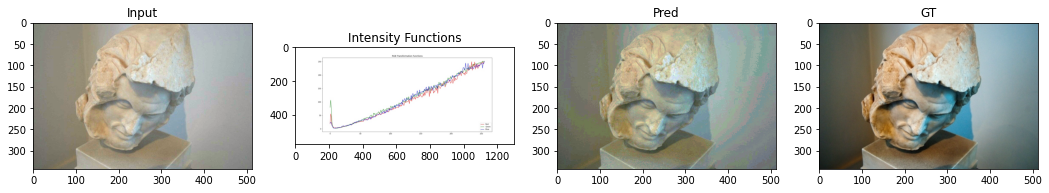

  0%|          | 1/500 [00:00<07:01,  1.18it/s]

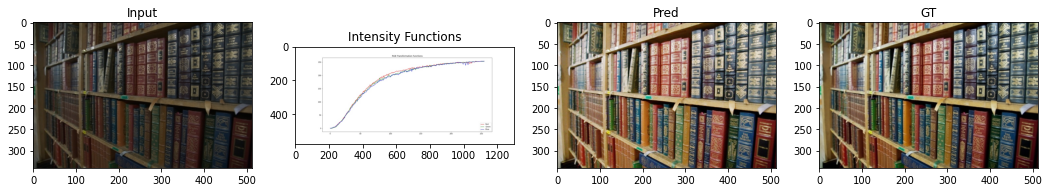

  0%|          | 2/500 [00:01<06:57,  1.19it/s]

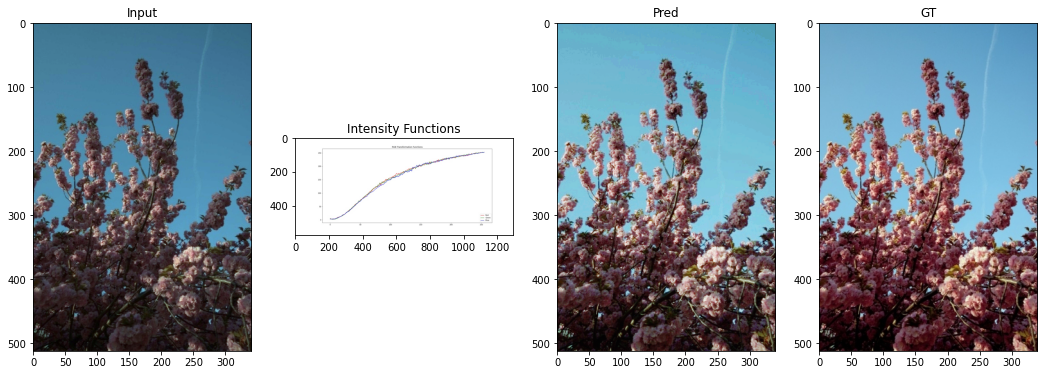

  1%|          | 3/500 [00:02<07:12,  1.15it/s]

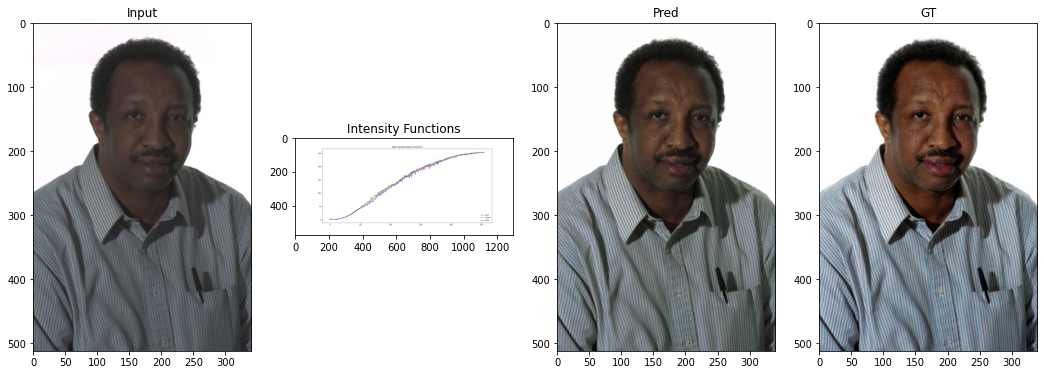

  1%|          | 4/500 [00:03<07:38,  1.08it/s]

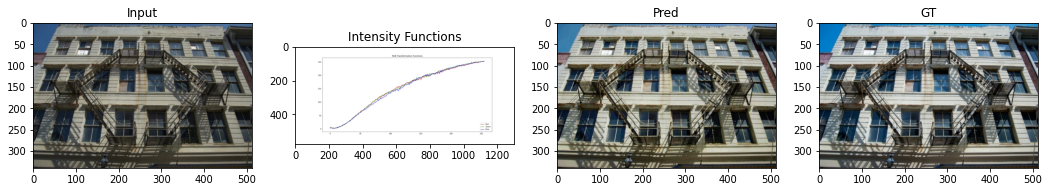

100%|██████████| 500/500 [02:18<00:00,  3.61it/s]


Test PSNR : 23.319131 Test SSIM : 0.862027


<Figure size 1296x576 with 0 Axes>

In [78]:
eval()